## Forecasting

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_forecast = pd.read_csv("ForecastData.csv", index_col=0)

In [3]:
# Date to datetime
data_forecast.index = pd.to_datetime(data_forecast.index)

In [4]:
# load csv ProcessedData_2025.csv
data_forecast_2025 = pd.read_csv("ProcessedData.csv", index_col=0)
data_forecast_2025.index = pd.to_datetime(data_forecast_2025.index)
# for now we will only use VIX Close, WTI Spot Price, IT Adj Close_Return, HC Adj Close_Return AND CD Adj Close_Return, IT Volume, HD Volume, CD Volume
data_forecast_2025 = data_forecast_2025[['VIX Close', 'WTI Log Daily Change', 'IT_Log_Return', 'HC_Log_Return', 'CD_Log_Return', 'IT Volume', 'HC Volume', 'CD Volume']]
# rename VIX Close to VIX, IT Adj Close_Return to IT Daily Return, HC Adj Close_Return to HC Daily Return, CD Adj Close_Return to CD Daily Return
data_forecast_2025.rename(columns={'VIX Close': 'VIX'})#, 'IT_Return': 'IT Daily Return', 'HC Adj Close_Return': 'HC Daily Return', 'CD Adj Close_Return': 'CD Daily Return'}, inplace=True)
# remame HC Daily Return to Health Care Daily Return, CD Daaily Return to Consumer Discretionary Daily Return, IT Daily Return to Information Technology Daily Return
data_forecast_2025.rename(columns={'HC_Log_Return': 'Health Care Daily Log Return', 'CD_Log_Return': 'Consumer Discretionary Daily Log Return', 'IT_Log_Return': 'Information Technology Daily Log Return'}, inplace=True)
data_forecast_2025.head()

# Define sectors
sectors = ['Health Care Daily Log Return', 'Information Technology Daily Log Return', 'Consumer Discretionary Daily Log Return']

# Define event-based high uncertainty periods
high_uncertainty_periods = [
    ("Asian Financial Crisis", "1997-07-01", "1998-10-01"),
    ("Dot-Com Bubble", "2000-03-01", "2002-10-01"),
    ("Post-9/11 Market Shock", "2001-09-11", "2001-12-31"),
    ("Iraq War", "2003-10-01", "2003-12-31"),
    ("Global Financial Crisis", "2007-07-01", "2009-03-01"),
    ("European Debt Crisis", "2010-05-01", "2012-06-01"),
    ("US Debt Ceiling Crisis", "2011-07-01", "2011-08-31"),
    ("China Market Crash & Oil Collapse", "2015-06-01", "2016-03-01"),
    ("COVID-19 Pandemic", "2020-03-01", "2021-06-01"),
    ("2022 Inflation & Rate Hikes", "2022-01-01", "2023-06-01")
]

# Convert dates to datetime format
data_forecast_2025.index = pd.to_datetime(data_forecast_2025.index)
 # Assign "High Uncertainty" based on event classification
data_forecast_2025["Uncertainty Regime"] = "Normal Uncertainty"  # Default category
for _, start, end in high_uncertainty_periods:
    mask = (data_forecast_2025.index >= pd.to_datetime(start)) & (data_forecast_2025.index <= pd.to_datetime(end))
    data_forecast_2025.loc[mask, "Uncertainty Regime"] = "High Uncertainty"

In [5]:
# join the two to get the full data, but ensure no dates are duplicated
data_forecast = pd.concat([data_forecast, data_forecast_2025])
data_forecast = data_forecast.loc[~data_forecast.index.duplicated(keep='first')]
#ata_forecast = data_forecast.dropna()

In [6]:
data_forecast

,VIX Close,WTI Log Daily Change,Information Technology Daily Log Return,Health Care Daily Log Return,Consumer Discretionary Daily Log Return,IT Volume,HC Volume,CD Volume,Uncertainty Regime
Date,,,,,,,,,
1993-05-05,12.38,0.002937,0.008621,0.008757,-0.002610,0,0,0,Normal Uncertainty
1993-05-06,13.22,0.001465,-0.006131,-0.013274,-0.003120,0,0,0,Normal Uncertainty
1993-05-07,13.01,-0.002933,0.008729,-0.004760,-0.000605,0,0,0,Normal Uncertainty
1993-05-10,13.72,-0.000490,-0.000779,0.001220,0.005332,0,0,0,Normal Uncertainty
1993-05-11,13.35,-0.001961,-0.006381,0.002877,0.002706,0,0,0,Normal Uncertainty
...,...,...,...,...,...,...,...,...,...
2025-04-22,30.57,0.017490,0.024226,0.017848,0.031825,806867100,223050800,472384400,Normal Uncertainty
2025-04-23,28.45,-0.030810,0.028758,0.005340,0.027267,978415600,280000500,591385400,Normal Uncertainty
2025-04-24,26.47,0.014423,0.034781,0.012289,0.022318,938353200,254195200,431896300,Normal Uncertainty


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order Selection Results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -31.09      -31.08   3.144e-14      -31.09
1       -35.13     -35.09*   5.524e-16      -35.12
2       -35.15      -35.08   5.448e-16     -35.12*
3       -35.15      -35.05   5.416e-16      -35.12
4       -35.16      -35.03   5.370e-16      -35.11
5       -35.18      -35.01   5.290e-16      -35.12
6       -35.18      -34.98   5.241e-16      -35.11
7       -35.19      -34.96   5.199e-16      -35.11
8       -35.20      -34.93   5.173e-16      -35.11
9       -35.20      -34.91   5.138e-16      -35.10
10      -35.21      -34.88   5.130e-16      -35.09
11      -35.21      -34.85   5.121e-16      -35.08
12      -35.21      -34.82   5.088e-16      -35.08
13     -35.22*      -34.79  5.063e-16*      -35.07
14      -35.21      -34.76   5.087e-16      -35.05
15      -35.21      -34.72   5.102e-16      -35.04
16

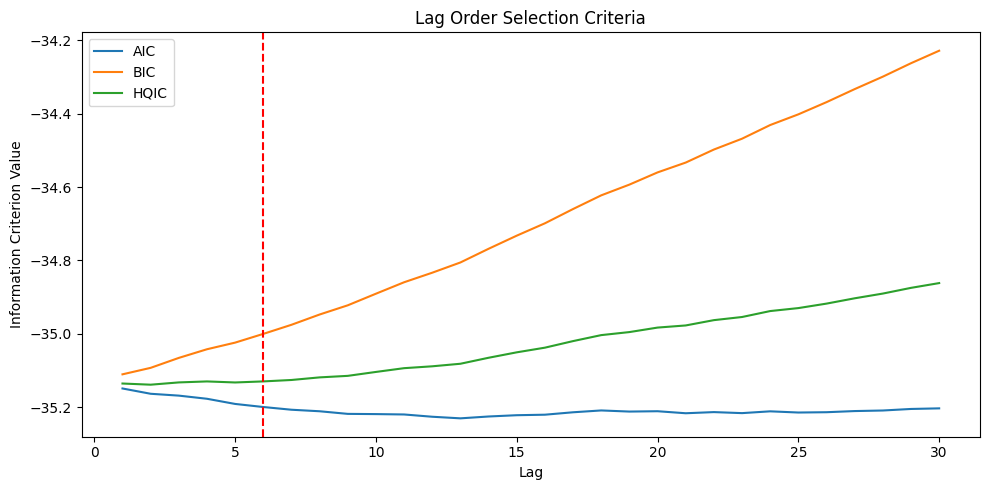

In [8]:
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Only keep data after 2005-01-01
data_forecast_relevant = data_forecast.loc[data_forecast.index >= '2005-01-01']

# Select relevant columns for VAR model
columns = [
    'VIX Close',
    'WTI Log Daily Change',
    'Information Technology Daily Log Return',
    'Health Care Daily Log Return',
    'Consumer Discretionary Daily Log Return'
]

# Drop missing values (important for VAR)
data_lag = data_forecast_relevant[columns].dropna()

# Fit VAR model to determine optimal lag length
model = VAR(data_lag)

# Perform lag order selection up to a reasonable max (e.g., 30 lags)
lag_selection = model.select_order(maxlags=30)

# Print lag order criteria
print("Lag Order Selection Results:")
print(lag_selection.summary())

# Optional: plot the information criteria
ic_data_forecast = pd.DataFrame({
    'AIC': [model.fit(i).aic for i in range(1, 31)],
    'BIC': [model.fit(i).bic for i in range(1, 31)],
    'HQIC': [model.fit(i).hqic for i in range(1, 31)]
}, index=range(1, 31))

ic_data_forecast.plot(figsize=(10, 5), title='Lag Order Selection Criteria')
plt.xlabel("Lag")
plt.ylabel("Information Criterion Value")
# make a -- line in red color for lag = 6 to show that it is the middle ground between the three criteria
plt.axvline(x=6, color='red', linestyle='--', label='Lag = 6')
plt.grid(False)
plt.tight_layout()
plt.show()


In [9]:
# Feature Engineering Template for Forecasting Sector Returns (e.g., Information Technology)

import pandas as pd
import numpy as np

# === CONFIGURATION ===
sector = 'Health Care Daily Log Return' #'Information Technology Daily Log Return'
max_lag = 6  # use the lag length based on BIC from your VAR analysis


# === LAGGED FEATURES ===
for lag in range(1, max_lag):
    data_forecast[f'Return_Lag_{lag+1}'] = data_forecast[sector].shift(lag)
    data_forecast[f'WTI_Lag_{lag+1}'] = data_forecast['WTI Log Daily Change'].shift(lag)
    data_forecast[f'VIX_Lag_{lag+1}'] = data_forecast['VIX Close'].shift(lag)

# === ROLLING FEATURES ===
data_forecast['VIX_5D_MA'] = data_forecast['VIX Close'].rolling(5).mean()
data_forecast['WTI_5D_MA'] = data_forecast['WTI Log Daily Change'].rolling(5).mean()
data_forecast['VIX_5D_STD'] = data_forecast['VIX Close'].rolling(5).std()
data_forecast['WTI_5D_STD'] = data_forecast['WTI Log Daily Change'].rolling(5).std()
# also get std for the sector
data_forecast['Return_5D_STD'] = data_forecast[sector].rolling(5).std()

# === INTERACTION FEATURES ===
# These are constructed to capture potential non-linear and conditional effects, e.g., stronger oil impact during high uncertainty.
data_forecast['VIX_x_WTI'] = data_forecast['VIX Close'] * data_forecast['WTI Log Daily Change']
data_forecast['LagReturn_x_VIX'] = data_forecast[sector] * data_forecast['VIX Close']

# === CRISIS PROXY FEATURE ===
data_forecast['High_VIX_Dummy'] = (data_forecast['VIX Close'] > 30).astype(int)

# === TARGET VARIABLE ===
data_forecast['Target'] = data_forecast[sector].shift(-1)  # Next-day return as prediction target

# === FINAL CLEANING ===
data_forecast_model = data_forecast.dropna(subset=['Target'])

# since it is sampled on IT we want to drop Health Care Daily Log Return, Consumer Discretionary Daily Log Return, HC Volume, CD Volume
#data_forecast_model = data_forecast_model.drop(columns=['Health Care Daily Log Return', 'Consumer Discretionary Daily Log Return', 'HC Volume', 'CD Volume'])
data_forecast_model = data_forecast_model.drop(columns=['Information Technology Daily Log Return', 'Consumer Discretionary Daily Log Return', 'CD Volume', 'IT Volume'])

# also make Uncertainty Regime binary. 0 for normal and 1 for high uncertainty regime
data_forecast_model['Uncertainty Regime'] = data_forecast_model['High_VIX_Dummy'].astype(int)
# drop High VIX Dummy
data_forecast_model = data_forecast_model.drop(columns=['High_VIX_Dummy'])

# remove nan values that have arisen due to the lagging and rolling features
data_forecast_model = data_forecast_model.dropna()


In [7]:
import pandas as pd
import numpy as np

def generate_forecasting_dataset(data_forecast, sector_column, max_lag=6):
    sector_short = sector_column.split()[0]  # 'Health', 'Information', 'Consumer'

    # === LAGGED FEATURES ===
    for lag in range(1, max_lag):
        data_forecast[f'Return_Lag_{lag+1}'] = data_forecast[sector_column].shift(lag)
        data_forecast[f'WTI_Lag_{lag+1}'] = data_forecast['WTI Log Daily Change'].shift(lag)
        data_forecast[f'VIX_Lag_{lag+1}'] = data_forecast['VIX Close'].shift(lag)

    # === ROLLING FEATURES ===
    data_forecast['VIX_5D_MA'] = data_forecast['VIX Close'].rolling(5).mean()
    data_forecast['WTI_5D_MA'] = data_forecast['WTI Log Daily Change'].rolling(5).mean()
    data_forecast['VIX_5D_STD'] = data_forecast['VIX Close'].rolling(5).std()
    data_forecast['WTI_5D_STD'] = data_forecast['WTI Log Daily Change'].rolling(5).std()
    data_forecast['Return_5D_STD'] = data_forecast[sector_column].rolling(5).std()

    # === INTERACTION FEATURES ===
    data_forecast['VIX_x_WTI'] = data_forecast['VIX Close'] * data_forecast['WTI Log Daily Change']
    data_forecast['LagReturn_x_VIX'] = data_forecast[sector_column] * data_forecast['VIX Close']

    # === CRISIS PROXY FEATURE ===
    data_forecast['High_VIX_Dummy'] = (data_forecast['VIX Close'] > 30).astype(int)

    # === TARGET VARIABLE ===
    data_forecast['Target'] = data_forecast[sector_column].shift(-1)  # Next-day return as target

    # === FINAL CLEANING ===
    data_forecast_model = data_forecast.dropna(subset=['Target'])

    # # Drop irrelevant sector columns and volumes
    # drop_cols = [
    #     'Health Care Daily Log Return', 
    #     'Information Technology Daily Log Return', 
    #     'Consumer Discretionary Daily Log Return',
    #     'HC Volume', 'IT Volume', 'CD Volume'
    # ]
    # drop_cols = [col for col in drop_cols if col != sector_column]  # Keep current sector
    # data_forecast_model = data_forecast_model.drop(columns=drop_cols, errors='ignore')

    if sector_column == 'Health Care Daily Log Return':
        data_forecast_model = data_forecast_model.drop(columns=['Information Technology Daily Log Return', 'Consumer Discretionary Daily Log Return', 'IT Volume', 'CD Volume'])
    elif sector_column == 'Information Technology Daily Log Return':
        data_forecast_model = data_forecast_model.drop(columns=['Health Care Daily Log Return', 'Consumer Discretionary Daily Log Return', 'HC Volume', 'CD Volume'])
    elif sector_column == 'Consumer Discretionary Daily Log Return':
        data_forecast_model = data_forecast_model.drop(columns=['Health Care Daily Log Return', 'Information Technology Daily Log Return', 'HC Volume', 'IT Volume'])

    # Handle uncertainty regime
    data_forecast_model['Uncertainty Regime'] = data_forecast_model['High_VIX_Dummy'].astype(int)
    data_forecast_model = data_forecast_model.drop(columns=['High_VIX_Dummy'])

    # Final clean-up for NaN values caused by lagging/rolling
    data_forecast_model = data_forecast_model.dropna()

    return data_forecast_model

# === Generate datasets for each sector ===
health_care_df = generate_forecasting_dataset(data_forecast.copy(), 'Health Care Daily Log Return')
it_df = generate_forecasting_dataset(data_forecast.copy(), 'Information Technology Daily Log Return')
consumer_discretionary_df = generate_forecasting_dataset(data_forecast.copy(), 'Consumer Discretionary Daily Log Return')

# Example usage: health_care_df.head()


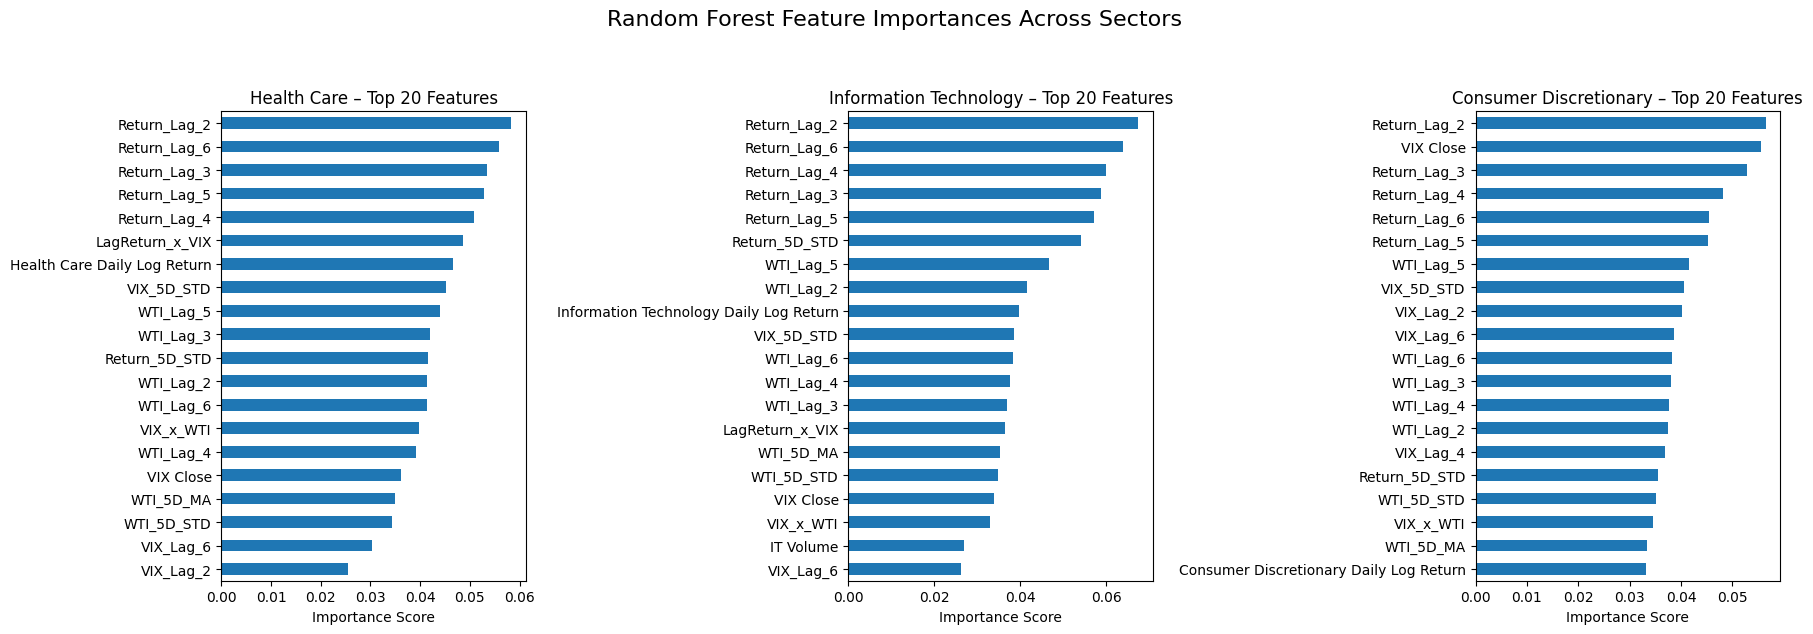

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# === CONFIG ===
sector_dfs = {
    'Health Care': health_care_df,
    'Information Technology': it_df,
    'Consumer Discretionary': consumer_discretionary_df
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Removed sharey=True
fig.subplots_adjust(wspace=0.4)

for ax, (sector_name, df) in zip(axes, sector_dfs.items()):
    X = df.drop(columns=['Target'])
    y = df['Target']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Fit Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Feature Importances
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    
    # Plot Top 20
    importances.head(20).plot(kind='barh', ax=ax)
    ax.set_title(f"{sector_name} – Top 20 Features", fontsize=12)
    ax.set_xlabel("Importance Score")
    ax.invert_yaxis()
    ax.grid(False)

fig.suptitle("Random Forest Feature Importances Across Sectors", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


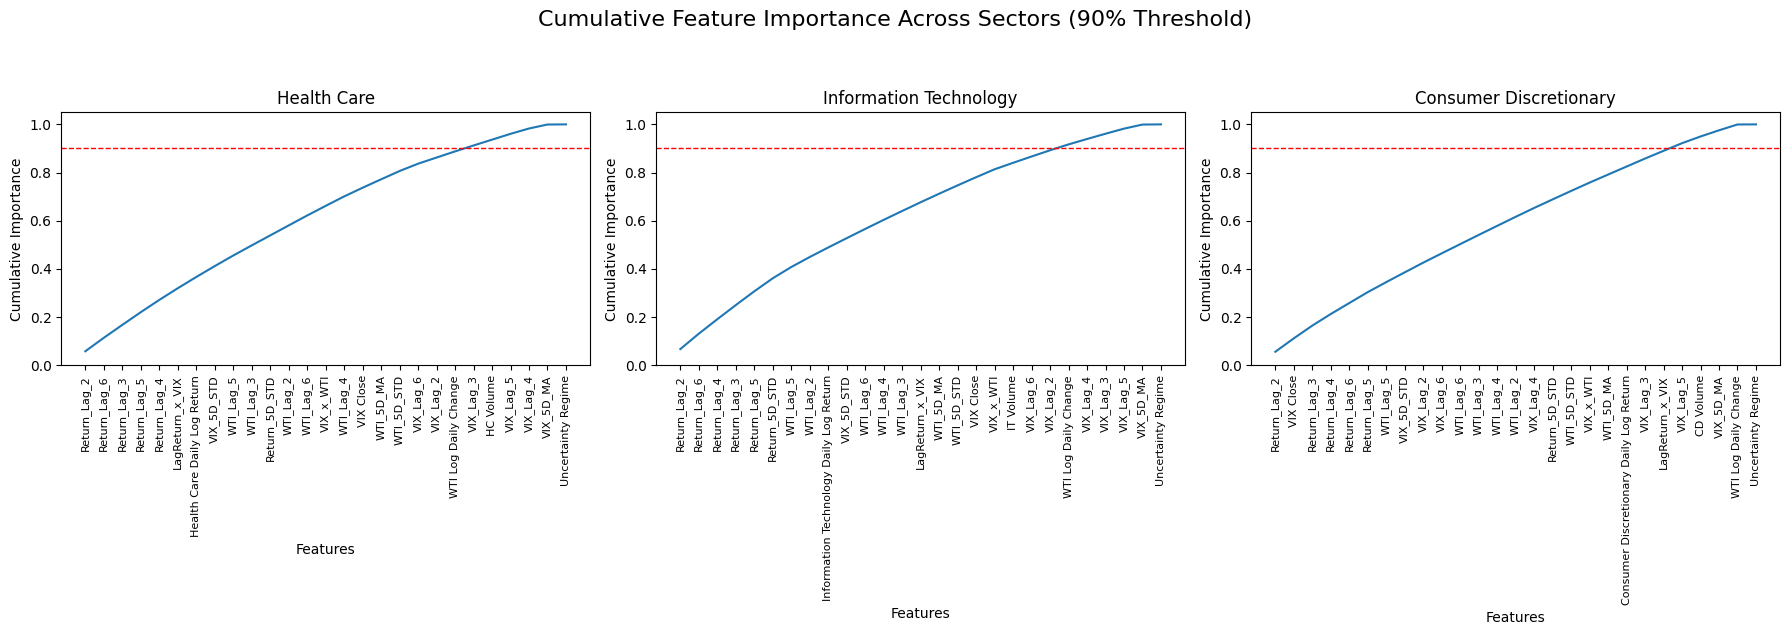

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# === CONFIG ===
sector_dfs = {
    'Health Care': health_care_df,
    'Information Technology': it_df,
    'Consumer Discretionary': consumer_discretionary_df
}

important_features_dict = {}  # To store important features for each sector

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.4)

for ax, (sector_name, df) in zip(axes, sector_dfs.items()):
    X = df.drop(columns=['Target'])
    y = df['Target']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Fit Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Feature Importances
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    cumulative_importance = importances.cumsum()
    
    # Extract features contributing up to 90% of cumulative importance
    important_features = cumulative_importance[cumulative_importance <= 0.90].index.tolist()
    
    # Save to dictionary as a DataFrame for easier handling
    important_features_dict[sector_name] = pd.DataFrame({
        'Feature': importances.index,
        'Importance': importances.values,
        'Cumulative Importance': cumulative_importance.values
    })
    
    # Plot Cumulative Importance
    cumulative_importance.plot(ax=ax)
    ax.axhline(y=0.90, color='red', linestyle='--', linewidth=1)
    ax.set_title(f"{sector_name}", fontsize=12)
    ax.set_xlabel("Features")
    ax.set_ylabel("Cumulative Importance")
    ax.set_xticks(range(len(importances)))
    ax.set_xticklabels(importances.index, rotation=90, fontsize=8)
    ax.grid(False)
    ax.set_ylim(0, 1.05)

fig.suptitle("Cumulative Feature Importance Across Sectors (90% Threshold)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


In [10]:
# get selected features for each sector only choose up to the 90% threshold
health_care_features = important_features_dict['Health Care'].loc[important_features_dict['Health Care']['Cumulative Importance'] <= 0.90, 'Feature'].tolist()
it_features = important_features_dict['Information Technology'].loc[important_features_dict['Information Technology']['Cumulative Importance'] <= 0.90, 'Feature'].tolist()
consumer_discretionary_features = important_features_dict['Consumer Discretionary'].loc[important_features_dict['Consumer Discretionary']['Cumulative Importance'] <= 0.90, 'Feature'].tolist()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Information Technology

In [15]:
# define selected features

#selected_features = important_features.tolist()
selected_features = it_features
target_column = 'Target'

In [16]:
selected_features

['Return_Lag_2',
 'Return_Lag_6',
 'Return_Lag_4',
 'Return_Lag_3',
 'Return_Lag_5',
 'Return_5D_STD',
 'WTI_Lag_5',
 'WTI_Lag_2',
 'Information Technology Daily Log Return',
 'VIX_5D_STD',
 'WTI_Lag_6',
 'WTI_Lag_4',
 'WTI_Lag_3',
 'LagReturn_x_VIX',
 'WTI_5D_MA',
 'WTI_5D_STD',
 'VIX Close',
 'VIX_x_WTI',
 'IT Volume',
 'VIX_Lag_6',
 'VIX_Lag_2']

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

# ---------------------- SETTINGS ----------------------
sector_df = it_df  # Change this for other sectors
selected_features = it_features  # Update with the correct variable for selected features
target_column = 'Target'

# ---------------------- DATA SPLIT ----------------------
train_start = "2000-01-01"
train_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2025-03-31"

train = sector_df.loc[train_start:train_end]
test = sector_df.loc[test_start:test_end]

# ---------------------- SCALE FEATURES ----------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[selected_features])
test_scaled = scaler.transform(test[selected_features])

train_scaled = pd.DataFrame(train_scaled, columns=selected_features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=selected_features, index=test.index)

train_scaled[target_column] = train[target_column].values
test_scaled[target_column] = test[target_column].values

X_train, X_test = train_scaled[selected_features], test_scaled[selected_features]
y_train, y_test = train_scaled[target_column], test_scaled[target_column]

# ---------------------- OPTUNA HYPERPARAMETER TUNING ----------------------
ts_cv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 40),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }
    model = XGBRegressor(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, 
                             scoring='neg_root_mean_squared_error', 
                             cv=ts_cv)
    return -np.mean(scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-05-14 09:17:47,459] A new study created in memory with name: no-name-8dadef63-ebcb-4d02-be9e-aaab89bbb3a7


Best trial: 0. Best value: 0.0135184:   1%|          | 1/100 [00:01<03:04,  1.86s/it]

[I 2025-05-14 09:17:49,315] Trial 0 finished with value: 0.013518447641079229 and parameters: {'n_estimators': 117, 'learning_rate': 0.18151845868485084, 'min_child_weight': 4, 'max_depth': 36, 'subsample': 0.7514629574427629, 'colsample_bytree': 0.705552169402208, 'reg_alpha': 0.3708850817404874, 'reg_lambda': 0.020594763586279874}. Best is trial 0 with value: 0.013518447641079229.


Best trial: 1. Best value: 0.0130183:   2%|▏         | 2/100 [00:02<02:18,  1.42s/it]

[I 2025-05-14 09:17:50,423] Trial 1 finished with value: 0.013018325182085047 and parameters: {'n_estimators': 119, 'learning_rate': 0.16661328876411954, 'min_child_weight': 5, 'max_depth': 20, 'subsample': 0.9733468614235904, 'colsample_bytree': 0.8689511799232728, 'reg_alpha': 0.535050356619954, 'reg_lambda': 0.5770569251380758}. Best is trial 1 with value: 0.013018325182085047.


Best trial: 1. Best value: 0.0130183:   3%|▎         | 3/100 [00:04<02:17,  1.42s/it]

[I 2025-05-14 09:17:51,837] Trial 2 finished with value: 0.01359612990195321 and parameters: {'n_estimators': 236, 'learning_rate': 0.16192808489787147, 'min_child_weight': 1, 'max_depth': 6, 'subsample': 0.7762541180564844, 'colsample_bytree': 0.7915075475740879, 'reg_alpha': 0.39106533059739235, 'reg_lambda': 0.9559049670065884}. Best is trial 1 with value: 0.013018325182085047.


Best trial: 1. Best value: 0.0130183:   4%|▍         | 4/100 [00:06<02:43,  1.70s/it]

[I 2025-05-14 09:17:53,983] Trial 3 finished with value: 0.013544334856679451 and parameters: {'n_estimators': 186, 'learning_rate': 0.15905784353955363, 'min_child_weight': 1, 'max_depth': 12, 'subsample': 0.9007143416673209, 'colsample_bytree': 0.6619685192351609, 'reg_alpha': 0.25661765452177265, 'reg_lambda': 0.13329486922328548}. Best is trial 1 with value: 0.013018325182085047.


Best trial: 4. Best value: 0.0129439:   5%|▌         | 5/100 [00:07<02:26,  1.54s/it]

[I 2025-05-14 09:17:55,236] Trial 4 finished with value: 0.01294387408431596 and parameters: {'n_estimators': 248, 'learning_rate': 0.19237109145098596, 'min_child_weight': 9, 'max_depth': 38, 'subsample': 0.7607239886685568, 'colsample_bytree': 0.7605771686138428, 'reg_alpha': 0.8988671282879631, 'reg_lambda': 0.07337444837518481}. Best is trial 4 with value: 0.01294387408431596.


Best trial: 4. Best value: 0.0129439:   6%|▌         | 6/100 [00:11<03:21,  2.14s/it]

[I 2025-05-14 09:17:58,539] Trial 5 finished with value: 0.014391640653807342 and parameters: {'n_estimators': 294, 'learning_rate': 0.2831026643081658, 'min_child_weight': 7, 'max_depth': 36, 'subsample': 0.770312460577165, 'colsample_bytree': 0.7721280320471936, 'reg_alpha': 0.24482343489521485, 'reg_lambda': 0.33247468286404525}. Best is trial 4 with value: 0.01294387408431596.


Best trial: 4. Best value: 0.0129439:   7%|▋         | 7/100 [00:12<02:55,  1.89s/it]

[I 2025-05-14 09:17:59,919] Trial 6 finished with value: 0.01386248795775621 and parameters: {'n_estimators': 100, 'learning_rate': 0.2643055363743746, 'min_child_weight': 9, 'max_depth': 21, 'subsample': 0.7448768595790886, 'colsample_bytree': 0.8536440730302971, 'reg_alpha': 0.3290600434640495, 'reg_lambda': 0.07403006731980877}. Best is trial 4 with value: 0.01294387408431596.


Best trial: 7. Best value: 0.0128008:   8%|▊         | 8/100 [00:13<02:22,  1.55s/it]

[I 2025-05-14 09:18:00,748] Trial 7 finished with value: 0.012800799604837126 and parameters: {'n_estimators': 125, 'learning_rate': 0.14342775215578682, 'min_child_weight': 4, 'max_depth': 15, 'subsample': 0.8729748542682542, 'colsample_bytree': 0.9928221867263057, 'reg_alpha': 0.9295491441857343, 'reg_lambda': 0.5633802010366684}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 7. Best value: 0.0128008:   9%|▉         | 9/100 [00:16<03:01,  1.99s/it]

[I 2025-05-14 09:18:03,700] Trial 8 finished with value: 0.014281033915806018 and parameters: {'n_estimators': 272, 'learning_rate': 0.2692775411583127, 'min_child_weight': 10, 'max_depth': 38, 'subsample': 0.920548093262444, 'colsample_bytree': 0.8920713374774003, 'reg_alpha': 0.14896915410850897, 'reg_lambda': 0.037931379444894664}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 7. Best value: 0.0128008:  10%|█         | 10/100 [00:17<02:46,  1.85s/it]

[I 2025-05-14 09:18:05,224] Trial 9 finished with value: 0.013005285288882538 and parameters: {'n_estimators': 296, 'learning_rate': 0.18407769953159953, 'min_child_weight': 6, 'max_depth': 27, 'subsample': 0.6853690461966953, 'colsample_bytree': 0.6503723981305746, 'reg_alpha': 0.9321619951344182, 'reg_lambda': 0.89500220113122}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 7. Best value: 0.0128008:  11%|█         | 11/100 [00:18<02:09,  1.46s/it]

[I 2025-05-14 09:18:05,790] Trial 10 finished with value: 0.013091927499900017 and parameters: {'n_estimators': 163, 'learning_rate': 0.10969849353115313, 'min_child_weight': 3, 'max_depth': 3, 'subsample': 0.8596557249920926, 'colsample_bytree': 0.9961373473145181, 'reg_alpha': 0.7230346294522897, 'reg_lambda': 0.5993079869484232}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 7. Best value: 0.0128008:  12%|█▏        | 12/100 [00:19<02:00,  1.37s/it]

[I 2025-05-14 09:18:06,976] Trial 11 finished with value: 0.013077710252905517 and parameters: {'n_estimators': 228, 'learning_rate': 0.22418337320696868, 'min_child_weight': 8, 'max_depth': 28, 'subsample': 0.6134569029056531, 'colsample_bytree': 0.954795075788834, 'reg_alpha': 0.9759152697368012, 'reg_lambda': 0.35051524756636077}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 7. Best value: 0.0128008:  13%|█▎        | 13/100 [00:20<01:51,  1.28s/it]

[I 2025-05-14 09:18:08,035] Trial 12 finished with value: 0.01289907401441047 and parameters: {'n_estimators': 156, 'learning_rate': 0.1169748448039993, 'min_child_weight': 3, 'max_depth': 13, 'subsample': 0.8419170791484172, 'colsample_bytree': 0.7334804578873232, 'reg_alpha': 0.7669892935191037, 'reg_lambda': 0.3707779388843496}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 7. Best value: 0.0128008:  14%|█▍        | 14/100 [00:21<01:46,  1.23s/it]

[I 2025-05-14 09:18:09,172] Trial 13 finished with value: 0.0128484606558421 and parameters: {'n_estimators': 155, 'learning_rate': 0.10427031575874895, 'min_child_weight': 3, 'max_depth': 14, 'subsample': 0.840289440713508, 'colsample_bytree': 0.717160968596255, 'reg_alpha': 0.7575509492536711, 'reg_lambda': 0.7201402455128226}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 7. Best value: 0.0128008:  15%|█▌        | 15/100 [00:22<01:35,  1.13s/it]

[I 2025-05-14 09:18:10,052] Trial 14 finished with value: 0.012840786709096335 and parameters: {'n_estimators': 140, 'learning_rate': 0.1362853726421029, 'min_child_weight': 3, 'max_depth': 14, 'subsample': 0.993110098832275, 'colsample_bytree': 0.6076595874893347, 'reg_alpha': 0.6496843686831855, 'reg_lambda': 0.7733429570554604}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 7. Best value: 0.0128008:  16%|█▌        | 16/100 [00:23<01:30,  1.08s/it]

[I 2025-05-14 09:18:11,026] Trial 15 finished with value: 0.012851603505119213 and parameters: {'n_estimators': 136, 'learning_rate': 0.14412952154765074, 'min_child_weight': 5, 'max_depth': 17, 'subsample': 0.992788178118878, 'colsample_bytree': 0.9391736061483096, 'reg_alpha': 0.5915887689263066, 'reg_lambda': 0.8021625957258218}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 7. Best value: 0.0128008:  17%|█▋        | 17/100 [00:24<01:24,  1.02s/it]

[I 2025-05-14 09:18:11,902] Trial 16 finished with value: 0.013185112853350828 and parameters: {'n_estimators': 193, 'learning_rate': 0.22134355902918615, 'min_child_weight': 2, 'max_depth': 8, 'subsample': 0.9337971229502532, 'colsample_bytree': 0.6039466204889589, 'reg_alpha': 0.6485951098611922, 'reg_lambda': 0.7091945762174674}. Best is trial 7 with value: 0.012800799604837126.


Best trial: 17. Best value: 0.0127885:  18%|█▊        | 18/100 [00:25<01:23,  1.01s/it]

[I 2025-05-14 09:18:12,903] Trial 17 finished with value: 0.012788462411344495 and parameters: {'n_estimators': 175, 'learning_rate': 0.13519937652795516, 'min_child_weight': 4, 'max_depth': 26, 'subsample': 0.9540251959263071, 'colsample_bytree': 0.826601488465089, 'reg_alpha': 0.8352223359007058, 'reg_lambda': 0.46482828761012307}. Best is trial 17 with value: 0.012788462411344495.


Best trial: 17. Best value: 0.0127885:  19%|█▉        | 19/100 [00:26<01:26,  1.07s/it]

[I 2025-05-14 09:18:14,096] Trial 18 finished with value: 0.012903408159702734 and parameters: {'n_estimators': 204, 'learning_rate': 0.13548439452854794, 'min_child_weight': 6, 'max_depth': 27, 'subsample': 0.8839760740558956, 'colsample_bytree': 0.8529343513646462, 'reg_alpha': 0.8349909173087645, 'reg_lambda': 0.4692088460267121}. Best is trial 17 with value: 0.012788462411344495.


Best trial: 17. Best value: 0.0127885:  20%|██        | 20/100 [00:30<02:39,  1.99s/it]

[I 2025-05-14 09:18:18,234] Trial 19 finished with value: 0.014241404160152371 and parameters: {'n_estimators': 180, 'learning_rate': 0.21819574976947217, 'min_child_weight': 4, 'max_depth': 32, 'subsample': 0.9511954151170602, 'colsample_bytree': 0.8221445702064362, 'reg_alpha': 0.02126652903366988, 'reg_lambda': 0.4599287724953607}. Best is trial 17 with value: 0.012788462411344495.


Best trial: 17. Best value: 0.0127885:  21%|██        | 21/100 [00:32<02:23,  1.81s/it]

[I 2025-05-14 09:18:19,626] Trial 20 finished with value: 0.012915453781073314 and parameters: {'n_estimators': 206, 'learning_rate': 0.12430755361044665, 'min_child_weight': 7, 'max_depth': 22, 'subsample': 0.8207212168494162, 'colsample_bytree': 0.9221097484900987, 'reg_alpha': 0.8558224181368337, 'reg_lambda': 0.21526518942912853}. Best is trial 17 with value: 0.012788462411344495.


Best trial: 21. Best value: 0.0126779:  22%|██▏       | 22/100 [00:32<01:51,  1.43s/it]

[I 2025-05-14 09:18:20,153] Trial 21 finished with value: 0.012677929249219224 and parameters: {'n_estimators': 137, 'learning_rate': 0.13932168927353542, 'min_child_weight': 4, 'max_depth': 18, 'subsample': 0.9950033469857709, 'colsample_bytree': 0.6050494634655943, 'reg_alpha': 0.9984398947982167, 'reg_lambda': 0.6026672579035844}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  23%|██▎       | 23/100 [00:33<01:32,  1.21s/it]

[I 2025-05-14 09:18:20,853] Trial 22 finished with value: 0.012744765973724564 and parameters: {'n_estimators': 134, 'learning_rate': 0.1486795078793146, 'min_child_weight': 4, 'max_depth': 25, 'subsample': 0.9540364662348884, 'colsample_bytree': 0.9721223602744155, 'reg_alpha': 0.9513115045252465, 'reg_lambda': 0.6044407470111133}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  24%|██▍       | 24/100 [00:34<01:24,  1.11s/it]

[I 2025-05-14 09:18:21,735] Trial 23 finished with value: 0.012833078207245876 and parameters: {'n_estimators': 172, 'learning_rate': 0.15588944068265395, 'min_child_weight': 5, 'max_depth': 24, 'subsample': 0.956705017845116, 'colsample_bytree': 0.8187357499895523, 'reg_alpha': 0.8151571791982912, 'reg_lambda': 0.6609105667559609}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  25%|██▌       | 25/100 [00:35<01:18,  1.04s/it]

[I 2025-05-14 09:18:22,612] Trial 24 finished with value: 0.012752170410910358 and parameters: {'n_estimators': 145, 'learning_rate': 0.12435450789390666, 'min_child_weight': 2, 'max_depth': 31, 'subsample': 0.9131625463905408, 'colsample_bytree': 0.9009036541187725, 'reg_alpha': 0.9842803715746774, 'reg_lambda': 0.4333331028540936}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  26%|██▌       | 26/100 [00:36<01:14,  1.01s/it]

[I 2025-05-14 09:18:23,558] Trial 25 finished with value: 0.012736975363697781 and parameters: {'n_estimators': 141, 'learning_rate': 0.1212519693646294, 'min_child_weight': 2, 'max_depth': 32, 'subsample': 0.9134148839782902, 'colsample_bytree': 0.910073420411721, 'reg_alpha': 0.9967421758935785, 'reg_lambda': 0.23536355984717655}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  27%|██▋       | 27/100 [00:36<01:03,  1.15it/s]

[I 2025-05-14 09:18:24,101] Trial 26 finished with value: 0.012688438773950681 and parameters: {'n_estimators': 100, 'learning_rate': 0.2066295962932389, 'min_child_weight': 2, 'max_depth': 31, 'subsample': 0.9897896017054176, 'colsample_bytree': 0.9677007212493036, 'reg_alpha': 0.9988133711316809, 'reg_lambda': 0.25676513286750746}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  28%|██▊       | 28/100 [00:37<00:56,  1.28it/s]

[I 2025-05-14 09:18:24,670] Trial 27 finished with value: 0.012692883504622502 and parameters: {'n_estimators': 104, 'learning_rate': 0.20788063435615559, 'min_child_weight': 2, 'max_depth': 32, 'subsample': 0.991417374104141, 'colsample_bytree': 0.9152392665701897, 'reg_alpha': 0.9988301007634198, 'reg_lambda': 0.21693982490578498}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  29%|██▉       | 29/100 [00:37<00:54,  1.31it/s]

[I 2025-05-14 09:18:25,402] Trial 28 finished with value: 0.01287152062936563 and parameters: {'n_estimators': 102, 'learning_rate': 0.23858892880075314, 'min_child_weight': 1, 'max_depth': 18, 'subsample': 0.9975371329948035, 'colsample_bytree': 0.947576796943356, 'reg_alpha': 0.695163575778337, 'reg_lambda': 0.2487953112340535}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  30%|███       | 30/100 [00:39<01:12,  1.03s/it]

[I 2025-05-14 09:18:27,057] Trial 29 finished with value: 0.013375113568050637 and parameters: {'n_estimators': 111, 'learning_rate': 0.2038292917735279, 'min_child_weight': 2, 'max_depth': 34, 'subsample': 0.7137389225542028, 'colsample_bytree': 0.6792346091680256, 'reg_alpha': 0.468692524092458, 'reg_lambda': 0.13507595829082253}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  31%|███       | 31/100 [00:40<01:04,  1.06it/s]

[I 2025-05-14 09:18:27,784] Trial 30 finished with value: 0.012701801597883408 and parameters: {'n_estimators': 115, 'learning_rate': 0.24703931119998718, 'min_child_weight': 2, 'max_depth': 40, 'subsample': 0.998350914748567, 'colsample_bytree': 0.8801750407288691, 'reg_alpha': 0.8805590664922305, 'reg_lambda': 0.30035254075438755}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  32%|███▏      | 32/100 [00:41<01:00,  1.13it/s]

[I 2025-05-14 09:18:28,535] Trial 31 finished with value: 0.012756387975182146 and parameters: {'n_estimators': 115, 'learning_rate': 0.2371953624372988, 'min_child_weight': 2, 'max_depth': 40, 'subsample': 0.9768961295193305, 'colsample_bytree': 0.8778678452465684, 'reg_alpha': 0.9018024416844471, 'reg_lambda': 0.29123543972641786}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  33%|███▎      | 33/100 [00:41<00:56,  1.18it/s]

[I 2025-05-14 09:18:29,288] Trial 32 finished with value: 0.01273097201904334 and parameters: {'n_estimators': 124, 'learning_rate': 0.20469835842129408, 'min_child_weight': 1, 'max_depth': 29, 'subsample': 0.9740566117666555, 'colsample_bytree': 0.9282203831538559, 'reg_alpha': 0.8911722004878191, 'reg_lambda': 0.20145614667555667}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  34%|███▍      | 34/100 [00:42<00:52,  1.27it/s]

[I 2025-05-14 09:18:29,944] Trial 33 finished with value: 0.012846400774160497 and parameters: {'n_estimators': 110, 'learning_rate': 0.24821029137763376, 'min_child_weight': 3, 'max_depth': 35, 'subsample': 0.9399324446231364, 'colsample_bytree': 0.9685703027791513, 'reg_alpha': 0.9979364706569585, 'reg_lambda': 0.4090294303182284}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  35%|███▌      | 35/100 [00:43<00:54,  1.19it/s]

[I 2025-05-14 09:18:30,916] Trial 34 finished with value: 0.01276803210654916 and parameters: {'n_estimators': 123, 'learning_rate': 0.1708956136966006, 'min_child_weight': 1, 'max_depth': 40, 'subsample': 0.970282982653446, 'colsample_bytree': 0.8706698520890808, 'reg_alpha': 0.7943833928692459, 'reg_lambda': 0.5255617654396825}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  36%|███▌      | 36/100 [00:43<00:45,  1.41it/s]

[I 2025-05-14 09:18:31,318] Trial 35 finished with value: 0.01270553553788224 and parameters: {'n_estimators': 103, 'learning_rate': 0.17894679780093478, 'min_child_weight': 2, 'max_depth': 10, 'subsample': 0.99498600204766, 'colsample_bytree': 0.9692061830733838, 'reg_alpha': 0.8859861753682764, 'reg_lambda': 0.14973361426593002}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  37%|███▋      | 37/100 [00:46<01:16,  1.21s/it]

[I 2025-05-14 09:18:33,684] Trial 36 finished with value: 0.013275391621924714 and parameters: {'n_estimators': 127, 'learning_rate': 0.19548608491283834, 'min_child_weight': 1, 'max_depth': 30, 'subsample': 0.89322995479581, 'colsample_bytree': 0.7963841615131722, 'reg_alpha': 0.4897287865392039, 'reg_lambda': 0.28676662355516125}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  38%|███▊      | 38/100 [00:46<01:05,  1.06s/it]

[I 2025-05-14 09:18:34,396] Trial 37 finished with value: 0.012810280374404116 and parameters: {'n_estimators': 111, 'learning_rate': 0.2971414539989038, 'min_child_weight': 3, 'max_depth': 23, 'subsample': 0.9262674476212346, 'colsample_bytree': 0.7574414416000486, 'reg_alpha': 0.9334836183945484, 'reg_lambda': 0.33558547966899765}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  39%|███▉      | 39/100 [00:47<00:58,  1.05it/s]

[I 2025-05-14 09:18:35,109] Trial 38 finished with value: 0.012828888389742535 and parameters: {'n_estimators': 100, 'learning_rate': 0.21074474724651354, 'min_child_weight': 5, 'max_depth': 19, 'subsample': 0.9669278209975611, 'colsample_bytree': 0.8534287786849739, 'reg_alpha': 0.8404312523826369, 'reg_lambda': 0.18386861746514854}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  40%|████      | 40/100 [00:48<00:56,  1.06it/s]

[I 2025-05-14 09:18:36,023] Trial 39 finished with value: 0.012737993480514609 and parameters: {'n_estimators': 152, 'learning_rate': 0.2564821505804183, 'min_child_weight': 2, 'max_depth': 38, 'subsample': 0.9804113583218284, 'colsample_bytree': 0.8892413195585316, 'reg_alpha': 0.8838236486581197, 'reg_lambda': 0.08001108203838356}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  41%|████      | 41/100 [00:49<00:56,  1.04it/s]

[I 2025-05-14 09:18:37,023] Trial 40 finished with value: 0.012971654503121516 and parameters: {'n_estimators': 118, 'learning_rate': 0.23143009981953874, 'min_child_weight': 4, 'max_depth': 34, 'subsample': 0.6101759877100349, 'colsample_bytree': 0.911458232782238, 'reg_alpha': 0.9571210413973581, 'reg_lambda': 0.008883005635895502}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  42%|████▏     | 42/100 [00:49<00:45,  1.28it/s]

[I 2025-05-14 09:18:37,394] Trial 41 finished with value: 0.012699313083636716 and parameters: {'n_estimators': 107, 'learning_rate': 0.17851300027494635, 'min_child_weight': 2, 'max_depth': 7, 'subsample': 0.9939189781224377, 'colsample_bytree': 0.9734019202621322, 'reg_alpha': 0.8882313239832755, 'reg_lambda': 0.10858909833018857}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  43%|████▎     | 43/100 [00:50<00:38,  1.47it/s]

[I 2025-05-14 09:18:37,837] Trial 42 finished with value: 0.012680916315635987 and parameters: {'n_estimators': 133, 'learning_rate': 0.18470138933607866, 'min_child_weight': 1, 'max_depth': 10, 'subsample': 0.997691608506163, 'colsample_bytree': 0.9864702398903994, 'reg_alpha': 0.9426148780873261, 'reg_lambda': 0.09999226077755743}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  44%|████▍     | 44/100 [00:50<00:34,  1.64it/s]

[I 2025-05-14 09:18:38,286] Trial 43 finished with value: 0.012782196172322227 and parameters: {'n_estimators': 131, 'learning_rate': 0.18252340869248548, 'min_child_weight': 1, 'max_depth': 5, 'subsample': 0.9377963988973406, 'colsample_bytree': 0.9987693041519377, 'reg_alpha': 0.9360252087638568, 'reg_lambda': 0.07832430420584308}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  45%|████▌     | 45/100 [00:51<00:32,  1.69it/s]

[I 2025-05-14 09:18:38,828] Trial 44 finished with value: 0.012812472497296914 and parameters: {'n_estimators': 165, 'learning_rate': 0.19185102849493932, 'min_child_weight': 1, 'max_depth': 10, 'subsample': 0.9715457712128304, 'colsample_bytree': 0.9772973439465912, 'reg_alpha': 0.9310250946179552, 'reg_lambda': 0.1162613127942604}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  46%|████▌     | 46/100 [00:52<00:36,  1.50it/s]

[I 2025-05-14 09:18:39,676] Trial 45 finished with value: 0.013301679151687559 and parameters: {'n_estimators': 108, 'learning_rate': 0.1738081427600142, 'min_child_weight': 3, 'max_depth': 7, 'subsample': 0.9015384843985442, 'colsample_bytree': 0.9500502301723981, 'reg_alpha': 0.39550162305927733, 'reg_lambda': 0.0435113064093929}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  47%|████▋     | 47/100 [00:52<00:32,  1.61it/s]

[I 2025-05-14 09:18:40,185] Trial 46 finished with value: 0.012919964290529645 and parameters: {'n_estimators': 146, 'learning_rate': 0.16370463511611347, 'min_child_weight': 1, 'max_depth': 3, 'subsample': 0.6416228293659396, 'colsample_bytree': 0.9823575543976149, 'reg_alpha': 0.9974859633828943, 'reg_lambda': 0.16654148130222407}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  48%|████▊     | 48/100 [00:53<00:39,  1.33it/s]

[I 2025-05-14 09:18:41,238] Trial 47 finished with value: 0.012847377275175556 and parameters: {'n_estimators': 273, 'learning_rate': 0.19047382868398366, 'min_child_weight': 3, 'max_depth': 16, 'subsample': 0.9843744299450691, 'colsample_bytree': 0.9342027094246329, 'reg_alpha': 0.7144047418865731, 'reg_lambda': 0.12057069773408573}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  49%|████▉     | 49/100 [00:54<00:40,  1.25it/s]

[I 2025-05-14 09:18:42,160] Trial 48 finished with value: 0.01299441390670888 and parameters: {'n_estimators': 128, 'learning_rate': 0.2117596007397485, 'min_child_weight': 2, 'max_depth': 11, 'subsample': 0.7784118795936087, 'colsample_bytree': 0.6397029023075135, 'reg_alpha': 0.7698882023672288, 'reg_lambda': 0.0031523584046468933}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  50%|█████     | 50/100 [00:55<00:38,  1.32it/s]

[I 2025-05-14 09:18:42,825] Trial 49 finished with value: 0.012808681389284617 and parameters: {'n_estimators': 231, 'learning_rate': 0.16021223396108528, 'min_child_weight': 3, 'max_depth': 5, 'subsample': 0.9462536708627212, 'colsample_bytree': 0.9579490587024152, 'reg_alpha': 0.9110149512727085, 'reg_lambda': 0.9688159578301355}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  51%|█████     | 51/100 [00:57<01:00,  1.24s/it]

[I 2025-05-14 09:18:45,186] Trial 50 finished with value: 0.013570657731454484 and parameters: {'n_estimators': 119, 'learning_rate': 0.18720642769811988, 'min_child_weight': 1, 'max_depth': 20, 'subsample': 0.9641947071836957, 'colsample_bytree': 0.6849070212929361, 'reg_alpha': 0.24231459507791042, 'reg_lambda': 0.5514275272556655}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  52%|█████▏    | 52/100 [00:58<00:47,  1.00it/s]

[I 2025-05-14 09:18:45,616] Trial 51 finished with value: 0.012679738012976383 and parameters: {'n_estimators': 115, 'learning_rate': 0.1997759933643527, 'min_child_weight': 2, 'max_depth': 8, 'subsample': 0.9991717694739056, 'colsample_bytree': 0.9892971374027584, 'reg_alpha': 0.8651101031963507, 'reg_lambda': 0.27984070106990294}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  53%|█████▎    | 53/100 [00:58<00:38,  1.22it/s]

[I 2025-05-14 09:18:46,023] Trial 52 finished with value: 0.01269782275645108 and parameters: {'n_estimators': 108, 'learning_rate': 0.21287140106659203, 'min_child_weight': 2, 'max_depth': 8, 'subsample': 0.9836860739064658, 'colsample_bytree': 0.9903693474070663, 'reg_alpha': 0.95558656591438, 'reg_lambda': 0.3711154058676343}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  54%|█████▍    | 54/100 [00:59<00:34,  1.33it/s]

[I 2025-05-14 09:18:46,613] Trial 53 finished with value: 0.012731060381501116 and parameters: {'n_estimators': 217, 'learning_rate': 0.19947334855602694, 'min_child_weight': 4, 'max_depth': 9, 'subsample': 0.9811300748388813, 'colsample_bytree': 0.9914633391950417, 'reg_alpha': 0.9565583507369882, 'reg_lambda': 0.37901107838376474}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  55%|█████▌    | 55/100 [00:59<00:31,  1.41it/s]

[I 2025-05-14 09:18:47,216] Trial 54 finished with value: 0.012786559570544512 and parameters: {'n_estimators': 137, 'learning_rate': 0.21378768496513367, 'min_child_weight': 2, 'max_depth': 12, 'subsample': 0.9283575396986202, 'colsample_bytree': 0.9605283327682352, 'reg_alpha': 0.9623910127643711, 'reg_lambda': 0.26142019266217664}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  56%|█████▌    | 56/100 [01:00<00:29,  1.47it/s]

[I 2025-05-14 09:18:47,837] Trial 55 finished with value: 0.012782241933452709 and parameters: {'n_estimators': 100, 'learning_rate': 0.2263113235179344, 'min_child_weight': 3, 'max_depth': 13, 'subsample': 0.9589708599548695, 'colsample_bytree': 0.9881636515285137, 'reg_alpha': 0.8001526809892705, 'reg_lambda': 0.3851472504659571}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  57%|█████▋    | 57/100 [01:00<00:27,  1.56it/s]

[I 2025-05-14 09:18:48,380] Trial 56 finished with value: 0.012732504066526318 and parameters: {'n_estimators': 122, 'learning_rate': 0.20592948952047752, 'min_child_weight': 1, 'max_depth': 15, 'subsample': 0.9997890489939276, 'colsample_bytree': 0.9465862274760107, 'reg_alpha': 0.8565095015056869, 'reg_lambda': 0.3180414779023411}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  58%|█████▊    | 58/100 [01:01<00:25,  1.65it/s]

[I 2025-05-14 09:18:48,911] Trial 57 finished with value: 0.012860685076596112 and parameters: {'n_estimators': 149, 'learning_rate': 0.219568795548508, 'min_child_weight': 10, 'max_depth': 5, 'subsample': 0.867269169407437, 'colsample_bytree': 0.9968372273891404, 'reg_alpha': 0.9670239048526478, 'reg_lambda': 0.6131124405058292}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  59%|█████▉    | 59/100 [01:02<00:26,  1.57it/s]

[I 2025-05-14 09:18:49,614] Trial 58 finished with value: 0.013055253632237963 and parameters: {'n_estimators': 160, 'learning_rate': 0.1969690989629429, 'min_child_weight': 7, 'max_depth': 9, 'subsample': 0.9815403923506634, 'colsample_bytree': 0.6251619478190924, 'reg_alpha': 0.5580917831903066, 'reg_lambda': 0.5079763792332387}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  60%|██████    | 60/100 [01:02<00:24,  1.61it/s]

[I 2025-05-14 09:18:50,197] Trial 59 finished with value: 0.012801624150983121 and parameters: {'n_estimators': 131, 'learning_rate': 0.22949111130279254, 'min_child_weight': 9, 'max_depth': 12, 'subsample': 0.9443673392045363, 'colsample_bytree': 0.7436802104089473, 'reg_alpha': 0.9181931885739701, 'reg_lambda': 0.2267019951682202}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  61%|██████    | 61/100 [01:03<00:25,  1.50it/s]

[I 2025-05-14 09:18:50,974] Trial 60 finished with value: 0.012804670375731953 and parameters: {'n_estimators': 254, 'learning_rate': 0.15335159947663815, 'min_child_weight': 6, 'max_depth': 7, 'subsample': 0.9175172928075233, 'colsample_bytree': 0.9186859316129539, 'reg_alpha': 0.999175241724165, 'reg_lambda': 0.2650099883226401}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  62%|██████▏   | 62/100 [01:03<00:22,  1.68it/s]

[I 2025-05-14 09:18:51,403] Trial 61 finished with value: 0.012699837571138715 and parameters: {'n_estimators': 107, 'learning_rate': 0.18071317855761707, 'min_child_weight': 2, 'max_depth': 7, 'subsample': 0.9862576465912132, 'colsample_bytree': 0.9757109585774227, 'reg_alpha': 0.8550953644938816, 'reg_lambda': 0.18777213436743195}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  63%|██████▎   | 63/100 [01:04<00:20,  1.82it/s]

[I 2025-05-14 09:18:51,846] Trial 62 finished with value: 0.012770426598387272 and parameters: {'n_estimators': 115, 'learning_rate': 0.17697369973469984, 'min_child_weight': 2, 'max_depth': 8, 'subsample': 0.9594922469697124, 'colsample_bytree': 0.9347319953254645, 'reg_alpha': 0.9160520432831227, 'reg_lambda': 0.047049812415854125}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  64%|██████▍   | 64/100 [01:04<00:17,  2.04it/s]

[I 2025-05-14 09:18:52,198] Trial 63 finished with value: 0.012692682691618917 and parameters: {'n_estimators': 108, 'learning_rate': 0.20622489917949935, 'min_child_weight': 2, 'max_depth': 4, 'subsample': 0.998390519220401, 'colsample_bytree': 0.7782615061168607, 'reg_alpha': 0.8694713365637347, 'reg_lambda': 0.09656190424031}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  65%|██████▌   | 65/100 [01:05<00:16,  2.17it/s]

[I 2025-05-14 09:18:52,588] Trial 64 finished with value: 0.012750863309156474 and parameters: {'n_estimators': 140, 'learning_rate': 0.2064390167195145, 'min_child_weight': 3, 'max_depth': 3, 'subsample': 0.9668466825526462, 'colsample_bytree': 0.7788647271211679, 'reg_alpha': 0.9609605550432686, 'reg_lambda': 0.356135475478523}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  66%|██████▌   | 66/100 [01:05<00:14,  2.30it/s]

[I 2025-05-14 09:18:52,965] Trial 65 finished with value: 0.012735445764407698 and parameters: {'n_estimators': 118, 'learning_rate': 0.21867907998342223, 'min_child_weight': 8, 'max_depth': 5, 'subsample': 0.9994124427182267, 'colsample_bytree': 0.8384385191915642, 'reg_alpha': 0.8077776182858918, 'reg_lambda': 0.20936356145293677}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  67%|██████▋   | 67/100 [01:05<00:14,  2.32it/s]

[I 2025-05-14 09:18:53,387] Trial 66 finished with value: 0.01277297437341025 and parameters: {'n_estimators': 107, 'learning_rate': 0.10056295971555507, 'min_child_weight': 1, 'max_depth': 4, 'subsample': 0.9846306874438703, 'colsample_bytree': 0.6908866647562396, 'reg_alpha': 0.7537898239762807, 'reg_lambda': 0.15859184254878952}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  68%|██████▊   | 68/100 [01:07<00:20,  1.56it/s]

[I 2025-05-14 09:18:54,516] Trial 67 finished with value: 0.013027338820513556 and parameters: {'n_estimators': 126, 'learning_rate': 0.2004807052264089, 'min_child_weight': 2, 'max_depth': 27, 'subsample': 0.951577964856713, 'colsample_bytree': 0.6618064879324017, 'reg_alpha': 0.6270103717606562, 'reg_lambda': 0.42357267657252556}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  69%|██████▉   | 69/100 [01:08<00:23,  1.30it/s]

[I 2025-05-14 09:18:55,580] Trial 68 finished with value: 0.012911641332370416 and parameters: {'n_estimators': 134, 'learning_rate': 0.1683818877037283, 'min_child_weight': 4, 'max_depth': 33, 'subsample': 0.8108457479949976, 'colsample_bytree': 0.9615370539390313, 'reg_alpha': 0.8564323592898877, 'reg_lambda': 0.8406080084992248}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  70%|███████   | 70/100 [01:11<00:50,  1.68s/it]

[I 2025-05-14 09:18:59,375] Trial 69 finished with value: 0.014451472572174875 and parameters: {'n_estimators': 114, 'learning_rate': 0.23870976408150768, 'min_child_weight': 3, 'max_depth': 36, 'subsample': 0.7455871536853941, 'colsample_bytree': 0.8102573766189883, 'reg_alpha': 0.05616957729715255, 'reg_lambda': 0.6566892228016142}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  71%|███████   | 71/100 [01:12<00:38,  1.32s/it]

[I 2025-05-14 09:18:59,863] Trial 70 finished with value: 0.012729819304876228 and parameters: {'n_estimators': 100, 'learning_rate': 0.21460209867432384, 'min_child_weight': 2, 'max_depth': 10, 'subsample': 0.9729443305207769, 'colsample_bytree': 0.7210430849157653, 'reg_alpha': 0.965638125831453, 'reg_lambda': 0.3217278857316352}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  72%|███████▏  | 72/100 [01:12<00:29,  1.06s/it]

[I 2025-05-14 09:19:00,302] Trial 71 finished with value: 0.012685705542309014 and parameters: {'n_estimators': 105, 'learning_rate': 0.1916950459124023, 'min_child_weight': 2, 'max_depth': 6, 'subsample': 0.9892910807163348, 'colsample_bytree': 0.9827413827250493, 'reg_alpha': 0.8795666893489463, 'reg_lambda': 0.1005418327384317}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  73%|███████▎  | 73/100 [01:13<00:23,  1.16it/s]

[I 2025-05-14 09:19:00,726] Trial 72 finished with value: 0.012720099340324031 and parameters: {'n_estimators': 120, 'learning_rate': 0.18807882619046282, 'min_child_weight': 1, 'max_depth': 6, 'subsample': 0.9876028501793634, 'colsample_bytree': 0.9848973954759364, 'reg_alpha': 0.9353261627390413, 'reg_lambda': 0.07820353861256796}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  74%|███████▍  | 74/100 [01:14<00:22,  1.15it/s]

[I 2025-05-14 09:19:01,594] Trial 73 finished with value: 0.012786265583687003 and parameters: {'n_estimators': 105, 'learning_rate': 0.20888377769188235, 'min_child_weight': 2, 'max_depth': 29, 'subsample': 0.962974758075281, 'colsample_bytree': 0.9643718851640211, 'reg_alpha': 0.8233888582662534, 'reg_lambda': 0.269494259523922}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  75%|███████▌  | 75/100 [01:14<00:18,  1.35it/s]

[I 2025-05-14 09:19:02,033] Trial 74 finished with value: 0.012715454734784207 and parameters: {'n_estimators': 112, 'learning_rate': 0.19642398535624822, 'min_child_weight': 3, 'max_depth': 8, 'subsample': 0.9876760827546458, 'colsample_bytree': 0.9993407936602227, 'reg_alpha': 0.8783730386154283, 'reg_lambda': 0.09372557160596}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  76%|███████▌  | 76/100 [01:14<00:15,  1.57it/s]

[I 2025-05-14 09:19:02,437] Trial 75 finished with value: 0.012733784288516898 and parameters: {'n_estimators': 123, 'learning_rate': 0.22374223324600984, 'min_child_weight': 1, 'max_depth': 6, 'subsample': 0.9725030109387843, 'colsample_bytree': 0.945118758363893, 'reg_alpha': 0.9794457685088426, 'reg_lambda': 0.23537976848384215}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  77%|███████▋  | 77/100 [01:15<00:13,  1.68it/s]

[I 2025-05-14 09:19:02,931] Trial 76 finished with value: 0.012810464710398248 and parameters: {'n_estimators': 112, 'learning_rate': 0.20372729627128905, 'min_child_weight': 2, 'max_depth': 9, 'subsample': 0.9370184296276813, 'colsample_bytree': 0.9829705467971418, 'reg_alpha': 0.9088519646667221, 'reg_lambda': 0.1407166055031263}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  78%|███████▊  | 78/100 [01:15<00:12,  1.83it/s]

[I 2025-05-14 09:19:03,365] Trial 77 finished with value: 0.012739405146902185 and parameters: {'n_estimators': 104, 'learning_rate': 0.1125494596592836, 'min_child_weight': 1, 'max_depth': 4, 'subsample': 0.9522334660463274, 'colsample_bytree': 0.9045274265700475, 'reg_alpha': 0.9442007969063629, 'reg_lambda': 0.1853096335230111}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  79%|███████▉  | 79/100 [01:16<00:11,  1.82it/s]

[I 2025-05-14 09:19:03,921] Trial 78 finished with value: 0.012771503634227483 and parameters: {'n_estimators': 129, 'learning_rate': 0.1854637903706979, 'min_child_weight': 5, 'max_depth': 11, 'subsample': 0.9914934031121447, 'colsample_bytree': 0.9559674074238447, 'reg_alpha': 0.7792498672449112, 'reg_lambda': 0.29561251903630026}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  80%|████████  | 80/100 [01:18<00:20,  1.03s/it]

[I 2025-05-14 09:19:06,077] Trial 79 finished with value: 0.013121735342019191 and parameters: {'n_estimators': 193, 'learning_rate': 0.14213488803766236, 'min_child_weight': 2, 'max_depth': 31, 'subsample': 0.7218192797135322, 'colsample_bytree': 0.9269844161618496, 'reg_alpha': 0.7359881277417686, 'reg_lambda': 0.47198157278925706}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  81%|████████  | 81/100 [01:19<00:17,  1.10it/s]

[I 2025-05-14 09:19:06,704] Trial 80 finished with value: 0.012725264758837073 and parameters: {'n_estimators': 141, 'learning_rate': 0.19268854763033688, 'min_child_weight': 3, 'max_depth': 25, 'subsample': 0.9999183628596601, 'colsample_bytree': 0.705021752215484, 'reg_alpha': 0.872851256153812, 'reg_lambda': 0.061017833558537314}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  82%|████████▏ | 82/100 [01:19<00:13,  1.31it/s]

[I 2025-05-14 09:19:07,134] Trial 81 finished with value: 0.01274729812331304 and parameters: {'n_estimators': 106, 'learning_rate': 0.19914634701658285, 'min_child_weight': 2, 'max_depth': 7, 'subsample': 0.9777310911954495, 'colsample_bytree': 0.9741954937958127, 'reg_alpha': 0.9038500822888443, 'reg_lambda': 0.10628346393823744}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  83%|████████▎ | 83/100 [01:20<00:11,  1.46it/s]

[I 2025-05-14 09:19:07,624] Trial 82 finished with value: 0.012730945299660545 and parameters: {'n_estimators': 109, 'learning_rate': 0.17321747710769045, 'min_child_weight': 2, 'max_depth': 8, 'subsample': 0.9918950961273216, 'colsample_bytree': 0.9712088476559785, 'reg_alpha': 0.8374615347118607, 'reg_lambda': 0.1644730309625402}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  84%|████████▍ | 84/100 [01:20<00:10,  1.52it/s]

[I 2025-05-14 09:19:08,218] Trial 83 finished with value: 0.012705742136962747 and parameters: {'n_estimators': 116, 'learning_rate': 0.21428043785882792, 'min_child_weight': 2, 'max_depth': 18, 'subsample': 0.9759787337344729, 'colsample_bytree': 0.9867687834800694, 'reg_alpha': 0.9746792927377643, 'reg_lambda': 0.1293422296484657}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  85%|████████▌ | 85/100 [01:21<00:08,  1.73it/s]

[I 2025-05-14 09:19:08,612] Trial 84 finished with value: 0.012788862387527685 and parameters: {'n_estimators': 105, 'learning_rate': 0.19315338513751745, 'min_child_weight': 1, 'max_depth': 4, 'subsample': 0.9636985699573785, 'colsample_bytree': 0.9399942029654879, 'reg_alpha': 0.9336008572322108, 'reg_lambda': 0.020358242302297325}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 21. Best value: 0.0126779:  86%|████████▌ | 86/100 [01:22<00:09,  1.46it/s]

[I 2025-05-14 09:19:09,544] Trial 85 finished with value: 0.012825410569610129 and parameters: {'n_estimators': 100, 'learning_rate': 0.1833145917550057, 'min_child_weight': 2, 'max_depth': 21, 'subsample': 0.9897176626142566, 'colsample_bytree': 0.781448968049816, 'reg_alpha': 0.6832901321655354, 'reg_lambda': 0.10342660245727203}. Best is trial 21 with value: 0.012677929249219224.


Best trial: 86. Best value: 0.0126519:  87%|████████▋ | 87/100 [01:22<00:07,  1.68it/s]

[I 2025-05-14 09:19:09,930] Trial 86 finished with value: 0.012651943919936997 and parameters: {'n_estimators': 120, 'learning_rate': 0.16556185414889288, 'min_child_weight': 3, 'max_depth': 6, 'subsample': 0.9992014604737943, 'colsample_bytree': 0.9537961514527883, 'reg_alpha': 0.8870520249848086, 'reg_lambda': 0.7167939058672343}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  88%|████████▊ | 88/100 [01:22<00:06,  1.79it/s]

[I 2025-05-14 09:19:10,404] Trial 87 finished with value: 0.01271014614592492 and parameters: {'n_estimators': 122, 'learning_rate': 0.1632494555652794, 'min_child_weight': 4, 'max_depth': 6, 'subsample': 0.9796586332365201, 'colsample_bytree': 0.9527042981938706, 'reg_alpha': 0.9969249390248056, 'reg_lambda': 0.7463268639710571}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  89%|████████▉ | 89/100 [01:23<00:06,  1.75it/s]

[I 2025-05-14 09:19:11,004] Trial 88 finished with value: 0.01329315946069951 and parameters: {'n_estimators': 118, 'learning_rate': 0.1562677298124009, 'min_child_weight': 3, 'max_depth': 4, 'subsample': 0.946196542474092, 'colsample_bytree': 0.8935007624864207, 'reg_alpha': 0.43883044046432945, 'reg_lambda': 0.6306069548924591}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  90%|█████████ | 90/100 [01:24<00:06,  1.54it/s]

[I 2025-05-14 09:19:11,842] Trial 89 finished with value: 0.012925888404930499 and parameters: {'n_estimators': 135, 'learning_rate': 0.20237328447667619, 'min_child_weight': 3, 'max_depth': 14, 'subsample': 0.6685903002007585, 'colsample_bytree': 0.6146547246981351, 'reg_alpha': 0.9052908489405678, 'reg_lambda': 0.708278490343907}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  91%|█████████ | 91/100 [01:24<00:05,  1.69it/s]

[I 2025-05-14 09:19:12,290] Trial 90 finished with value: 0.012731115560166118 and parameters: {'n_estimators': 126, 'learning_rate': 0.18911682229469773, 'min_child_weight': 3, 'max_depth': 9, 'subsample': 0.999937389981403, 'colsample_bytree': 0.838492600206651, 'reg_alpha': 0.8693270131507644, 'reg_lambda': 0.8309899514407402}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  92%|█████████▏| 92/100 [01:25<00:04,  1.84it/s]

[I 2025-05-14 09:19:12,723] Trial 91 finished with value: 0.012693377948808472 and parameters: {'n_estimators': 112, 'learning_rate': 0.13087493397837507, 'min_child_weight': 2, 'max_depth': 6, 'subsample': 0.9895612727319618, 'colsample_bytree': 0.9788780872458459, 'reg_alpha': 0.9484634652769132, 'reg_lambda': 0.5770051992369906}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  93%|█████████▎| 93/100 [01:25<00:03,  2.02it/s]

[I 2025-05-14 09:19:13,107] Trial 92 finished with value: 0.012733291489129842 and parameters: {'n_estimators': 114, 'learning_rate': 0.13097578997823095, 'min_child_weight': 2, 'max_depth': 3, 'subsample': 0.9709083310604939, 'colsample_bytree': 0.9908698798050875, 'reg_alpha': 0.9463817327048363, 'reg_lambda': 0.5575095713911289}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  94%|█████████▍| 94/100 [01:26<00:02,  2.16it/s]

[I 2025-05-14 09:19:13,497] Trial 93 finished with value: 0.012703935848336848 and parameters: {'n_estimators': 110, 'learning_rate': 0.14119290314125038, 'min_child_weight': 1, 'max_depth': 6, 'subsample': 0.988357216514864, 'colsample_bytree': 0.9640425767545924, 'reg_alpha': 0.9791030286547201, 'reg_lambda': 0.6828154408632825}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  95%|█████████▌| 95/100 [01:26<00:02,  1.71it/s]

[I 2025-05-14 09:19:14,367] Trial 94 finished with value: 0.013374878949573024 and parameters: {'n_estimators': 120, 'learning_rate': 0.12590218208347564, 'min_child_weight': 2, 'max_depth': 5, 'subsample': 0.9579506378048491, 'colsample_bytree': 0.9793740977461485, 'reg_alpha': 0.3094976863115785, 'reg_lambda': 0.5792557826517707}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  96%|█████████▌| 96/100 [01:27<00:02,  1.70it/s]

[I 2025-05-14 09:19:14,962] Trial 95 finished with value: 0.012706286671983888 and parameters: {'n_estimators': 132, 'learning_rate': 0.14766252831218812, 'min_child_weight': 3, 'max_depth': 11, 'subsample': 0.979483529435303, 'colsample_bytree': 0.9922394015509461, 'reg_alpha': 0.9236226798540903, 'reg_lambda': 0.49311353474021835}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  97%|█████████▋| 97/100 [01:28<00:01,  1.66it/s]

[I 2025-05-14 09:19:15,601] Trial 96 finished with value: 0.012883820990541528 and parameters: {'n_estimators': 103, 'learning_rate': 0.11784297403394839, 'min_child_weight': 2, 'max_depth': 8, 'subsample': 0.8371250296357066, 'colsample_bytree': 0.7598047509658777, 'reg_alpha': 0.8915019021323655, 'reg_lambda': 0.5341305276550055}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  98%|█████████▊| 98/100 [01:28<00:01,  1.57it/s]

[I 2025-05-14 09:19:16,319] Trial 97 finished with value: 0.012785892230303348 and parameters: {'n_estimators': 111, 'learning_rate': 0.20940426238936552, 'min_child_weight': 4, 'max_depth': 36, 'subsample': 0.9665682622294102, 'colsample_bytree': 0.9668467220565964, 'reg_alpha': 0.9444232157968641, 'reg_lambda': 0.9335210456530911}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519:  99%|█████████▉| 99/100 [01:29<00:00,  1.57it/s]

[I 2025-05-14 09:19:16,958] Trial 98 finished with value: 0.012739504468224274 and parameters: {'n_estimators': 146, 'learning_rate': 0.12898552170323857, 'min_child_weight': 1, 'max_depth': 10, 'subsample': 0.9920941064037752, 'colsample_bytree': 0.9436899142968688, 'reg_alpha': 0.8280519399363379, 'reg_lambda': 0.5815780995068495}. Best is trial 86 with value: 0.012651943919936997.


Best trial: 86. Best value: 0.0126519: 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]

[I 2025-05-14 09:19:17,446] Trial 99 finished with value: 0.012810563427585336 and parameters: {'n_estimators': 127, 'learning_rate': 0.2157801768832322, 'min_child_weight': 3, 'max_depth': 6, 'subsample': 0.9309074591044264, 'colsample_bytree': 0.9532897070152284, 'reg_alpha': 0.9724378441483378, 'reg_lambda': 0.3993620470488106}. Best is trial 86 with value: 0.012651943919936997.
Best Hyperparameters: {'n_estimators': 120, 'learning_rate': 0.16556185414889288, 'min_child_weight': 3, 'max_depth': 6, 'subsample': 0.9992014604737943, 'colsample_bytree': 0.9537961514527883, 'reg_alpha': 0.8870520249848086, 'reg_lambda': 0.7167939058672343}


In [26]:
# === SPLIT: Train on recent, test on OOS ===
train_start = "2000-01-01"
train_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2025-04-30"

train = it_df.loc[train_start:train_end]
test = it_df.loc[test_start:test_end]

# ---------------------- SCALE INPUT FEATURES ----------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[selected_features])
test_scaled = scaler.transform(test[selected_features])

# Convert to DataFrame with correct index
train_scaled = pd.DataFrame(train_scaled, columns=selected_features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=selected_features, index=test.index)

# Add back target column
train_scaled[target_column] = train[target_column].values
test_scaled[target_column] = test[target_column].values

X_train, X_test = train_scaled[selected_features], test_scaled[selected_features]
y_train, y_test = train_scaled[target_column], test_scaled[target_column]

In [27]:
import xgboost as xgb
params = {
    "objective": "reg:squarederror",
    "eta": 0.16556185414889288,
    "max_depth": 6,
    "min_child_weight": 3,
    "gamma": 0,
    "subsample":  0.9992014604737943,
    "colsample_bytree": 0.9537961514527883,
    "eval_metric": "rmse",
    "seed": 42
}
# params = {
#     "objective": "reg:squarederror",
#     "eta": 0.14746917727871228,
#     "max_depth": 37,
#     "min_child_weight": 4,
#     "gamma": 0,
#     "subsample":  0.7613712558049603,
#     "colsample_bytree": 0.6239729883156965,
#     "eval_metric": "rmse",
#     "seed": 42
# }
dtrain = xgb.DMatrix(train_scaled[selected_features], label=train_scaled[target_column])
dtest = xgb.DMatrix(test_scaled[selected_features], label=test_scaled[target_column])

num_boost_round = 120
#num_boost_round = 131
model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

y_pred = model.predict(dtest)
y_test = test_scaled[target_column].values

# Inverse log transformation
#y_pred = np.expm1(y_pred)  # exp(x) - 1 to revert log(1 + x)
#y_test = np.expm1(test_scaled[target_column].values)  # exp(x) - 1 to revert log(1 + x)
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0138
RMSE: 0.0191


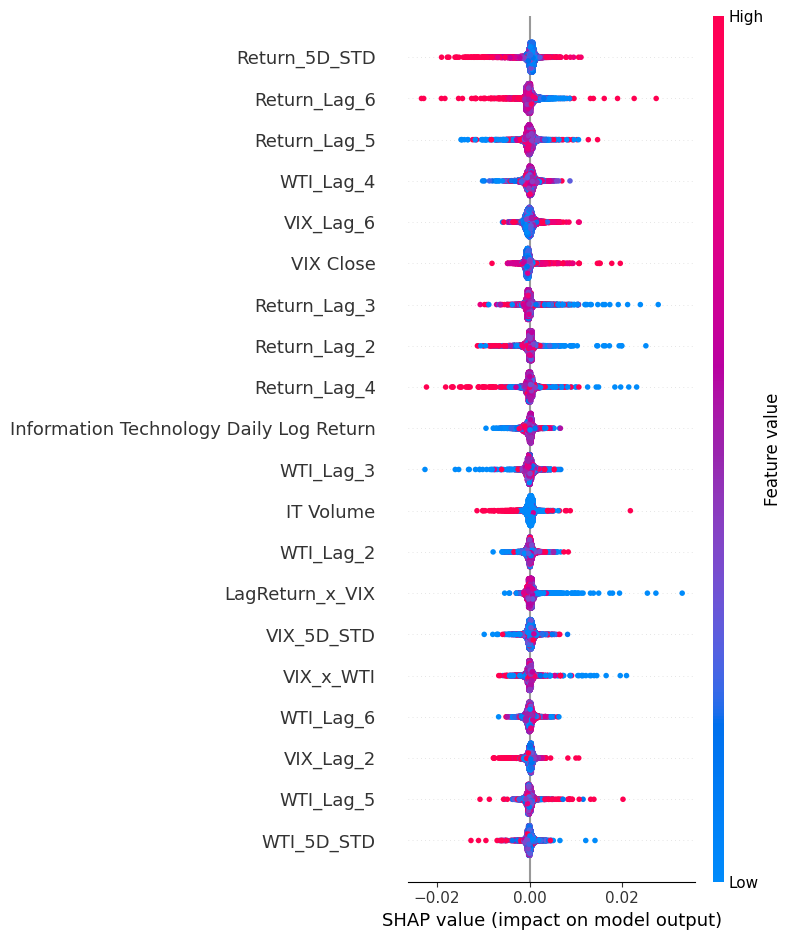

In [28]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.TreeExplainer(model)  # 'model' is your trained XGBoost model
shap_values = explainer.shap_values(X_train)  # 'X_train' is your feature DataFrame

# Create the SHAP Summary Plot (Beeswarm Plot with color coding by feature value)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, show=False)

# Add custom title to match thesis figure naming

plt.tight_layout()
plt.show()

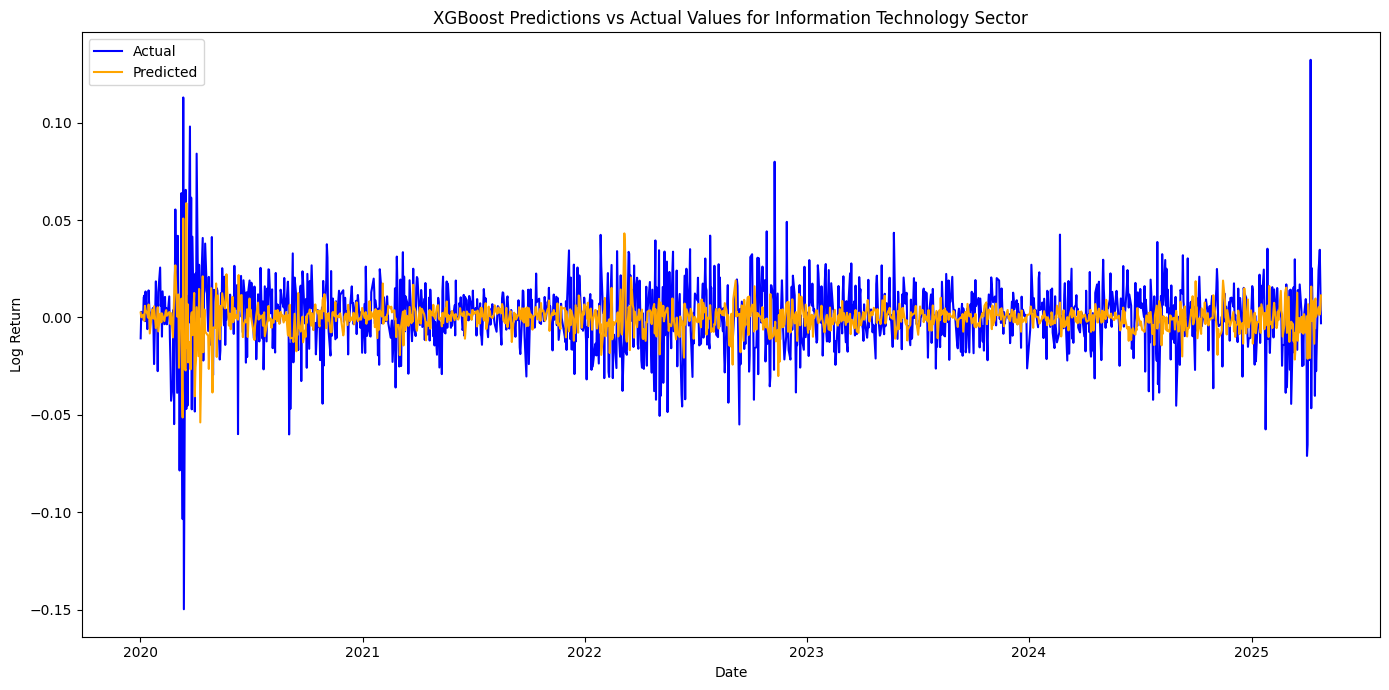

In [29]:
# Get date index from the original test set
test_index = test.index[-len(y_test):]

# Plotting the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test, label='Actual', color='blue')
plt.plot(test_index, y_pred, label='Predicted', color='orange')
plt.title("XGBoost Predictions vs Actual Values for Information Technology Sector")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

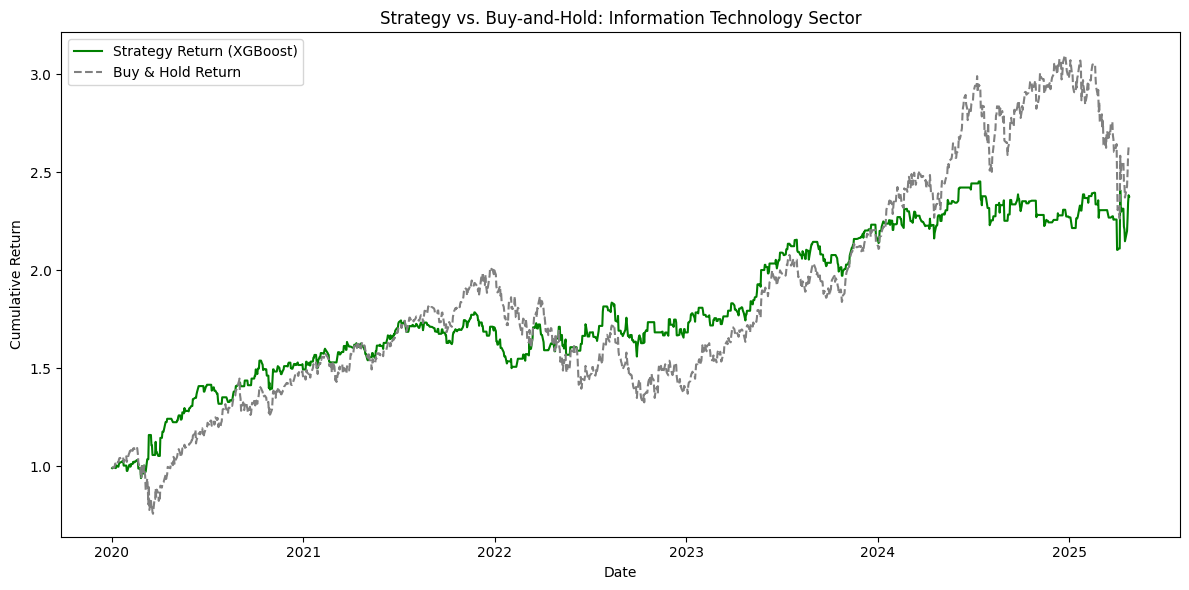

In [30]:
# ---------------------- STRATEGY SIMULATION ----------------------
#signal = np.where(y_pred > 0, 1, -1)
signal = np.where(y_pred > 0, 1, 0)  # Only buy when positive, otherwise stay out

strategy_returns = signal * y_test  # y_test is already a NumPy array

# Cumulative return using log returns -> exp of cumsum
cumulative_strategy = np.exp(np.cumsum(strategy_returns))
cumulative_bh = np.exp(np.cumsum(y_test))


plt.figure(figsize=(12, 6))
plt.plot(test_index, cumulative_strategy, label="Strategy Return (XGBoost)", color="green")
plt.plot(test_index, cumulative_bh, label="Buy & Hold Return", color="gray", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Strategy vs. Buy-and-Hold: Information Technology Sector")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

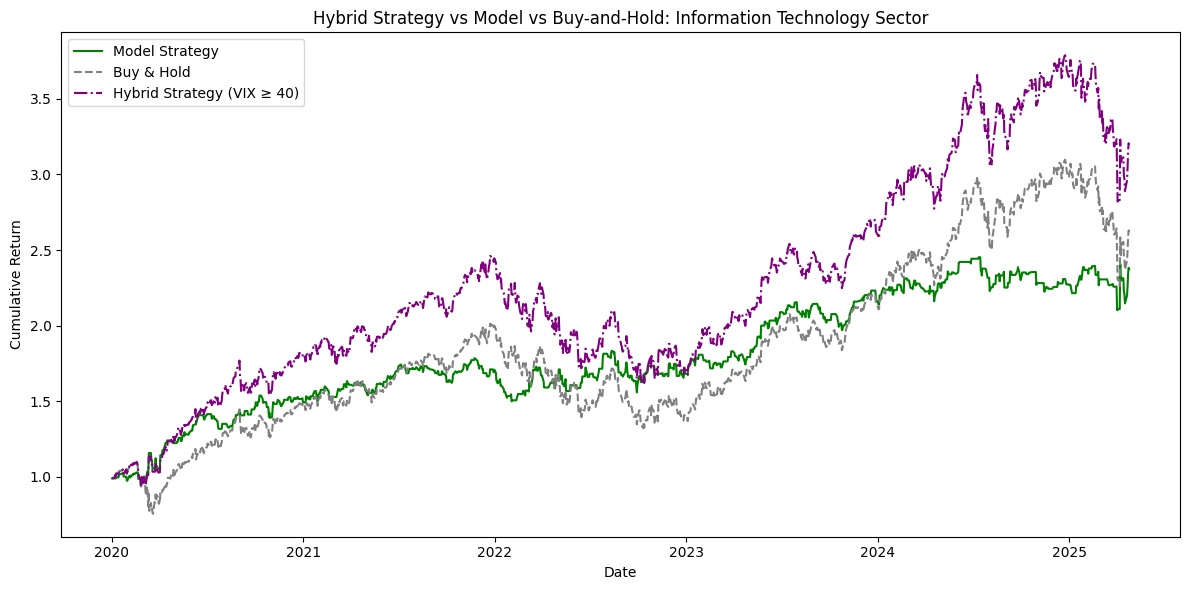

In [31]:
# ---------------------- HYBRID STRATEGY ----------------------

# Extract VIX values for the test period
vix_test = test["VIX Close"].values

# Hybrid strategy signal
hybrid_signal = np.where(vix_test >= 40, signal, 1)  # use model when VIX is high, otherwise hold

# Hybrid strategy returns
hybrid_returns = hybrid_signal * y_test

# Cumulative return using log returns
cumulative_hybrid = np.exp(np.cumsum(hybrid_returns))

# Plot all strategies
plt.figure(figsize=(12, 6))
plt.plot(test_index, cumulative_strategy, label="Model Strategy", color="green", linestyle="-")
plt.plot(test_index, cumulative_bh, label="Buy & Hold", color="gray", linestyle="--")
plt.plot(test_index, cumulative_hybrid, label="Hybrid Strategy (VIX ≥ 40)", color="purple", linestyle="-.")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Hybrid Strategy vs Model vs Buy-and-Hold: Information Technology Sector")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [33]:
# Calculate average annual return and volatility
trading_days_per_year = 252
annualized_return_strategy = np.mean(strategy_returns) * trading_days_per_year
annualized_volatility_strategy = np.std(strategy_returns) * np.sqrt(trading_days_per_year)

annualizd_return_hybrid = np.mean(hybrid_returns) * trading_days_per_year
annualized_volatility_hybrid = np.std(hybrid_returns) * np.sqrt(trading_days_per_year)

annualized_return_bh = np.mean(y_test) * trading_days_per_year
annualized_volatility_bh = np.std(y_test) * np.sqrt(trading_days_per_year)

# total return
total_return_strategy = np.exp(np.sum(strategy_returns)) - 1
total_return_bh = np.exp(np.sum(y_test)) - 1
total_return_hybrid = np.exp(np.sum(hybrid_returns)) - 1

print("\nAnnualized Performance:")
print(f"Strategy - Return: {annualized_return_strategy:.4f}, Volatility: {annualized_volatility_strategy:.4f}")
print(f"Buy & Hold - Return: {annualized_return_bh:.4f}, Volatility: {annualized_volatility_bh:.4f}")
print(f"Hybrid Strategy - Return: {annualizd_return_hybrid:.4f}, Volatility: {annualized_volatility_hybrid:.4f}")
print("\nTotal Return:")
print(f"Strategy: {total_return_strategy:.4f}")
print(f"Buy & Hold: {total_return_bh:.4f}")
print(f"Hybrid Strategy: {total_return_hybrid:.4f}")


Annualized Performance:
Strategy - Return: 0.1642, Volatility: 0.2059
Buy & Hold - Return: 0.1829, Volatility: 0.2935
Hybrid Strategy - Return: 0.2205, Volatility: 0.2724

Total Return:
Strategy: 1.3754
Buy & Hold: 1.6221
Hybrid Strategy: 2.1966


In [294]:
# statistical significance testing between the three to determine whether the hybrid strategy is statistically significantly better than the buy and hold
from scipy.stats import ttest_rel
# Calculate daily returns
strategy_daily_returns = np.diff(np.log(cumulative_strategy))
bh_daily_returns = np.diff(np.log(cumulative_bh))
hybrid_daily_returns = np.diff(np.log(cumulative_hybrid))
# Perform paired t-tests
t_stat_strategy_bh, p_value_strategy_bh = ttest_rel(strategy_daily_returns, bh_daily_returns)
t_stat_hybrid_bh, p_value_hybrid_bh = ttest_rel(hybrid_daily_returns, bh_daily_returns)
t_stat_hybrid_strategy, p_value_hybrid_strategy = ttest_rel(hybrid_daily_returns, strategy_daily_returns)
print("\nStatistical Significance Testing:")
print(f"Strategy vs Buy & Hold: t-stat={t_stat_strategy_bh:.4f}, p-value={p_value_strategy_bh:.4f}")
print(f"Hybrid vs Buy & Hold: t-stat={t_stat_hybrid_bh:.4f}, p-value={p_value_hybrid_bh:.4f}")
print(f"Hybrid vs Strategy: t-stat={t_stat_hybrid_strategy:.4f}, p-value={p_value_hybrid_strategy:.4f}")


Statistical Significance Testing:
Strategy vs Buy & Hold: t-stat=0.7410, p-value=0.4588
Hybrid vs Buy & Hold: t-stat=0.1283, p-value=0.8979
Hybrid vs Strategy: t-stat=-0.8405, p-value=0.4008


Health Care

In [12]:
# define selected features

#selected_features = important_features.tolist()
selected_features = health_care_features
target_column = 'Target'

In [13]:
selected_features

['Return_Lag_2',
 'Return_Lag_6',
 'Return_Lag_3',
 'Return_Lag_5',
 'Return_Lag_4',
 'LagReturn_x_VIX',
 'Health Care Daily Log Return',
 'VIX_5D_STD',
 'WTI_Lag_5',
 'WTI_Lag_3',
 'Return_5D_STD',
 'WTI_Lag_2',
 'WTI_Lag_6',
 'VIX_x_WTI',
 'WTI_Lag_4',
 'VIX Close',
 'WTI_5D_MA',
 'WTI_5D_STD',
 'VIX_Lag_6',
 'VIX_Lag_2',
 'WTI Log Daily Change']

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

# ---------------------- SETTINGS ----------------------
sector_df = health_care_df  # Change this for other sectors
selected_features = health_care_features  # Update with the correct variable for selected features
target_column = 'Target'

# ---------------------- DATA SPLIT ----------------------
train_start = "2000-01-01"
train_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2025-03-31"

train = sector_df.loc[train_start:train_end]
test = sector_df.loc[test_start:test_end]

# ---------------------- SCALE FEATURES ----------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[selected_features])
test_scaled = scaler.transform(test[selected_features])

train_scaled = pd.DataFrame(train_scaled, columns=selected_features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=selected_features, index=test.index)

train_scaled[target_column] = train[target_column].values
test_scaled[target_column] = test[target_column].values

X_train, X_test = train_scaled[selected_features], test_scaled[selected_features]
y_train, y_test = train_scaled[target_column], test_scaled[target_column]

# ---------------------- OPTUNA HYPERPARAMETER TUNING ----------------------
ts_cv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 40),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }
    model = XGBRegressor(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, 
                             scoring='neg_root_mean_squared_error', 
                             cv=ts_cv)
    return -np.mean(scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2025-05-14 09:24:24,364] A new study created in memory with name: no-name-5ca96d3c-0391-4490-8f24-5272641edffa
Best trial: 0. Best value: 0.0104362:   1%|          | 1/100 [00:00<01:18,  1.27it/s]

[I 2025-05-14 09:24:25,150] Trial 0 finished with value: 0.010436173980303038 and parameters: {'n_estimators': 145, 'learning_rate': 0.1017283461734489, 'min_child_weight': 3, 'max_depth': 6, 'subsample': 0.6939259073998644, 'colsample_bytree': 0.616297505309814, 'reg_alpha': 0.1640985636663671, 'reg_lambda': 0.2884994955828427}. Best is trial 0 with value: 0.010436173980303038.


Best trial: 1. Best value: 0.010027:   2%|▏         | 2/100 [00:01<01:21,  1.21it/s] 

[I 2025-05-14 09:24:26,004] Trial 1 finished with value: 0.010026990706775315 and parameters: {'n_estimators': 234, 'learning_rate': 0.19513600465694791, 'min_child_weight': 4, 'max_depth': 21, 'subsample': 0.8745903427139115, 'colsample_bytree': 0.9342709159714717, 'reg_alpha': 0.6854021744567553, 'reg_lambda': 0.7049499011359083}. Best is trial 1 with value: 0.010026990706775315.


Best trial: 1. Best value: 0.010027:   3%|▎         | 3/100 [00:02<01:03,  1.52it/s]

[I 2025-05-14 09:24:26,458] Trial 2 finished with value: 0.010080432122767843 and parameters: {'n_estimators': 142, 'learning_rate': 0.2647127994398204, 'min_child_weight': 8, 'max_depth': 11, 'subsample': 0.9804469208788454, 'colsample_bytree': 0.7229049601747478, 'reg_alpha': 0.49268600036047994, 'reg_lambda': 0.6611765230191152}. Best is trial 1 with value: 0.010026990706775315.


Best trial: 1. Best value: 0.010027:   4%|▍         | 4/100 [00:03<01:14,  1.29it/s]

[I 2025-05-14 09:24:27,413] Trial 3 finished with value: 0.010437816263295003 and parameters: {'n_estimators': 192, 'learning_rate': 0.27597297647621766, 'min_child_weight': 8, 'max_depth': 27, 'subsample': 0.9993471056760495, 'colsample_bytree': 0.6875425078537974, 'reg_alpha': 0.19894402342244544, 'reg_lambda': 0.38163539254463674}. Best is trial 1 with value: 0.010026990706775315.


Best trial: 4. Best value: 0.0099527:   5%|▌         | 5/100 [00:03<01:16,  1.24it/s]

[I 2025-05-14 09:24:28,270] Trial 4 finished with value: 0.009952703143264307 and parameters: {'n_estimators': 282, 'learning_rate': 0.1405554606579757, 'min_child_weight': 1, 'max_depth': 11, 'subsample': 0.6710168661818604, 'colsample_bytree': 0.804277184474907, 'reg_alpha': 0.7533109735210711, 'reg_lambda': 0.10397892623290284}. Best is trial 4 with value: 0.009952703143264307.


Best trial: 4. Best value: 0.0099527:   6%|▌         | 6/100 [00:04<01:15,  1.24it/s]

[I 2025-05-14 09:24:29,085] Trial 5 finished with value: 0.010030442167473024 and parameters: {'n_estimators': 198, 'learning_rate': 0.25206772981949255, 'min_child_weight': 6, 'max_depth': 18, 'subsample': 0.9188600335725419, 'colsample_bytree': 0.9701717184950152, 'reg_alpha': 0.657766178287409, 'reg_lambda': 0.44322538161514546}. Best is trial 4 with value: 0.009952703143264307.


Best trial: 4. Best value: 0.0099527:   7%|▋         | 7/100 [00:05<01:17,  1.19it/s]

[I 2025-05-14 09:24:29,983] Trial 6 finished with value: 0.010066862440100278 and parameters: {'n_estimators': 152, 'learning_rate': 0.21340909593380963, 'min_child_weight': 3, 'max_depth': 20, 'subsample': 0.8981032710604611, 'colsample_bytree': 0.9528725381919203, 'reg_alpha': 0.5994771661646981, 'reg_lambda': 0.5318723383181085}. Best is trial 4 with value: 0.009952703143264307.


Best trial: 7. Best value: 0.00989609:   8%|▊         | 8/100 [00:06<01:08,  1.34it/s]

[I 2025-05-14 09:24:30,543] Trial 7 finished with value: 0.009896087970288755 and parameters: {'n_estimators': 136, 'learning_rate': 0.1303729325318944, 'min_child_weight': 2, 'max_depth': 38, 'subsample': 0.8177986112131589, 'colsample_bytree': 0.614036225817655, 'reg_alpha': 0.8378543479021294, 'reg_lambda': 0.9947914456209938}. Best is trial 7 with value: 0.009896087970288755.


Best trial: 7. Best value: 0.00989609:   9%|▉         | 9/100 [00:07<01:18,  1.16it/s]

[I 2025-05-14 09:24:31,659] Trial 8 finished with value: 0.010574281186243675 and parameters: {'n_estimators': 150, 'learning_rate': 0.24801045458655244, 'min_child_weight': 9, 'max_depth': 19, 'subsample': 0.7278130345318325, 'colsample_bytree': 0.8620105484667485, 'reg_alpha': 0.3315367419150511, 'reg_lambda': 0.0946426730485207}. Best is trial 7 with value: 0.009896087970288755.


Best trial: 7. Best value: 0.00989609:  10%|█         | 10/100 [00:08<01:19,  1.13it/s]

[I 2025-05-14 09:24:32,590] Trial 9 finished with value: 0.010127889291762244 and parameters: {'n_estimators': 106, 'learning_rate': 0.1324194077909962, 'min_child_weight': 9, 'max_depth': 35, 'subsample': 0.9476121940025285, 'colsample_bytree': 0.8379674320147439, 'reg_alpha': 0.3686615211527686, 'reg_lambda': 0.2540857828350638}. Best is trial 7 with value: 0.009896087970288755.


Best trial: 10. Best value: 0.00988744:  11%|█         | 11/100 [00:08<01:11,  1.24it/s]

[I 2025-05-14 09:24:33,214] Trial 10 finished with value: 0.009887435760883297 and parameters: {'n_estimators': 250, 'learning_rate': 0.17220612492046777, 'min_child_weight': 1, 'max_depth': 38, 'subsample': 0.8223304414280576, 'colsample_bytree': 0.6151098893921076, 'reg_alpha': 0.9857264906773311, 'reg_lambda': 0.9926814439575371}. Best is trial 10 with value: 0.009887435760883297.


Best trial: 11. Best value: 0.00988727:  12%|█▏        | 12/100 [00:09<01:05,  1.34it/s]

[I 2025-05-14 09:24:33,834] Trial 11 finished with value: 0.009887274794099515 and parameters: {'n_estimators': 259, 'learning_rate': 0.173298474541684, 'min_child_weight': 1, 'max_depth': 40, 'subsample': 0.7944377865708029, 'colsample_bytree': 0.6055434474265928, 'reg_alpha': 0.9873960551027675, 'reg_lambda': 0.9886369200430686}. Best is trial 11 with value: 0.009887274794099515.


Best trial: 11. Best value: 0.00988727:  13%|█▎        | 13/100 [00:10<01:03,  1.37it/s]

[I 2025-05-14 09:24:34,528] Trial 12 finished with value: 0.009898529077595097 and parameters: {'n_estimators': 275, 'learning_rate': 0.18079349225250335, 'min_child_weight': 1, 'max_depth': 31, 'subsample': 0.7719681207574379, 'colsample_bytree': 0.700721504551656, 'reg_alpha': 0.9750752491306283, 'reg_lambda': 0.9963268934364456}. Best is trial 11 with value: 0.009887274794099515.


Best trial: 13. Best value: 0.00988692:  14%|█▍        | 14/100 [00:10<00:59,  1.45it/s]

[I 2025-05-14 09:24:35,124] Trial 13 finished with value: 0.009886918532082596 and parameters: {'n_estimators': 243, 'learning_rate': 0.168988287884732, 'min_child_weight': 5, 'max_depth': 37, 'subsample': 0.8068941701776179, 'colsample_bytree': 0.6681472193737021, 'reg_alpha': 0.99723433613354, 'reg_lambda': 0.8329661397164954}. Best is trial 13 with value: 0.009886918532082596.


Best trial: 13. Best value: 0.00988692:  15%|█▌        | 15/100 [00:11<00:57,  1.49it/s]

[I 2025-05-14 09:24:35,751] Trial 14 finished with value: 0.009911451968762267 and parameters: {'n_estimators': 227, 'learning_rate': 0.21267550146644937, 'min_child_weight': 6, 'max_depth': 29, 'subsample': 0.6094508983168125, 'colsample_bytree': 0.7495957912936728, 'reg_alpha': 0.8715366729026524, 'reg_lambda': 0.8090936070725028}. Best is trial 13 with value: 0.009886918532082596.


Best trial: 13. Best value: 0.00988692:  16%|█▌        | 16/100 [00:12<01:00,  1.39it/s]

[I 2025-05-14 09:24:36,575] Trial 15 finished with value: 0.009925357717089951 and parameters: {'n_estimators': 297, 'learning_rate': 0.1584052098387812, 'min_child_weight': 5, 'max_depth': 40, 'subsample': 0.7735527942571857, 'colsample_bytree': 0.6624145191194901, 'reg_alpha': 0.8460840384317813, 'reg_lambda': 0.832853038275505}. Best is trial 13 with value: 0.009886918532082596.


Best trial: 13. Best value: 0.00988692:  17%|█▋        | 17/100 [00:12<00:56,  1.46it/s]

[I 2025-05-14 09:24:37,188] Trial 16 finished with value: 0.009895185920837792 and parameters: {'n_estimators': 257, 'learning_rate': 0.2228376160084462, 'min_child_weight': 5, 'max_depth': 33, 'subsample': 0.854485794538308, 'colsample_bytree': 0.7595428007357623, 'reg_alpha': 0.9912207127278293, 'reg_lambda': 0.8472702067841329}. Best is trial 13 with value: 0.009886918532082596.


Best trial: 13. Best value: 0.00988692:  18%|█▊        | 18/100 [00:13<01:02,  1.32it/s]

[I 2025-05-14 09:24:38,114] Trial 17 finished with value: 0.010172539769326857 and parameters: {'n_estimators': 223, 'learning_rate': 0.29729593822294714, 'min_child_weight': 7, 'max_depth': 25, 'subsample': 0.7430301639269781, 'colsample_bytree': 0.6544852183943091, 'reg_alpha': 0.5665189322026459, 'reg_lambda': 0.6028789346934943}. Best is trial 13 with value: 0.009886918532082596.


Best trial: 13. Best value: 0.00988692:  19%|█▉        | 19/100 [00:17<02:04,  1.53s/it]

[I 2025-05-14 09:24:41,452] Trial 18 finished with value: 0.010753150871684205 and parameters: {'n_estimators': 182, 'learning_rate': 0.15432629679289173, 'min_child_weight': 3, 'max_depth': 35, 'subsample': 0.83651483363842, 'colsample_bytree': 0.6491753220400089, 'reg_alpha': 0.06045022365465558, 'reg_lambda': 0.7378304432304709}. Best is trial 13 with value: 0.009886918532082596.


Best trial: 13. Best value: 0.00988692:  20%|██        | 20/100 [00:18<01:48,  1.35s/it]

[I 2025-05-14 09:24:42,380] Trial 19 finished with value: 0.009917331040770139 and parameters: {'n_estimators': 255, 'learning_rate': 0.11423732166135232, 'min_child_weight': 10, 'max_depth': 25, 'subsample': 0.7821394067445264, 'colsample_bytree': 0.7710591202807592, 'reg_alpha': 0.7940036603399017, 'reg_lambda': 0.8907649935485741}. Best is trial 13 with value: 0.009886918532082596.


Best trial: 13. Best value: 0.00988692:  21%|██        | 21/100 [00:18<01:30,  1.14s/it]

[I 2025-05-14 09:24:43,025] Trial 20 finished with value: 0.009909096115829059 and parameters: {'n_estimators': 213, 'learning_rate': 0.1917205672238439, 'min_child_weight': 4, 'max_depth': 40, 'subsample': 0.654113023084553, 'colsample_bytree': 0.8797109599470069, 'reg_alpha': 0.9034458256072735, 'reg_lambda': 0.9070235253775365}. Best is trial 13 with value: 0.009886918532082596.


Best trial: 21. Best value: 0.00988541:  22%|██▏       | 22/100 [00:19<01:16,  1.02it/s]

[I 2025-05-14 09:24:43,630] Trial 21 finished with value: 0.009885409013160684 and parameters: {'n_estimators': 253, 'learning_rate': 0.16758385332696898, 'min_child_weight': 1, 'max_depth': 36, 'subsample': 0.8229717833041493, 'colsample_bytree': 0.6039120637367283, 'reg_alpha': 0.9875972495750914, 'reg_lambda': 0.9953583459838053}. Best is trial 21 with value: 0.009885409013160684.


Best trial: 21. Best value: 0.00988541:  23%|██▎       | 23/100 [00:20<01:10,  1.10it/s]

[I 2025-05-14 09:24:44,385] Trial 22 finished with value: 0.009904175510795653 and parameters: {'n_estimators': 272, 'learning_rate': 0.1677866578119494, 'min_child_weight': 2, 'max_depth': 35, 'subsample': 0.7331921797303202, 'colsample_bytree': 0.6014347532493727, 'reg_alpha': 0.9108142558143205, 'reg_lambda': 0.7652209026289956}. Best is trial 21 with value: 0.009885409013160684.


Best trial: 21. Best value: 0.00988541:  24%|██▍       | 24/100 [00:20<01:08,  1.11it/s]

[I 2025-05-14 09:24:45,266] Trial 23 finished with value: 0.009937326049923567 and parameters: {'n_estimators': 243, 'learning_rate': 0.14890260420090995, 'min_child_weight': 2, 'max_depth': 31, 'subsample': 0.8019014270002363, 'colsample_bytree': 0.6517541181893662, 'reg_alpha': 0.75828766576445, 'reg_lambda': 0.9093634312472744}. Best is trial 21 with value: 0.009885409013160684.


Best trial: 21. Best value: 0.00988541:  25%|██▌       | 25/100 [00:21<01:04,  1.17it/s]

[I 2025-05-14 09:24:46,015] Trial 24 finished with value: 0.00990080927826371 and parameters: {'n_estimators': 264, 'learning_rate': 0.18020875886546942, 'min_child_weight': 2, 'max_depth': 37, 'subsample': 0.873595454794832, 'colsample_bytree': 0.6905498891142295, 'reg_alpha': 0.9161612059297355, 'reg_lambda': 0.9307202453708525}. Best is trial 21 with value: 0.009885409013160684.


Best trial: 21. Best value: 0.00988541:  26%|██▌       | 26/100 [00:22<01:01,  1.21it/s]

[I 2025-05-14 09:24:46,779] Trial 25 finished with value: 0.00989626797628868 and parameters: {'n_estimators': 298, 'learning_rate': 0.22403529507741804, 'min_child_weight': 4, 'max_depth': 32, 'subsample': 0.8469460961948168, 'colsample_bytree': 0.6385122239078039, 'reg_alpha': 0.9965659944985901, 'reg_lambda': 0.6403640782768558}. Best is trial 21 with value: 0.009885409013160684.


Best trial: 21. Best value: 0.00988541:  27%|██▋       | 27/100 [00:23<01:05,  1.12it/s]

[I 2025-05-14 09:24:47,822] Trial 26 finished with value: 0.009982066409465362 and parameters: {'n_estimators': 212, 'learning_rate': 0.16390832823240523, 'min_child_weight': 1, 'max_depth': 40, 'subsample': 0.7533334126374681, 'colsample_bytree': 0.7266380193395876, 'reg_alpha': 0.7040990799657285, 'reg_lambda': 0.8112230422332576}. Best is trial 21 with value: 0.009885409013160684.


Best trial: 21. Best value: 0.00988541:  28%|██▊       | 28/100 [00:24<01:01,  1.16it/s]

[I 2025-05-14 09:24:48,600] Trial 27 finished with value: 0.009922286154071256 and parameters: {'n_estimators': 240, 'learning_rate': 0.18686842556677427, 'min_child_weight': 3, 'max_depth': 36, 'subsample': 0.7059519384066528, 'colsample_bytree': 0.6828625326294777, 'reg_alpha': 0.8267692998817682, 'reg_lambda': 0.566234367581776}. Best is trial 21 with value: 0.009885409013160684.


Best trial: 21. Best value: 0.00988541:  29%|██▉       | 29/100 [00:25<01:15,  1.07s/it]

[I 2025-05-14 09:24:50,149] Trial 28 finished with value: 0.010210451007837634 and parameters: {'n_estimators': 286, 'learning_rate': 0.20672812261210252, 'min_child_weight': 7, 'max_depth': 28, 'subsample': 0.7955631623356357, 'colsample_bytree': 0.6293884515389306, 'reg_alpha': 0.45282906218229046, 'reg_lambda': 0.9384732278386771}. Best is trial 21 with value: 0.009885409013160684.


Best trial: 29. Best value: 0.00986728:  30%|███       | 30/100 [00:26<01:02,  1.13it/s]

[I 2025-05-14 09:24:50,622] Trial 29 finished with value: 0.009867283158482693 and parameters: {'n_estimators': 174, 'learning_rate': 0.12526300688578618, 'min_child_weight': 2, 'max_depth': 3, 'subsample': 0.9119458062373841, 'colsample_bytree': 0.6111154704370506, 'reg_alpha': 0.9171930301136864, 'reg_lambda': 0.00013424059165290103}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  31%|███       | 31/100 [00:26<00:52,  1.32it/s]

[I 2025-05-14 09:24:51,079] Trial 30 finished with value: 0.009868322661209811 and parameters: {'n_estimators': 161, 'learning_rate': 0.11133372474626035, 'min_child_weight': 4, 'max_depth': 5, 'subsample': 0.925334515266556, 'colsample_bytree': 0.6741263619038479, 'reg_alpha': 0.9126689480849653, 'reg_lambda': 0.21544520868434855}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  32%|███▏      | 32/100 [00:27<00:43,  1.55it/s]

[I 2025-05-14 09:24:51,465] Trial 31 finished with value: 0.009868740774525122 and parameters: {'n_estimators': 160, 'learning_rate': 0.1067438073766792, 'min_child_weight': 4, 'max_depth': 3, 'subsample': 0.9325162667011933, 'colsample_bytree': 0.7151054384021868, 'reg_alpha': 0.9173425479280862, 'reg_lambda': 0.0248618934204988}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  33%|███▎      | 33/100 [00:27<00:39,  1.71it/s]

[I 2025-05-14 09:24:51,907] Trial 32 finished with value: 0.009871663903028346 and parameters: {'n_estimators': 173, 'learning_rate': 0.10450236137973748, 'min_child_weight': 4, 'max_depth': 4, 'subsample': 0.93891579294735, 'colsample_bytree': 0.7262200274074713, 'reg_alpha': 0.9037756592307861, 'reg_lambda': 0.01279368263690674}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  34%|███▍      | 34/100 [00:28<00:37,  1.76it/s]

[I 2025-05-14 09:24:52,434] Trial 33 finished with value: 0.009879775276513281 and parameters: {'n_estimators': 169, 'learning_rate': 0.106150304729146, 'min_child_weight': 4, 'max_depth': 4, 'subsample': 0.9506588878839348, 'colsample_bytree': 0.7222885615401227, 'reg_alpha': 0.744169749789029, 'reg_lambda': 0.004092794030764194}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  35%|███▌      | 35/100 [00:28<00:36,  1.77it/s]

[I 2025-05-14 09:24:52,989] Trial 34 finished with value: 0.009877665617084927 and parameters: {'n_estimators': 165, 'learning_rate': 0.11662038133168898, 'min_child_weight': 4, 'max_depth': 8, 'subsample': 0.9317398690372622, 'colsample_bytree': 0.7994841078957521, 'reg_alpha': 0.9083767353742469, 'reg_lambda': 0.20197877992035168}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  36%|███▌      | 36/100 [00:29<00:35,  1.81it/s]

[I 2025-05-14 09:24:53,511] Trial 35 finished with value: 0.009868711626330797 and parameters: {'n_estimators': 183, 'learning_rate': 0.10044468991222565, 'min_child_weight': 3, 'max_depth': 3, 'subsample': 0.9764196762126555, 'colsample_bytree': 0.7134741528053629, 'reg_alpha': 0.791804220628669, 'reg_lambda': 0.003481463448658049}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  37%|███▋      | 37/100 [00:29<00:34,  1.85it/s]

[I 2025-05-14 09:24:54,030] Trial 36 finished with value: 0.009915397354668402 and parameters: {'n_estimators': 131, 'learning_rate': 0.12734326256104778, 'min_child_weight': 3, 'max_depth': 8, 'subsample': 0.9728618792793693, 'colsample_bytree': 0.7071757856368129, 'reg_alpha': 0.6497833190459241, 'reg_lambda': 0.10664215836131172}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  38%|███▊      | 38/100 [00:30<00:40,  1.55it/s]

[I 2025-05-14 09:24:54,917] Trial 37 finished with value: 0.00991124723751791 and parameters: {'n_estimators': 184, 'learning_rate': 0.10099377082862654, 'min_child_weight': 3, 'max_depth': 14, 'subsample': 0.9029100178119396, 'colsample_bytree': 0.7731646808553654, 'reg_alpha': 0.7875196060577221, 'reg_lambda': 0.17419656051704924}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  39%|███▉      | 39/100 [00:30<00:35,  1.72it/s]

[I 2025-05-14 09:24:55,344] Trial 38 finished with value: 0.009870188658747866 and parameters: {'n_estimators': 121, 'learning_rate': 0.12367704942606823, 'min_child_weight': 2, 'max_depth': 3, 'subsample': 0.9897725428566384, 'colsample_bytree': 0.6718968933245726, 'reg_alpha': 0.7133917600661965, 'reg_lambda': 0.3427530886730103}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  40%|████      | 40/100 [00:31<00:35,  1.68it/s]

[I 2025-05-14 09:24:55,977] Trial 39 finished with value: 0.009969641940215625 and parameters: {'n_estimators': 157, 'learning_rate': 0.1417888865734721, 'min_child_weight': 5, 'max_depth': 7, 'subsample': 0.9643541883870235, 'colsample_bytree': 0.7430530105151353, 'reg_alpha': 0.6057373595699649, 'reg_lambda': 0.057084405215614586}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  41%|████      | 41/100 [00:32<00:38,  1.53it/s]

[I 2025-05-14 09:24:56,766] Trial 40 finished with value: 0.009902591794428286 and parameters: {'n_estimators': 192, 'learning_rate': 0.11698987983768523, 'min_child_weight': 6, 'max_depth': 11, 'subsample': 0.9099209371706128, 'colsample_bytree': 0.7916850809095435, 'reg_alpha': 0.8029724767404006, 'reg_lambda': 0.181466839692466}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  42%|████▏     | 42/100 [00:32<00:34,  1.69it/s]

[I 2025-05-14 09:24:57,215] Trial 41 finished with value: 0.009869531816999625 and parameters: {'n_estimators': 121, 'learning_rate': 0.12360224203563476, 'min_child_weight': 2, 'max_depth': 5, 'subsample': 0.9998561177917434, 'colsample_bytree': 0.9998543001081367, 'reg_alpha': 0.7325783614052123, 'reg_lambda': 0.351547321765043}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  43%|████▎     | 43/100 [00:33<00:31,  1.79it/s]

[I 2025-05-14 09:24:57,690] Trial 42 finished with value: 0.009876975283367177 and parameters: {'n_estimators': 100, 'learning_rate': 0.13647229666490457, 'min_child_weight': 2, 'max_depth': 6, 'subsample': 0.8788569910312005, 'colsample_bytree': 0.631111684616256, 'reg_alpha': 0.8645263929859967, 'reg_lambda': 0.43802720378009197}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  44%|████▍     | 44/100 [00:33<00:31,  1.80it/s]

[I 2025-05-14 09:24:58,243] Trial 43 finished with value: 0.009872599080446123 and parameters: {'n_estimators': 121, 'learning_rate': 0.11707295555293191, 'min_child_weight': 3, 'max_depth': 15, 'subsample': 0.992616635445333, 'colsample_bytree': 0.911941171153298, 'reg_alpha': 0.9344713466297205, 'reg_lambda': 0.2769231160472245}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  45%|████▌     | 45/100 [00:34<00:34,  1.58it/s]

[I 2025-05-14 09:24:59,061] Trial 44 finished with value: 0.009930063968414556 and parameters: {'n_estimators': 159, 'learning_rate': 0.10856844793848634, 'min_child_weight': 4, 'max_depth': 10, 'subsample': 0.9665342036685413, 'colsample_bytree': 0.9911397559853034, 'reg_alpha': 0.6459223907403615, 'reg_lambda': 0.13906299568167074}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  46%|████▌     | 46/100 [00:35<00:33,  1.63it/s]

[I 2025-05-14 09:24:59,625] Trial 45 finished with value: 0.009900999797426707 and parameters: {'n_estimators': 144, 'learning_rate': 0.14339978167230144, 'min_child_weight': 2, 'max_depth': 5, 'subsample': 0.9248442987626093, 'colsample_bytree': 0.8311249580791304, 'reg_alpha': 0.734253672160441, 'reg_lambda': 0.052946480865910805}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  47%|████▋     | 47/100 [00:35<00:31,  1.70it/s]

[I 2025-05-14 09:25:00,150] Trial 46 finished with value: 0.009871040496929988 and parameters: {'n_estimators': 184, 'learning_rate': 0.12510445508371917, 'min_child_weight': 3, 'max_depth': 3, 'subsample': 0.9529044679122057, 'colsample_bytree': 0.9360898391397389, 'reg_alpha': 0.853174211339111, 'reg_lambda': 0.3651698215153358}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  48%|████▊     | 48/100 [00:36<00:35,  1.48it/s]

[I 2025-05-14 09:25:01,036] Trial 47 finished with value: 0.01003684435383331 and parameters: {'n_estimators': 133, 'learning_rate': 0.1329233575447558, 'min_child_weight': 3, 'max_depth': 9, 'subsample': 0.8855340336199922, 'colsample_bytree': 0.707122366522843, 'reg_alpha': 0.5244673489493495, 'reg_lambda': 0.32557346870280485}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  49%|████▉     | 49/100 [00:38<00:54,  1.07s/it]

[I 2025-05-14 09:25:03,035] Trial 48 finished with value: 0.010247011313083206 and parameters: {'n_estimators': 202, 'learning_rate': 0.10920532232330685, 'min_child_weight': 2, 'max_depth': 14, 'subsample': 0.9737987830291868, 'colsample_bytree': 0.8224154405293593, 'reg_alpha': 0.2717195520779521, 'reg_lambda': 0.23160350785322126}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  50%|█████     | 50/100 [00:39<00:43,  1.15it/s]

[I 2025-05-14 09:25:03,439] Trial 49 finished with value: 0.009868597220637354 and parameters: {'n_estimators': 115, 'learning_rate': 0.12295654972053122, 'min_child_weight': 5, 'max_depth': 6, 'subsample': 0.9977456630182723, 'colsample_bytree': 0.8659287408550714, 'reg_alpha': 0.9481718524532711, 'reg_lambda': 0.05503486360901473}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 29. Best value: 0.00986728:  51%|█████     | 51/100 [00:39<00:39,  1.24it/s]

[I 2025-05-14 09:25:04,084] Trial 50 finished with value: 0.009877031155369122 and parameters: {'n_estimators': 177, 'learning_rate': 0.10266842069597217, 'min_child_weight': 5, 'max_depth': 12, 'subsample': 0.9174971020601148, 'colsample_bytree': 0.8956567772091437, 'reg_alpha': 0.9580746845922622, 'reg_lambda': 0.05589337139753256}. Best is trial 29 with value: 0.009867283158482693.


Best trial: 51. Best value: 0.00986661:  52%|█████▏    | 52/100 [00:40<00:32,  1.48it/s]

[I 2025-05-14 09:25:04,467] Trial 51 finished with value: 0.009866605055970515 and parameters: {'n_estimators': 110, 'learning_rate': 0.12288126233443414, 'min_child_weight': 5, 'max_depth': 6, 'subsample': 0.9973142461955771, 'colsample_bytree': 0.8512405053915406, 'reg_alpha': 0.9456040079826843, 'reg_lambda': 0.12845011138155643}. Best is trial 51 with value: 0.009866605055970515.


Best trial: 51. Best value: 0.00986661:  53%|█████▎    | 53/100 [00:40<00:28,  1.65it/s]

[I 2025-05-14 09:25:04,906] Trial 52 finished with value: 0.00986775017085503 and parameters: {'n_estimators': 112, 'learning_rate': 0.11322192679094245, 'min_child_weight': 5, 'max_depth': 6, 'subsample': 0.982238718567762, 'colsample_bytree': 0.8623810056016954, 'reg_alpha': 0.9453114716276797, 'reg_lambda': 0.12890228925808922}. Best is trial 51 with value: 0.009866605055970515.


Best trial: 53. Best value: 0.00986591:  54%|█████▍    | 54/100 [00:40<00:25,  1.81it/s]

[I 2025-05-14 09:25:05,330] Trial 53 finished with value: 0.009865910356163802 and parameters: {'n_estimators': 116, 'learning_rate': 0.14568345159677415, 'min_child_weight': 6, 'max_depth': 6, 'subsample': 0.9847598264769775, 'colsample_bytree': 0.8676035623285194, 'reg_alpha': 0.9564700483663554, 'reg_lambda': 0.12350583241740623}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  55%|█████▌    | 55/100 [00:41<00:22,  1.96it/s]

[I 2025-05-14 09:25:05,739] Trial 54 finished with value: 0.00986874220448117 and parameters: {'n_estimators': 111, 'learning_rate': 0.14865291396873032, 'min_child_weight': 6, 'max_depth': 8, 'subsample': 0.9866045206979046, 'colsample_bytree': 0.852596104608351, 'reg_alpha': 0.9482605075855138, 'reg_lambda': 0.14147921866368196}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  56%|█████▌    | 56/100 [00:41<00:20,  2.10it/s]

[I 2025-05-14 09:25:06,143] Trial 55 finished with value: 0.009870684320203568 and parameters: {'n_estimators': 111, 'learning_rate': 0.1353538164840717, 'min_child_weight': 7, 'max_depth': 5, 'subsample': 0.9537327944141274, 'colsample_bytree': 0.8814927723312863, 'reg_alpha': 0.8742681274414225, 'reg_lambda': 0.09239998493847834}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  57%|█████▋    | 57/100 [00:42<00:20,  2.15it/s]

[I 2025-05-14 09:25:06,584] Trial 56 finished with value: 0.00986796683749724 and parameters: {'n_estimators': 138, 'learning_rate': 0.12156192991099066, 'min_child_weight': 6, 'max_depth': 6, 'subsample': 0.9564041242237954, 'colsample_bytree': 0.8419954626379499, 'reg_alpha': 0.9547242575996978, 'reg_lambda': 0.13650137923992878}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  58%|█████▊    | 58/100 [00:42<00:19,  2.12it/s]

[I 2025-05-14 09:25:07,075] Trial 57 finished with value: 0.00987835968295411 and parameters: {'n_estimators': 140, 'learning_rate': 0.15819457212215793, 'min_child_weight': 6, 'max_depth': 10, 'subsample': 0.9414379074036477, 'colsample_bytree': 0.8196397103111794, 'reg_alpha': 0.882155221111755, 'reg_lambda': 0.22188418634279966}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  59%|█████▉    | 59/100 [00:43<00:19,  2.08it/s]

[I 2025-05-14 09:25:07,575] Trial 58 finished with value: 0.009886236110264004 and parameters: {'n_estimators': 127, 'learning_rate': 0.11382163041564536, 'min_child_weight': 7, 'max_depth': 7, 'subsample': 0.8945638653573328, 'colsample_bytree': 0.8509170408684754, 'reg_alpha': 0.8303070810512541, 'reg_lambda': 0.1335216941954991}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  60%|██████    | 60/100 [00:43<00:19,  2.04it/s]

[I 2025-05-14 09:25:08,088] Trial 59 finished with value: 0.009873289447708438 and parameters: {'n_estimators': 150, 'learning_rate': 0.14331610119418703, 'min_child_weight': 8, 'max_depth': 17, 'subsample': 0.9549069681701885, 'colsample_bytree': 0.9206973031127514, 'reg_alpha': 0.9537987744589833, 'reg_lambda': 0.26508343779131205}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  61%|██████    | 61/100 [00:44<00:19,  1.99it/s]

[I 2025-05-14 09:25:08,617] Trial 60 finished with value: 0.009883139283114978 and parameters: {'n_estimators': 149, 'learning_rate': 0.13177772376322014, 'min_child_weight': 6, 'max_depth': 12, 'subsample': 0.9647377356381779, 'colsample_bytree': 0.8804773202384005, 'reg_alpha': 0.8811057628236123, 'reg_lambda': 0.10001961749101831}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  62%|██████▏   | 62/100 [00:44<00:17,  2.17it/s]

[I 2025-05-14 09:25:08,986] Trial 61 finished with value: 0.00986609556064954 and parameters: {'n_estimators': 111, 'learning_rate': 0.12180312130179077, 'min_child_weight': 5, 'max_depth': 6, 'subsample': 0.9849605915448794, 'colsample_bytree': 0.8552205460270035, 'reg_alpha': 0.9533236097306815, 'reg_lambda': 0.17247945417838417}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  63%|██████▎   | 63/100 [00:45<00:16,  2.28it/s]

[I 2025-05-14 09:25:09,364] Trial 62 finished with value: 0.009867156598589171 and parameters: {'n_estimators': 104, 'learning_rate': 0.11968628435296287, 'min_child_weight': 5, 'max_depth': 7, 'subsample': 0.9858297533967327, 'colsample_bytree': 0.8399544017043393, 'reg_alpha': 0.9705153415756002, 'reg_lambda': 0.17180199370838323}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  64%|██████▍   | 64/100 [00:45<00:14,  2.40it/s]

[I 2025-05-14 09:25:09,733] Trial 63 finished with value: 0.009866505783144236 and parameters: {'n_estimators': 100, 'learning_rate': 0.11943924282369053, 'min_child_weight': 5, 'max_depth': 7, 'subsample': 0.9822659266201894, 'colsample_bytree': 0.839789809782403, 'reg_alpha': 0.9615514353770416, 'reg_lambda': 0.1606195496500438}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  65%|██████▌   | 65/100 [00:45<00:13,  2.50it/s]

[I 2025-05-14 09:25:10,092] Trial 64 finished with value: 0.00986946728446851 and parameters: {'n_estimators': 101, 'learning_rate': 0.1509850225760807, 'min_child_weight': 5, 'max_depth': 9, 'subsample': 0.977938395833124, 'colsample_bytree': 0.8697203717604002, 'reg_alpha': 0.9986536965667354, 'reg_lambda': 0.3125613852336545}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  66%|██████▌   | 66/100 [00:47<00:22,  1.51it/s]

[I 2025-05-14 09:25:11,362] Trial 65 finished with value: 0.010635813676473206 and parameters: {'n_estimators': 106, 'learning_rate': 0.13132296037980745, 'min_child_weight': 5, 'max_depth': 7, 'subsample': 0.984091673113401, 'colsample_bytree': 0.8932569335129602, 'reg_alpha': 0.06147282898995088, 'reg_lambda': 0.1693164889224688}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  67%|██████▋   | 67/100 [00:47<00:19,  1.69it/s]

[I 2025-05-14 09:25:11,788] Trial 66 finished with value: 0.009871088384248198 and parameters: {'n_estimators': 115, 'learning_rate': 0.138695784561784, 'min_child_weight': 5, 'max_depth': 9, 'subsample': 0.9834718569533106, 'colsample_bytree': 0.8143861279447269, 'reg_alpha': 0.965361394008212, 'reg_lambda': 0.0808760099356725}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  68%|██████▊   | 68/100 [00:47<00:17,  1.84it/s]

[I 2025-05-14 09:25:12,222] Trial 67 finished with value: 0.009875847428198123 and parameters: {'n_estimators': 128, 'learning_rate': 0.11656801735723647, 'min_child_weight': 9, 'max_depth': 4, 'subsample': 0.9437354199169682, 'colsample_bytree': 0.8425614139349401, 'reg_alpha': 0.8271812109435486, 'reg_lambda': 0.24681143867104965}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  69%|██████▉   | 69/100 [00:48<00:15,  2.05it/s]

[I 2025-05-14 09:25:12,588] Trial 68 finished with value: 0.009869279957005107 and parameters: {'n_estimators': 105, 'learning_rate': 0.12989787110628376, 'min_child_weight': 6, 'max_depth': 8, 'subsample': 0.9708952207161446, 'colsample_bytree': 0.855151892397834, 'reg_alpha': 0.9329387380267778, 'reg_lambda': 0.19230780008846268}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  70%|███████   | 70/100 [00:48<00:14,  2.13it/s]

[I 2025-05-14 09:25:13,005] Trial 69 finished with value: 0.009872980884178716 and parameters: {'n_estimators': 116, 'learning_rate': 0.2780023876864731, 'min_child_weight': 7, 'max_depth': 22, 'subsample': 0.9997734676912279, 'colsample_bytree': 0.8299201563543631, 'reg_alpha': 0.8878157592255845, 'reg_lambda': 0.1195145517088871}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  71%|███████   | 71/100 [00:49<00:17,  1.70it/s]

[I 2025-05-14 09:25:13,877] Trial 70 finished with value: 0.009871687780663172 and parameters: {'n_estimators': 108, 'learning_rate': 0.23914480863987425, 'min_child_weight': 5, 'max_depth': 11, 'subsample': 0.9862011358829316, 'colsample_bytree': 0.7817290629845407, 'reg_alpha': 0.9852660227814597, 'reg_lambda': 0.4158688861644071}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  72%|███████▏  | 72/100 [00:50<00:17,  1.64it/s]

[I 2025-05-14 09:25:14,533] Trial 71 finished with value: 0.009867492226408477 and parameters: {'n_estimators': 137, 'learning_rate': 0.12135753220168952, 'min_child_weight': 6, 'max_depth': 6, 'subsample': 0.9565161954458892, 'colsample_bytree': 0.8391821320628888, 'reg_alpha': 0.9668621765260357, 'reg_lambda': 0.15608939444364803}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  73%|███████▎  | 73/100 [00:51<00:20,  1.31it/s]

[I 2025-05-14 09:25:15,654] Trial 72 finished with value: 0.009874212730828592 and parameters: {'n_estimators': 121, 'learning_rate': 0.11831319414133361, 'min_child_weight': 6, 'max_depth': 7, 'subsample': 0.9629532890183473, 'colsample_bytree': 0.807200368876286, 'reg_alpha': 0.9281977942212429, 'reg_lambda': 0.16142968906570251}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  74%|███████▍  | 74/100 [00:52<00:21,  1.21it/s]

[I 2025-05-14 09:25:16,638] Trial 73 finished with value: 0.009867187021192127 and parameters: {'n_estimators': 100, 'learning_rate': 0.1122446870463532, 'min_child_weight': 5, 'max_depth': 4, 'subsample': 0.9358105876904377, 'colsample_bytree': 0.8701958612737141, 'reg_alpha': 0.9794348842195502, 'reg_lambda': 0.16039242694308203}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  75%|███████▌  | 75/100 [00:53<00:21,  1.15it/s]

[I 2025-05-14 09:25:17,591] Trial 74 finished with value: 0.009867707203365345 and parameters: {'n_estimators': 100, 'learning_rate': 0.12763360182501507, 'min_child_weight': 8, 'max_depth': 4, 'subsample': 0.9369666246978673, 'colsample_bytree': 0.8950448398699411, 'reg_alpha': 0.999225075047515, 'reg_lambda': 0.49030717024798876}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  76%|███████▌  | 76/100 [00:53<00:18,  1.32it/s]

[I 2025-05-14 09:25:18,099] Trial 75 finished with value: 0.00986735753009318 and parameters: {'n_estimators': 126, 'learning_rate': 0.10951268693849577, 'min_child_weight': 5, 'max_depth': 5, 'subsample': 0.9210438099912426, 'colsample_bytree': 0.8719309652523223, 'reg_alpha': 0.9684009467599611, 'reg_lambda': 0.03404832883450601}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  77%|███████▋  | 77/100 [00:54<00:15,  1.46it/s]

[I 2025-05-14 09:25:18,612] Trial 76 finished with value: 0.009872182074222356 and parameters: {'n_estimators': 124, 'learning_rate': 0.10830770159554083, 'min_child_weight': 4, 'max_depth': 4, 'subsample': 0.9145557687779432, 'colsample_bytree': 0.8740621324222683, 'reg_alpha': 0.8459791475997445, 'reg_lambda': 0.07207211372713873}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  78%|███████▊  | 78/100 [00:54<00:14,  1.49it/s]

[I 2025-05-14 09:25:19,256] Trial 77 finished with value: 0.010117653910950514 and parameters: {'n_estimators': 107, 'learning_rate': 0.14545021189683652, 'min_child_weight': 5, 'max_depth': 3, 'subsample': 0.9021005793832764, 'colsample_bytree': 0.9083956581680331, 'reg_alpha': 0.3788527306875652, 'reg_lambda': 0.2914356180154402}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  79%|███████▉  | 79/100 [00:55<00:12,  1.66it/s]

[I 2025-05-14 09:25:19,688] Trial 78 finished with value: 0.009870362621608304 and parameters: {'n_estimators': 116, 'learning_rate': 0.13736678944569056, 'min_child_weight': 4, 'max_depth': 5, 'subsample': 0.9258060446602757, 'colsample_bytree': 0.8537461395505477, 'reg_alpha': 0.9018994983593969, 'reg_lambda': 0.027295536791297346}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  80%|████████  | 80/100 [00:55<00:11,  1.69it/s]

[I 2025-05-14 09:25:20,255] Trial 79 finished with value: 0.009878372074252708 and parameters: {'n_estimators': 132, 'learning_rate': 0.11279196985717439, 'min_child_weight': 5, 'max_depth': 10, 'subsample': 0.871086212242755, 'colsample_bytree': 0.8873792728987349, 'reg_alpha': 0.9746406663162654, 'reg_lambda': 0.027656252977498044}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  81%|████████  | 81/100 [00:56<00:10,  1.78it/s]

[I 2025-05-14 09:25:20,748] Trial 80 finished with value: 0.009868902366644925 and parameters: {'n_estimators': 104, 'learning_rate': 0.10020009153471988, 'min_child_weight': 5, 'max_depth': 7, 'subsample': 0.8598485896255209, 'colsample_bytree': 0.9343971429572124, 'reg_alpha': 0.9258610436477271, 'reg_lambda': 0.20111204457736423}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  82%|████████▏ | 82/100 [00:56<00:09,  1.85it/s]

[I 2025-05-14 09:25:21,240] Trial 81 finished with value: 0.009868714305315468 and parameters: {'n_estimators': 126, 'learning_rate': 0.12315421969800851, 'min_child_weight': 6, 'max_depth': 6, 'subsample': 0.9453464059225639, 'colsample_bytree': 0.8352708372541016, 'reg_alpha': 0.9701396354428123, 'reg_lambda': 0.15872249428510393}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  83%|████████▎ | 83/100 [00:57<00:08,  1.95it/s]

[I 2025-05-14 09:25:21,689] Trial 82 finished with value: 0.009867176887959671 and parameters: {'n_estimators': 118, 'learning_rate': 0.12005249472935799, 'min_child_weight': 6, 'max_depth': 5, 'subsample': 0.9699456189295158, 'colsample_bytree': 0.8089508348496374, 'reg_alpha': 0.8977535590100972, 'reg_lambda': 0.10464761047649132}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  84%|████████▍ | 84/100 [00:57<00:07,  2.05it/s]

[I 2025-05-14 09:25:22,117] Trial 83 finished with value: 0.00986850379746622 and parameters: {'n_estimators': 111, 'learning_rate': 0.10638529004989367, 'min_child_weight': 7, 'max_depth': 5, 'subsample': 0.9753609502539029, 'colsample_bytree': 0.7943307188092248, 'reg_alpha': 0.9054007256452598, 'reg_lambda': 0.103187937620952}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 53. Best value: 0.00986591:  85%|████████▌ | 85/100 [00:58<00:06,  2.16it/s]

[I 2025-05-14 09:25:22,524] Trial 84 finished with value: 0.009866689556526028 and parameters: {'n_estimators': 118, 'learning_rate': 0.11887031854929332, 'min_child_weight': 6, 'max_depth': 3, 'subsample': 0.9936474821889928, 'colsample_bytree': 0.8083328835773695, 'reg_alpha': 0.8641863600744153, 'reg_lambda': 0.0850515765608151}. Best is trial 53 with value: 0.009865910356163802.


Best trial: 85. Best value: 0.00986535:  86%|████████▌ | 86/100 [00:58<00:06,  2.23it/s]

[I 2025-05-14 09:25:22,937] Trial 85 finished with value: 0.009865347912482472 and parameters: {'n_estimators': 117, 'learning_rate': 0.11947684555574788, 'min_child_weight': 6, 'max_depth': 3, 'subsample': 0.9911064755382876, 'colsample_bytree': 0.8036999830968926, 'reg_alpha': 0.8602693105100891, 'reg_lambda': 0.2440805296907788}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  87%|████████▋ | 87/100 [00:58<00:05,  2.27it/s]

[I 2025-05-14 09:25:23,360] Trial 86 finished with value: 0.009868078765931399 and parameters: {'n_estimators': 118, 'learning_rate': 0.11927711026264347, 'min_child_weight': 6, 'max_depth': 4, 'subsample': 0.9913486791441463, 'colsample_bytree': 0.786508328097392, 'reg_alpha': 0.8179473506122967, 'reg_lambda': 0.23848358401065445}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  88%|████████▊ | 88/100 [00:59<00:05,  2.30it/s]

[I 2025-05-14 09:25:23,786] Trial 87 finished with value: 0.009867954363471687 and parameters: {'n_estimators': 109, 'learning_rate': 0.13338611962988653, 'min_child_weight': 6, 'max_depth': 8, 'subsample': 0.999131385089147, 'colsample_bytree': 0.8017259146169342, 'reg_alpha': 0.8575751595331106, 'reg_lambda': 0.1797745869370546}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  89%|████████▉ | 89/100 [00:59<00:04,  2.40it/s]

[I 2025-05-14 09:25:24,157] Trial 88 finished with value: 0.009867380548672963 and parameters: {'n_estimators': 101, 'learning_rate': 0.12800966956659496, 'min_child_weight': 7, 'max_depth': 3, 'subsample': 0.9627920908239712, 'colsample_bytree': 0.8121062529930352, 'reg_alpha': 0.8729494320663082, 'reg_lambda': 0.21568395415530395}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  90%|█████████ | 90/100 [01:00<00:04,  2.38it/s]

[I 2025-05-14 09:25:24,587] Trial 89 finished with value: 0.00988628830456687 and parameters: {'n_estimators': 120, 'learning_rate': 0.112404689523582, 'min_child_weight': 6, 'max_depth': 9, 'subsample': 0.9755622277557316, 'colsample_bytree': 0.772180492959956, 'reg_alpha': 0.7914420847223317, 'reg_lambda': 0.116206900127917}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  91%|█████████ | 91/100 [01:00<00:03,  2.31it/s]

[I 2025-05-14 09:25:25,050] Trial 90 finished with value: 0.009893933153947028 and parameters: {'n_estimators': 113, 'learning_rate': 0.15616968522823527, 'min_child_weight': 5, 'max_depth': 4, 'subsample': 0.6073640046115178, 'colsample_bytree': 0.8233239986325851, 'reg_alpha': 0.7693018706485524, 'reg_lambda': 0.0728824486354506}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  92%|█████████▏| 92/100 [01:01<00:03,  2.42it/s]

[I 2025-05-14 09:25:25,415] Trial 91 finished with value: 0.009865571580638027 and parameters: {'n_estimators': 105, 'learning_rate': 0.12814475314331353, 'min_child_weight': 6, 'max_depth': 3, 'subsample': 0.9902360017056349, 'colsample_bytree': 0.7596703556637554, 'reg_alpha': 0.8963098219161167, 'reg_lambda': 0.08630288119324797}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  93%|█████████▎| 93/100 [01:01<00:02,  2.50it/s]

[I 2025-05-14 09:25:25,782] Trial 92 finished with value: 0.009866528809350461 and parameters: {'n_estimators': 104, 'learning_rate': 0.12742350245547748, 'min_child_weight': 6, 'max_depth': 3, 'subsample': 0.9904090633397103, 'colsample_bytree': 0.7600015394662218, 'reg_alpha': 0.8921263393451142, 'reg_lambda': 0.08453115540966366}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  94%|█████████▍| 94/100 [01:01<00:02,  2.53it/s]

[I 2025-05-14 09:25:26,169] Trial 93 finished with value: 0.009867000729631604 and parameters: {'n_estimators': 105, 'learning_rate': 0.13937942917491578, 'min_child_weight': 6, 'max_depth': 3, 'subsample': 0.9925754563487006, 'colsample_bytree': 0.743029490582293, 'reg_alpha': 0.8983344890229551, 'reg_lambda': 0.08541845398518114}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  95%|█████████▌| 95/100 [01:02<00:01,  2.60it/s]

[I 2025-05-14 09:25:26,530] Trial 94 finished with value: 0.009866227065928278 and parameters: {'n_estimators': 106, 'learning_rate': 0.13962110220442506, 'min_child_weight': 7, 'max_depth': 3, 'subsample': 0.9912916310268474, 'colsample_bytree': 0.7560536305832587, 'reg_alpha': 0.8537301876151648, 'reg_lambda': 0.0504141512292515}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  96%|█████████▌| 96/100 [01:02<00:01,  2.59it/s]

[I 2025-05-14 09:25:26,922] Trial 95 finished with value: 0.009867271686890887 and parameters: {'n_estimators': 108, 'learning_rate': 0.1623851681915655, 'min_child_weight': 7, 'max_depth': 3, 'subsample': 0.994366071696212, 'colsample_bytree': 0.7450178895966404, 'reg_alpha': 0.8139670811402622, 'reg_lambda': 0.07496611151702658}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  97%|█████████▋| 97/100 [01:03<00:01,  2.40it/s]

[I 2025-05-14 09:25:27,409] Trial 96 finished with value: 0.009875982616942206 and parameters: {'n_estimators': 131, 'learning_rate': 0.1405304116403088, 'min_child_weight': 7, 'max_depth': 3, 'subsample': 0.6534866368023335, 'colsample_bytree': 0.7552314456631826, 'reg_alpha': 0.8526101470877283, 'reg_lambda': 0.04427644103824696}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  98%|█████████▊| 98/100 [01:03<00:00,  2.43it/s]

[I 2025-05-14 09:25:27,809] Trial 97 finished with value: 0.009876761972242465 and parameters: {'n_estimators': 113, 'learning_rate': 0.15198073227730208, 'min_child_weight': 6, 'max_depth': 4, 'subsample': 0.9815476594999001, 'colsample_bytree': 0.7322404504280988, 'reg_alpha': 0.7674619491800683, 'reg_lambda': 0.0844261480648148}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535:  99%|█████████▉| 99/100 [01:03<00:00,  2.55it/s]

[I 2025-05-14 09:25:28,153] Trial 98 finished with value: 0.009866317477092736 and parameters: {'n_estimators': 104, 'learning_rate': 0.14714569802628646, 'min_child_weight': 7, 'max_depth': 6, 'subsample': 0.9920159792423039, 'colsample_bytree': 0.7664840196153067, 'reg_alpha': 0.9269752704278649, 'reg_lambda': 0.122379348103927}. Best is trial 85 with value: 0.009865347912482472.


Best trial: 85. Best value: 0.00986535: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]

[I 2025-05-14 09:25:28,571] Trial 99 finished with value: 0.009917628265379182 and parameters: {'n_estimators': 124, 'learning_rate': 0.17604003103205845, 'min_child_weight': 7, 'max_depth': 6, 'subsample': 0.9616985936937784, 'colsample_bytree': 0.7628904335666634, 'reg_alpha': 0.6777956708941639, 'reg_lambda': 0.14474198493178697}. Best is trial 85 with value: 0.009865347912482472.
Best Hyperparameters: {'n_estimators': 117, 'learning_rate': 0.11947684555574788, 'min_child_weight': 6, 'max_depth': 3, 'subsample': 0.9911064755382876, 'colsample_bytree': 0.8036999830968926, 'reg_alpha': 0.8602693105100891, 'reg_lambda': 0.2440805296907788}


In [14]:
# === SPLIT: Train on recent, test on OOS ===
train_start = "2000-01-01"
train_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2025-04-30"

train = health_care_df.loc[train_start:train_end]
test = health_care_df.loc[test_start:test_end]

# ---------------------- SCALE INPUT FEATURES ----------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[selected_features])
test_scaled = scaler.transform(test[selected_features])

# Convert to DataFrame with correct index
train_scaled = pd.DataFrame(train_scaled, columns=selected_features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=selected_features, index=test.index)

# Add back target column
train_scaled[target_column] = train[target_column].values
test_scaled[target_column] = test[target_column].values

X_train, X_test = train_scaled[selected_features], test_scaled[selected_features]
y_train, y_test = train_scaled[target_column], test_scaled[target_column]

In [15]:
import xgboost as xgb
params = {
    "objective": "reg:squarederror",
    "eta": 0.11947684555574788,
    "max_depth": 3,
    "min_child_weight": 6,
    "gamma": 0,
    "subsample": 0.9911064755382876,
    "colsample_bytree": 0.8036999830968926,
    "eval_metric": "rmse",
    "seed": 42
}
dtrain = xgb.DMatrix(train_scaled[selected_features], label=train_scaled[target_column])
dtest = xgb.DMatrix(test_scaled[selected_features], label=test_scaled[target_column])

num_boost_round = 117
model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

y_pred = model.predict(dtest)
y_test = test_scaled[target_column].values

# Inverse log transformation
#y_pred = np.expm1(y_pred)  # exp(x) - 1 to revert log(1 + x)
#y_test = np.expm1(test_scaled[target_column].values)  # exp(x) - 1 to revert log(1 + x)
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0079
RMSE: 0.0119


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


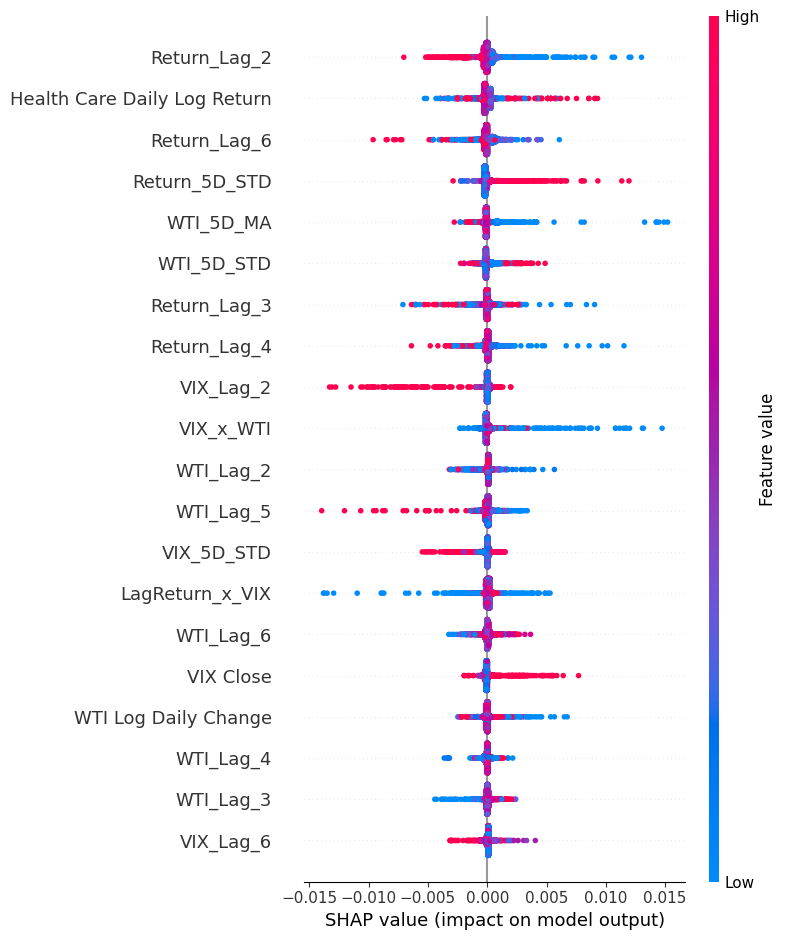

In [16]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.TreeExplainer(model)  # 'model' is your trained XGBoost model
shap_values = explainer.shap_values(X_train)  # 'X_train' is your feature DataFrame

# Create the SHAP Summary Plot (Beeswarm Plot with color coding by feature value)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, show=False)

# Add custom title to match thesis figure naming

plt.tight_layout()
plt.show()

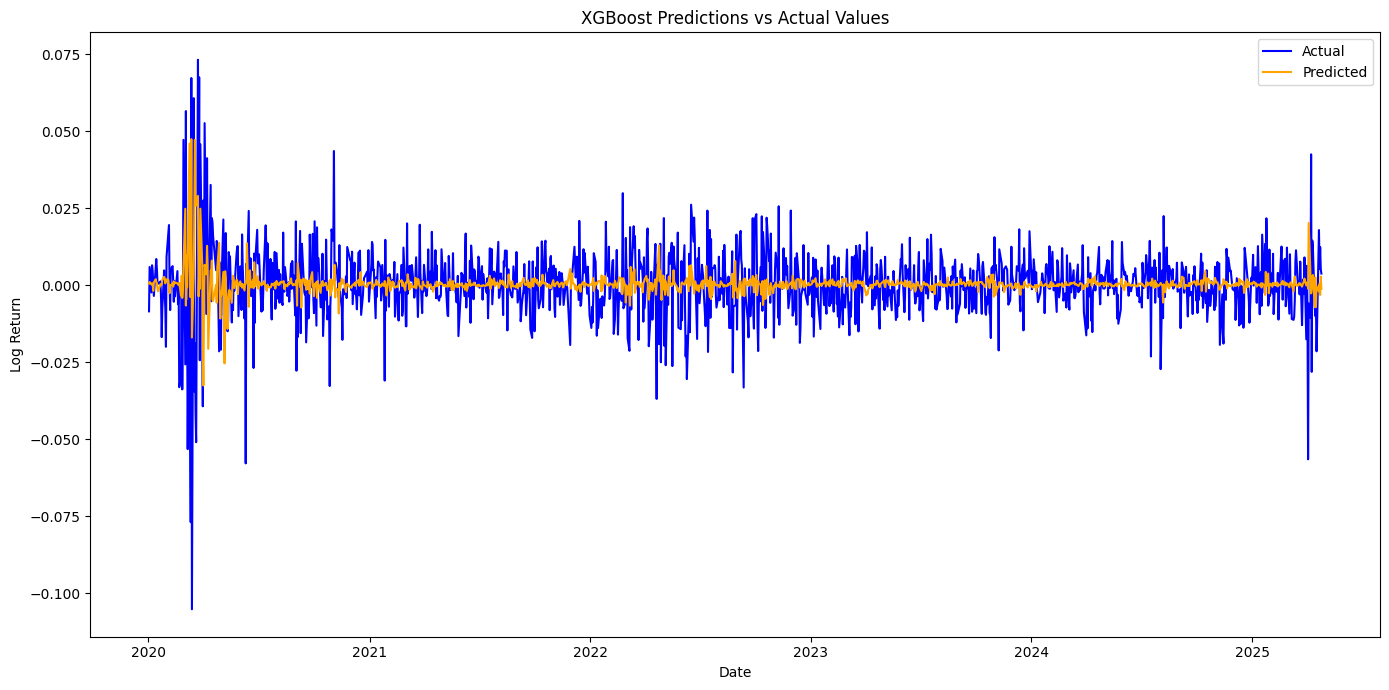

In [17]:
# Get date index from the original test set
test_index = test.index[-len(y_test):]

# Plotting the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test, label='Actual', color='blue')
plt.plot(test_index, y_pred, label='Predicted', color='orange')
plt.title("XGBoost Predictions vs Actual Values")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

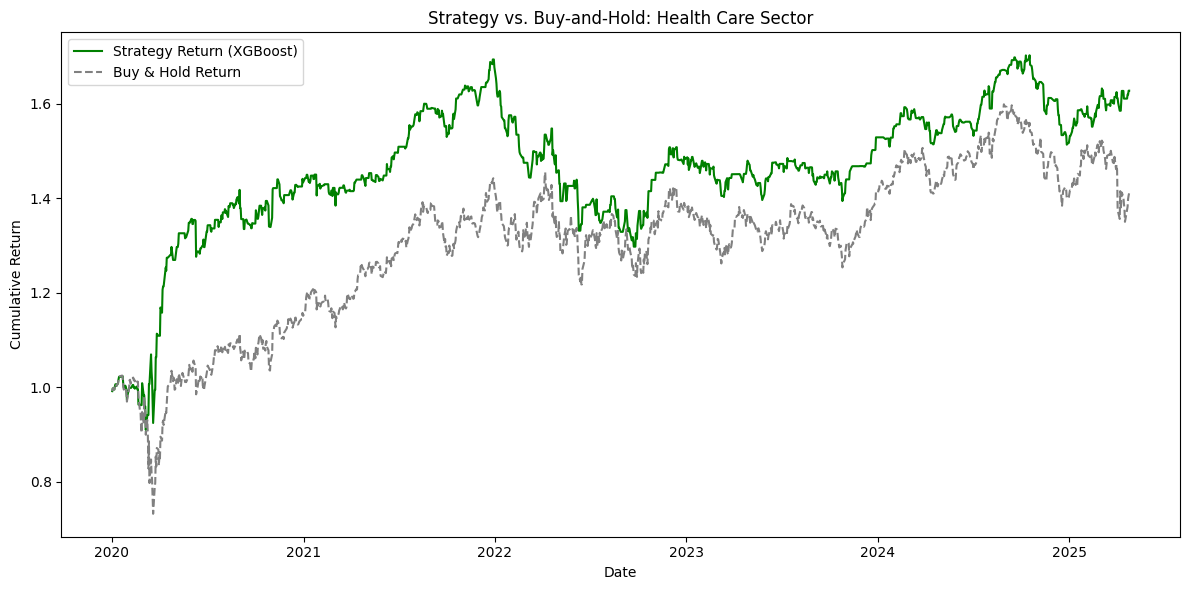

In [18]:
# ---------------------- STRATEGY SIMULATION ----------------------
#signal = np.where(y_pred > 0, 1, -1)
signal = np.where(y_pred > 0, 1, 0)  # Only buy when positive, otherwise stay out

strategy_returns = signal * y_test  # y_test is already a NumPy array

# Cumulative return using log returns -> exp of cumsum
cumulative_strategy = np.exp(np.cumsum(strategy_returns))
cumulative_bh = np.exp(np.cumsum(y_test))


plt.figure(figsize=(12, 6))
plt.plot(test_index, cumulative_strategy, label="Strategy Return (XGBoost)", color="green")
plt.plot(test_index, cumulative_bh, label="Buy & Hold Return", color="gray", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Strategy vs. Buy-and-Hold: Health Care Sector")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

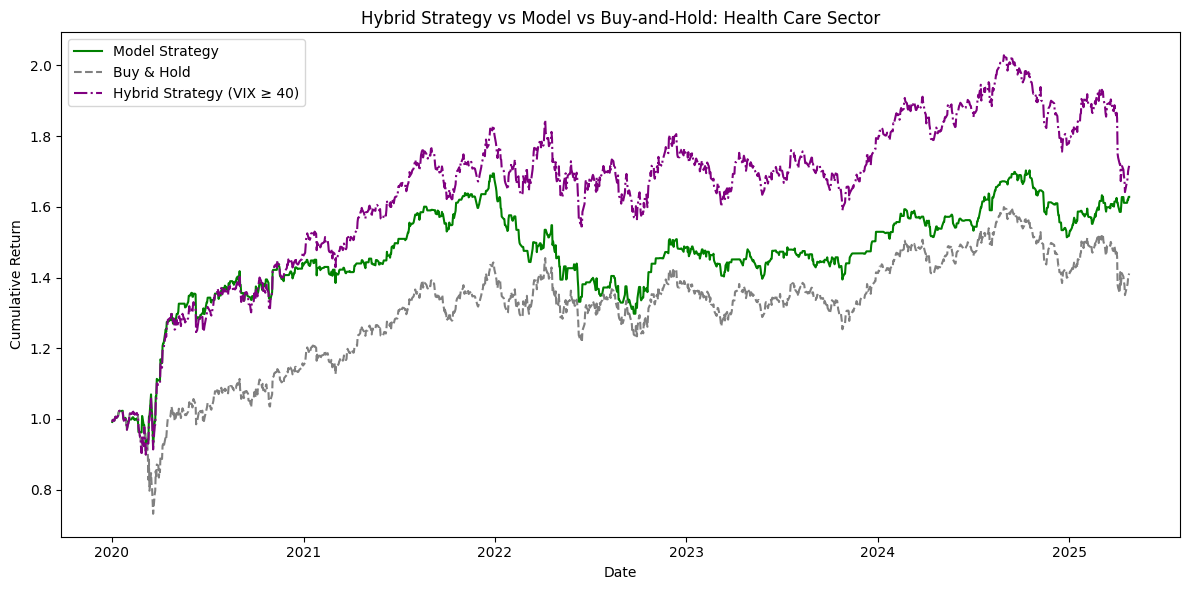

In [19]:
# ---------------------- HYBRID STRATEGY ----------------------

# Extract VIX values for the test period
vix_test = test["VIX Close"].values

# Hybrid strategy signal
hybrid_signal = np.where(vix_test >= 40, signal, 1)  # use model when VIX is high, otherwise hold

# Hybrid strategy returns
hybrid_returns = hybrid_signal * y_test

# Cumulative return using log returns
cumulative_hybrid = np.exp(np.cumsum(hybrid_returns))

# Plot all strategies
plt.figure(figsize=(12, 6))
plt.plot(test_index, cumulative_strategy, label="Model Strategy", color="green", linestyle="-")
plt.plot(test_index, cumulative_bh, label="Buy & Hold", color="gray", linestyle="--")
plt.plot(test_index, cumulative_hybrid, label="Hybrid Strategy (VIX ≥ 40)", color="purple", linestyle="-.")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Hybrid Strategy vs Model vs Buy-and-Hold: Health Care Sector")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [45]:
# Calculate average annual return and volatility
trading_days_per_year = 252
annualized_return_strategy = np.mean(strategy_returns) * trading_days_per_year
annualized_volatility_strategy = np.std(strategy_returns) * np.sqrt(trading_days_per_year)

annualizd_return_hybrid = np.mean(hybrid_returns) * trading_days_per_year
annualized_volatility_hybrid = np.std(hybrid_returns) * np.sqrt(trading_days_per_year)

annualized_return_bh = np.mean(y_test) * trading_days_per_year
annualized_volatility_bh = np.std(y_test) * np.sqrt(trading_days_per_year)

# total return
total_return_strategy = np.exp(np.sum(strategy_returns)) - 1
total_return_bh = np.exp(np.sum(y_test)) - 1
total_return_hybrid = np.exp(np.sum(hybrid_returns)) - 1

print("\nAnnualized Performance:")
print(f"Strategy - Return: {annualized_return_strategy:.4f}, Volatility: {annualized_volatility_strategy:.4f}")
print(f"Buy & Hold - Return: {annualized_return_bh:.4f}, Volatility: {annualized_volatility_bh:.4f}")
print(f"Hybrid Strategy - Return: {annualizd_return_hybrid:.4f}, Volatility: {annualized_volatility_hybrid:.4f}")
print("\nTotal Return:")
print(f"Strategy: {total_return_strategy:.4f}")
print(f"Buy & Hold: {total_return_bh:.4f}")
print(f"Hybrid Strategy: {total_return_hybrid:.4f}")


Annualized Performance:
Strategy - Return: 0.0925, Volatility: 0.1427
Buy & Hold - Return: 0.0654, Volatility: 0.1853
Hybrid Strategy - Return: 0.1025, Volatility: 0.1723

Total Return:
Strategy: 0.6281
Buy & Hold: 0.4113
Hybrid Strategy: 0.7159


In [270]:
# statistical significance testing between the three to determine whether the hybrid strategy is statistically significantly better than the buy and hold
from scipy.stats import ttest_rel
# Calculate daily returns
strategy_daily_returns = np.diff(np.log(cumulative_strategy))
bh_daily_returns = np.diff(np.log(cumulative_bh))
hybrid_daily_returns = np.diff(np.log(cumulative_hybrid))
# Perform paired t-tests
t_stat_strategy_bh, p_value_strategy_bh = ttest_rel(strategy_daily_returns, bh_daily_returns)
t_stat_hybrid_bh, p_value_hybrid_bh = ttest_rel(hybrid_daily_returns, bh_daily_returns)
t_stat_hybrid_strategy, p_value_hybrid_strategy = ttest_rel(hybrid_daily_returns, strategy_daily_returns)
print("\nStatistical Significance Testing:")
print(f"Strategy vs Buy & Hold: t-stat={t_stat_strategy_bh:.4f}, p-value={p_value_strategy_bh:.4f}")
print(f"Hybrid vs Buy & Hold: t-stat={t_stat_hybrid_bh:.4f}, p-value={p_value_hybrid_bh:.4f}")
print(f"Hybrid vs Strategy: t-stat={t_stat_hybrid_strategy:.4f}, p-value={p_value_hybrid_strategy:.4f}")


Statistical Significance Testing:
Strategy vs Buy & Hold: t-stat=0.9234, p-value=0.3560
Hybrid vs Buy & Hold: t-stat=0.0754, p-value=0.9399
Hybrid vs Strategy: t-stat=-1.1055, p-value=0.2691


In [124]:
# the data that goes from November 1st 2024 to the end, should be extracted from the dataset
#data_forecast_model_trump = data_forecast_model.loc['2024-11-01':]

# the data_forecast_model should stop at the end of October 2024
#data_forecast_model = data_forecast_model.loc[:'2024-10-31']

Consumer Discretionary

In [46]:
# define selected features

#selected_features = important_features.tolist()
selected_features = consumer_discretionary_features
target_column = 'Target'

In [47]:
selected_features

['Return_Lag_2',
 'VIX Close',
 'Return_Lag_3',
 'Return_Lag_4',
 'Return_Lag_6',
 'Return_Lag_5',
 'WTI_Lag_5',
 'VIX_5D_STD',
 'VIX_Lag_2',
 'VIX_Lag_6',
 'WTI_Lag_6',
 'WTI_Lag_3',
 'WTI_Lag_4',
 'WTI_Lag_2',
 'VIX_Lag_4',
 'Return_5D_STD',
 'WTI_5D_STD',
 'VIX_x_WTI',
 'WTI_5D_MA',
 'Consumer Discretionary Daily Log Return',
 'VIX_Lag_3',
 'LagReturn_x_VIX']

In [48]:
# === SPLIT: Train on recent, test on OOS ===
train_start = "2000-01-01"
train_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2025-04-30"

train = consumer_discretionary_df.loc[train_start:train_end]
test = consumer_discretionary_df.loc[test_start:test_end]

# ---------------------- SCALE INPUT FEATURES ----------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[selected_features])
test_scaled = scaler.transform(test[selected_features])

# Convert to DataFrame with correct index
train_scaled = pd.DataFrame(train_scaled, columns=selected_features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=selected_features, index=test.index)

# Add back target column
train_scaled[target_column] = train[target_column].values
test_scaled[target_column] = test[target_column].values

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

# ---------------------- SETTINGS ----------------------
sector_df = consumer_discretionary_df  # Change this for other sectors
selected_features = consumer_discretionary_features  # Update with the correct variable for selected features
target_column = 'Target'

# ---------------------- DATA SPLIT ----------------------
train_start = "2000-01-01"
train_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2025-04-30"

train = sector_df.loc[train_start:train_end]
test = sector_df.loc[test_start:test_end]

# ---------------------- SCALE FEATURES ----------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[selected_features])
test_scaled = scaler.transform(test[selected_features])

train_scaled = pd.DataFrame(train_scaled, columns=selected_features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=selected_features, index=test.index)

train_scaled[target_column] = train[target_column].values
test_scaled[target_column] = test[target_column].values

X_train, X_test = train_scaled[selected_features], test_scaled[selected_features]
y_train, y_test = train_scaled[target_column], test_scaled[target_column]

# ---------------------- OPTUNA HYPERPARAMETER TUNING ----------------------
ts_cv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 40),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }
    model = XGBRegressor(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, 
                             scoring='neg_root_mean_squared_error', 
                             cv=ts_cv)
    return -np.mean(scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

best_params = study.best_params
print("Best Hyperparameters:", best_params)



[I 2025-05-14 09:28:13,079] A new study created in memory with name: no-name-b9803cd5-d962-412d-b5a7-339e6e088263


Best trial: 0. Best value: 0.0118703:   1%|          | 1/100 [00:00<00:38,  2.55it/s]

[I 2025-05-14 09:28:13,470] Trial 0 finished with value: 0.011870300925349797 and parameters: {'n_estimators': 201, 'learning_rate': 0.2656711854881939, 'min_child_weight': 2, 'max_depth': 7, 'subsample': 0.7885028398566083, 'colsample_bytree': 0.9497957949076534, 'reg_alpha': 0.9756611705060316, 'reg_lambda': 0.9963911692210053}. Best is trial 0 with value: 0.011870300925349797.


Best trial: 0. Best value: 0.0118703:   2%|▏         | 2/100 [00:01<01:12,  1.34it/s]

[I 2025-05-14 09:28:14,459] Trial 1 finished with value: 0.012205877059353318 and parameters: {'n_estimators': 125, 'learning_rate': 0.14915326633910791, 'min_child_weight': 3, 'max_depth': 13, 'subsample': 0.8962536587632235, 'colsample_bytree': 0.629637875388453, 'reg_alpha': 0.26504883915822197, 'reg_lambda': 0.7350537345863999}. Best is trial 0 with value: 0.011870300925349797.


Best trial: 0. Best value: 0.0118703:   3%|▎         | 3/100 [00:01<01:02,  1.55it/s]

[I 2025-05-14 09:28:14,987] Trial 2 finished with value: 0.012726649292532727 and parameters: {'n_estimators': 127, 'learning_rate': 0.24018769794788583, 'min_child_weight': 6, 'max_depth': 4, 'subsample': 0.852584424347768, 'colsample_bytree': 0.9348757913685299, 'reg_alpha': 0.18980922462931582, 'reg_lambda': 0.5229390077853852}. Best is trial 0 with value: 0.011870300925349797.


Best trial: 0. Best value: 0.0118703:   4%|▍         | 4/100 [00:02<00:58,  1.64it/s]

[I 2025-05-14 09:28:15,542] Trial 3 finished with value: 0.011876087113506635 and parameters: {'n_estimators': 224, 'learning_rate': 0.2308618785042063, 'min_child_weight': 5, 'max_depth': 38, 'subsample': 0.9220935767069484, 'colsample_bytree': 0.7290434567214339, 'reg_alpha': 0.8726801339721912, 'reg_lambda': 0.8518935548113407}. Best is trial 0 with value: 0.011870300925349797.


Best trial: 0. Best value: 0.0118703:   5%|▌         | 5/100 [00:03<01:25,  1.11it/s]

[I 2025-05-14 09:28:16,967] Trial 4 finished with value: 0.014220660532852753 and parameters: {'n_estimators': 270, 'learning_rate': 0.27154978126941987, 'min_child_weight': 6, 'max_depth': 7, 'subsample': 0.753945275338553, 'colsample_bytree': 0.8091157836036621, 'reg_alpha': 0.004120240792411689, 'reg_lambda': 0.8430486836020794}. Best is trial 0 with value: 0.011870300925349797.


Best trial: 0. Best value: 0.0118703:   6%|▌         | 6/100 [00:07<02:50,  1.82s/it]

[I 2025-05-14 09:28:20,562] Trial 5 finished with value: 0.013636535023537372 and parameters: {'n_estimators': 286, 'learning_rate': 0.20736857391017965, 'min_child_weight': 10, 'max_depth': 31, 'subsample': 0.7474890993465344, 'colsample_bytree': 0.9590031003150791, 'reg_alpha': 0.014464709925288588, 'reg_lambda': 0.0726991657853916}. Best is trial 0 with value: 0.011870300925349797.


Best trial: 0. Best value: 0.0118703:   7%|▋         | 7/100 [00:08<02:14,  1.45s/it]

[I 2025-05-14 09:28:21,240] Trial 6 finished with value: 0.011989470244510112 and parameters: {'n_estimators': 164, 'learning_rate': 0.26740047012394175, 'min_child_weight': 2, 'max_depth': 26, 'subsample': 0.9524766723248783, 'colsample_bytree': 0.6593203608294976, 'reg_alpha': 0.612216811288156, 'reg_lambda': 0.28400246253586947}. Best is trial 0 with value: 0.011870300925349797.


Best trial: 7. Best value: 0.011859:   8%|▊         | 8/100 [00:08<01:53,  1.23s/it] 

[I 2025-05-14 09:28:22,020] Trial 7 finished with value: 0.011858958335009454 and parameters: {'n_estimators': 270, 'learning_rate': 0.11272670271732224, 'min_child_weight': 5, 'max_depth': 22, 'subsample': 0.969476473825077, 'colsample_bytree': 0.7075278825256068, 'reg_alpha': 0.7216763479491287, 'reg_lambda': 0.3007424222064595}. Best is trial 7 with value: 0.011858958335009454.


Best trial: 7. Best value: 0.011859:   9%|▉         | 9/100 [00:10<02:02,  1.35s/it]

[I 2025-05-14 09:28:23,610] Trial 8 finished with value: 0.01209700045489567 and parameters: {'n_estimators': 261, 'learning_rate': 0.1660513253493254, 'min_child_weight': 3, 'max_depth': 32, 'subsample': 0.6116080655252166, 'colsample_bytree': 0.7283068788155495, 'reg_alpha': 0.5631640737551581, 'reg_lambda': 0.46460837239317676}. Best is trial 7 with value: 0.011858958335009454.


Best trial: 7. Best value: 0.011859:  10%|█         | 10/100 [00:11<01:52,  1.25s/it]

[I 2025-05-14 09:28:24,660] Trial 9 finished with value: 0.012332366231389403 and parameters: {'n_estimators': 147, 'learning_rate': 0.2887696138515573, 'min_child_weight': 7, 'max_depth': 24, 'subsample': 0.90166334208892, 'colsample_bytree': 0.784704158247788, 'reg_alpha': 0.3774268502840832, 'reg_lambda': 0.37487977216172685}. Best is trial 7 with value: 0.011858958335009454.


Best trial: 10. Best value: 0.0118454:  11%|█         | 11/100 [00:12<01:32,  1.04s/it]

[I 2025-05-14 09:28:25,209] Trial 10 finished with value: 0.011845422231831245 and parameters: {'n_estimators': 232, 'learning_rate': 0.10111828208603729, 'min_child_weight': 9, 'max_depth': 17, 'subsample': 0.9985206942953443, 'colsample_bytree': 0.8455069924750189, 'reg_alpha': 0.7027577714422375, 'reg_lambda': 0.0564148729880094}. Best is trial 10 with value: 0.011845422231831245.


Best trial: 11. Best value: 0.0118357:  12%|█▏        | 12/100 [00:12<01:18,  1.12it/s]

[I 2025-05-14 09:28:25,779] Trial 11 finished with value: 0.011835719512258683 and parameters: {'n_estimators': 238, 'learning_rate': 0.10050198768877525, 'min_child_weight': 9, 'max_depth': 17, 'subsample': 0.9980203319668413, 'colsample_bytree': 0.8360332215722999, 'reg_alpha': 0.7562136957435751, 'reg_lambda': 0.006562347637916036}. Best is trial 11 with value: 0.011835719512258683.


Best trial: 12. Best value: 0.0118255:  13%|█▎        | 13/100 [00:13<01:08,  1.28it/s]

[I 2025-05-14 09:28:26,297] Trial 12 finished with value: 0.0118255241216664 and parameters: {'n_estimators': 230, 'learning_rate': 0.10129263785753266, 'min_child_weight': 10, 'max_depth': 15, 'subsample': 0.9936655358476186, 'colsample_bytree': 0.8649598810396288, 'reg_alpha': 0.7678534142964286, 'reg_lambda': 0.03290722010095194}. Best is trial 12 with value: 0.0118255241216664.


Best trial: 12. Best value: 0.0118255:  14%|█▍        | 14/100 [00:14<01:07,  1.27it/s]

[I 2025-05-14 09:28:27,089] Trial 13 finished with value: 0.011944549227144309 and parameters: {'n_estimators': 232, 'learning_rate': 0.14023059726561843, 'min_child_weight': 8, 'max_depth': 15, 'subsample': 0.8586392601042905, 'colsample_bytree': 0.8729840751792851, 'reg_alpha': 0.7792631096772527, 'reg_lambda': 0.15947905839914733}. Best is trial 12 with value: 0.0118255241216664.


Best trial: 12. Best value: 0.0118255:  15%|█▌        | 15/100 [00:15<01:18,  1.09it/s]

[I 2025-05-14 09:28:28,323] Trial 14 finished with value: 0.012173583479882793 and parameters: {'n_estimators': 190, 'learning_rate': 0.1274691063641893, 'min_child_weight': 10, 'max_depth': 12, 'subsample': 0.6512337561887978, 'colsample_bytree': 0.880565416032172, 'reg_alpha': 0.4629957379863941, 'reg_lambda': 0.002754633680891235}. Best is trial 12 with value: 0.0118255241216664.


Best trial: 15. Best value: 0.0118123:  16%|█▌        | 16/100 [00:15<01:05,  1.29it/s]

[I 2025-05-14 09:28:28,768] Trial 15 finished with value: 0.011812264160480684 and parameters: {'n_estimators': 193, 'learning_rate': 0.17393851169016009, 'min_child_weight': 8, 'max_depth': 19, 'subsample': 0.9958822298127032, 'colsample_bytree': 0.793279929818688, 'reg_alpha': 0.8784443988118439, 'reg_lambda': 0.2076905857864919}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  17%|█▋        | 17/100 [00:16<00:58,  1.42it/s]

[I 2025-05-14 09:28:29,296] Trial 16 finished with value: 0.011841377404611938 and parameters: {'n_estimators': 188, 'learning_rate': 0.1813427010955921, 'min_child_weight': 8, 'max_depth': 19, 'subsample': 0.8470981993710793, 'colsample_bytree': 0.7689766115311873, 'reg_alpha': 0.9945769133512953, 'reg_lambda': 0.19222587412060405}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  18%|█▊        | 18/100 [00:17<00:59,  1.37it/s]

[I 2025-05-14 09:28:30,087] Trial 17 finished with value: 0.011948104669555771 and parameters: {'n_estimators': 207, 'learning_rate': 0.19877180848345133, 'min_child_weight': 8, 'max_depth': 29, 'subsample': 0.9425157747793866, 'colsample_bytree': 0.9167017751557103, 'reg_alpha': 0.6332134284845203, 'reg_lambda': 0.17228717043049802}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  19%|█▉        | 19/100 [00:17<00:53,  1.52it/s]

[I 2025-05-14 09:28:30,585] Trial 18 finished with value: 0.011871383686788996 and parameters: {'n_estimators': 103, 'learning_rate': 0.16221715819572458, 'min_child_weight': 10, 'max_depth': 10, 'subsample': 0.7010948390061852, 'colsample_bytree': 0.9986840993291601, 'reg_alpha': 0.8726015731287114, 'reg_lambda': 0.5864434383205597}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  20%|██        | 20/100 [00:18<00:54,  1.46it/s]

[I 2025-05-14 09:28:31,334] Trial 19 finished with value: 0.011855966067826126 and parameters: {'n_estimators': 168, 'learning_rate': 0.12861973970083476, 'min_child_weight': 7, 'max_depth': 21, 'subsample': 0.8819724889535822, 'colsample_bytree': 0.8911812377884882, 'reg_alpha': 0.8583247724033113, 'reg_lambda': 0.30170359244510864}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  21%|██        | 21/100 [00:19<01:13,  1.07it/s]

[I 2025-05-14 09:28:32,840] Trial 20 finished with value: 0.012277224172078802 and parameters: {'n_estimators': 250, 'learning_rate': 0.1901359522220264, 'min_child_weight': 9, 'max_depth': 36, 'subsample': 0.8128665573157146, 'colsample_bytree': 0.8230780852424576, 'reg_alpha': 0.47109419246509254, 'reg_lambda': 0.1325193911400085}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  22%|██▏       | 22/100 [00:20<01:03,  1.22it/s]

[I 2025-05-14 09:28:33,399] Trial 21 finished with value: 0.011820177965517969 and parameters: {'n_estimators': 218, 'learning_rate': 0.10037812218616288, 'min_child_weight': 9, 'max_depth': 18, 'subsample': 0.9978783883419481, 'colsample_bytree': 0.8459057314920986, 'reg_alpha': 0.7873371163758629, 'reg_lambda': 0.004589317604525522}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  23%|██▎       | 23/100 [00:20<00:56,  1.35it/s]

[I 2025-05-14 09:28:33,950] Trial 22 finished with value: 0.011829454022779774 and parameters: {'n_estimators': 215, 'learning_rate': 0.12307402541903244, 'min_child_weight': 9, 'max_depth': 19, 'subsample': 0.978702173422495, 'colsample_bytree': 0.7757992269952452, 'reg_alpha': 0.8293968900356286, 'reg_lambda': 0.23847455108797133}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  24%|██▍       | 24/100 [00:21<00:52,  1.46it/s]

[I 2025-05-14 09:28:34,509] Trial 23 finished with value: 0.01181977056555307 and parameters: {'n_estimators': 180, 'learning_rate': 0.14552013631512795, 'min_child_weight': 7, 'max_depth': 26, 'subsample': 0.9360322757125754, 'colsample_bytree': 0.8567965963244797, 'reg_alpha': 0.9348178849073168, 'reg_lambda': 0.10836199856172277}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  25%|██▌       | 25/100 [00:21<00:46,  1.60it/s]

[I 2025-05-14 09:28:34,992] Trial 24 finished with value: 0.011820422922357549 and parameters: {'n_estimators': 177, 'learning_rate': 0.16698821420050228, 'min_child_weight': 7, 'max_depth': 26, 'subsample': 0.9407990169681267, 'colsample_bytree': 0.7512556799535517, 'reg_alpha': 0.9224061476001201, 'reg_lambda': 0.4008976034518744}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  26%|██▌       | 26/100 [00:22<00:42,  1.75it/s]

[I 2025-05-14 09:28:35,442] Trial 25 finished with value: 0.011824233742458177 and parameters: {'n_estimators': 148, 'learning_rate': 0.14387690439264664, 'min_child_weight': 8, 'max_depth': 27, 'subsample': 0.9227878025771747, 'colsample_bytree': 0.8040148269752311, 'reg_alpha': 0.9346498927804852, 'reg_lambda': 0.10973539395131071}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  27%|██▋       | 27/100 [00:22<00:42,  1.70it/s]

[I 2025-05-14 09:28:36,068] Trial 26 finished with value: 0.011933436058581676 and parameters: {'n_estimators': 191, 'learning_rate': 0.21143568531832257, 'min_child_weight': 6, 'max_depth': 22, 'subsample': 0.9605176781951138, 'colsample_bytree': 0.9095772572957428, 'reg_alpha': 0.6786210775475061, 'reg_lambda': 0.23736868493700294}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  28%|██▊       | 28/100 [00:23<00:43,  1.65it/s]

[I 2025-05-14 09:28:36,720] Trial 27 finished with value: 0.011895919708803368 and parameters: {'n_estimators': 213, 'learning_rate': 0.17812505591676817, 'min_child_weight': 4, 'max_depth': 34, 'subsample': 0.9175092398059013, 'colsample_bytree': 0.6850803614806253, 'reg_alpha': 0.8057643560166317, 'reg_lambda': 0.11187065901909458}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  29%|██▉       | 29/100 [00:24<00:39,  1.80it/s]

[I 2025-05-14 09:28:37,156] Trial 28 finished with value: 0.011816149211717673 and parameters: {'n_estimators': 156, 'learning_rate': 0.1539648476576613, 'min_child_weight': 7, 'max_depth': 24, 'subsample': 0.9585693499674562, 'colsample_bytree': 0.8409366950725563, 'reg_alpha': 0.9194169706639947, 'reg_lambda': 0.36267877157300105}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  30%|███       | 30/100 [00:24<00:39,  1.79it/s]

[I 2025-05-14 09:28:37,718] Trial 29 finished with value: 0.01186875290126579 and parameters: {'n_estimators': 151, 'learning_rate': 0.15412842944070562, 'min_child_weight': 7, 'max_depth': 29, 'subsample': 0.7881574477317106, 'colsample_bytree': 0.9548962047820821, 'reg_alpha': 0.9510025189271478, 'reg_lambda': 0.3894409611746492}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  31%|███       | 31/100 [00:25<00:37,  1.86it/s]

[I 2025-05-14 09:28:38,210] Trial 30 finished with value: 0.011836226615358256 and parameters: {'n_estimators': 135, 'learning_rate': 0.13449137967913843, 'min_child_weight': 1, 'max_depth': 24, 'subsample': 0.8717638411870018, 'colsample_bytree': 0.7516444102318416, 'reg_alpha': 0.9798679156886356, 'reg_lambda': 0.5849772823839903}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  32%|███▏      | 32/100 [00:25<00:35,  1.90it/s]

[I 2025-05-14 09:28:38,712] Trial 31 finished with value: 0.011816143258480048 and parameters: {'n_estimators': 200, 'learning_rate': 0.11609459929270967, 'min_child_weight': 8, 'max_depth': 20, 'subsample': 0.9652101923132896, 'colsample_bytree': 0.8509381821852307, 'reg_alpha': 0.8949181487054184, 'reg_lambda': 0.22992243252728692}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  33%|███▎      | 33/100 [00:26<00:34,  1.96it/s]

[I 2025-05-14 09:28:39,185] Trial 32 finished with value: 0.011816966066029897 and parameters: {'n_estimators': 198, 'learning_rate': 0.1503633436488407, 'min_child_weight': 7, 'max_depth': 24, 'subsample': 0.9652851109618028, 'colsample_bytree': 0.8550984006393805, 'reg_alpha': 0.8951490472725903, 'reg_lambda': 0.33621815543794853}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  34%|███▍      | 34/100 [00:26<00:32,  2.01it/s]

[I 2025-05-14 09:28:39,653] Trial 33 finished with value: 0.011821961656978337 and parameters: {'n_estimators': 201, 'learning_rate': 0.15733736785002472, 'min_child_weight': 6, 'max_depth': 21, 'subsample': 0.9676313803899681, 'colsample_bytree': 0.6062272885819622, 'reg_alpha': 0.8839382790397027, 'reg_lambda': 0.45752461921137655}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  35%|███▌      | 35/100 [00:27<00:32,  2.01it/s]

[I 2025-05-14 09:28:40,153] Trial 34 finished with value: 0.011839377649024613 and parameters: {'n_estimators': 165, 'learning_rate': 0.11705613436618063, 'min_child_weight': 8, 'max_depth': 23, 'subsample': 0.9054964053403383, 'colsample_bytree': 0.8204409628697121, 'reg_alpha': 0.899024667691359, 'reg_lambda': 0.3465833101334168}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  36%|███▌      | 36/100 [00:27<00:32,  1.96it/s]

[I 2025-05-14 09:28:40,686] Trial 35 finished with value: 0.011883688007472307 and parameters: {'n_estimators': 113, 'learning_rate': 0.1732566711612644, 'min_child_weight': 5, 'max_depth': 14, 'subsample': 0.827890122079894, 'colsample_bytree': 0.7933294220847967, 'reg_alpha': 0.8299634137511136, 'reg_lambda': 0.5289404183312917}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  37%|███▋      | 37/100 [00:29<00:55,  1.14it/s]

[I 2025-05-14 09:28:42,428] Trial 36 finished with value: 0.012676921374825716 and parameters: {'n_estimators': 199, 'learning_rate': 0.1881952833065947, 'min_child_weight': 6, 'max_depth': 10, 'subsample': 0.9742700950351204, 'colsample_bytree': 0.8965322080386029, 'reg_alpha': 0.11048401605390634, 'reg_lambda': 0.23700006297059611}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  38%|███▊      | 38/100 [00:29<00:49,  1.25it/s]

[I 2025-05-14 09:28:43,034] Trial 37 finished with value: 0.01229034468404808 and parameters: {'n_estimators': 177, 'learning_rate': 0.22393618401187004, 'min_child_weight': 7, 'max_depth': 3, 'subsample': 0.9490204251353097, 'colsample_bytree': 0.826401246272592, 'reg_alpha': 0.3843834279815745, 'reg_lambda': 0.9502331494603757}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  39%|███▉      | 39/100 [00:30<00:43,  1.42it/s]

[I 2025-05-14 09:28:43,528] Trial 38 finished with value: 0.011818005138816314 and parameters: {'n_estimators': 137, 'learning_rate': 0.14865154937893216, 'min_child_weight': 8, 'max_depth': 40, 'subsample': 0.8821184034439402, 'colsample_bytree': 0.8073033328544631, 'reg_alpha': 0.993014747368425, 'reg_lambda': 0.44514909003984166}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  40%|████      | 40/100 [00:31<00:44,  1.35it/s]

[I 2025-05-14 09:28:44,349] Trial 39 finished with value: 0.011999264966754044 and parameters: {'n_estimators': 245, 'learning_rate': 0.25362251665472224, 'min_child_weight': 5, 'max_depth': 20, 'subsample': 0.9272574288484708, 'colsample_bytree': 0.9205704816696063, 'reg_alpha': 0.6500031616574826, 'reg_lambda': 0.3470666566657464}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  41%|████      | 41/100 [00:31<00:39,  1.49it/s]

[I 2025-05-14 09:28:44,864] Trial 40 finished with value: 0.011850083121966486 and parameters: {'n_estimators': 159, 'learning_rate': 0.1382062257398013, 'min_child_weight': 6, 'max_depth': 24, 'subsample': 0.9775022786762845, 'colsample_bytree': 0.7548576186897203, 'reg_alpha': 0.7260154349116626, 'reg_lambda': 0.7321475666138422}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  42%|████▏     | 42/100 [00:32<00:34,  1.67it/s]

[I 2025-05-14 09:28:45,286] Trial 41 finished with value: 0.011829212336133519 and parameters: {'n_estimators': 136, 'learning_rate': 0.1521937474154753, 'min_child_weight': 8, 'max_depth': 37, 'subsample': 0.899276197481249, 'colsample_bytree': 0.7946027881610652, 'reg_alpha': 0.9719276559067028, 'reg_lambda': 0.4334071346110483}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  43%|████▎     | 43/100 [00:32<00:30,  1.86it/s]

[I 2025-05-14 09:28:45,683] Trial 42 finished with value: 0.01182532404025474 and parameters: {'n_estimators': 117, 'learning_rate': 0.17136542909663924, 'min_child_weight': 8, 'max_depth': 39, 'subsample': 0.9515524886956971, 'colsample_bytree': 0.8112969647756492, 'reg_alpha': 0.8490022527987933, 'reg_lambda': 0.5069189153951315}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  44%|████▍     | 44/100 [00:33<00:29,  1.89it/s]

[I 2025-05-14 09:28:46,194] Trial 43 finished with value: 0.011831856541499508 and parameters: {'n_estimators': 133, 'learning_rate': 0.11327823814249963, 'min_child_weight': 7, 'max_depth': 33, 'subsample': 0.8810469692941465, 'colsample_bytree': 0.8603007272777045, 'reg_alpha': 0.900682355493418, 'reg_lambda': 0.29272470360207614}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  45%|████▌     | 45/100 [00:33<00:27,  1.99it/s]

[I 2025-05-14 09:28:46,636] Trial 44 finished with value: 0.011819504522619397 and parameters: {'n_estimators': 154, 'learning_rate': 0.1500847547082476, 'min_child_weight': 9, 'max_depth': 40, 'subsample': 0.9128280688002317, 'colsample_bytree': 0.8429057069128285, 'reg_alpha': 0.9980979930118631, 'reg_lambda': 0.33090839954283435}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  46%|████▌     | 46/100 [00:34<00:26,  2.02it/s]

[I 2025-05-14 09:28:47,115] Trial 45 finished with value: 0.011930792109054525 and parameters: {'n_estimators': 196, 'learning_rate': 0.15967822229159634, 'min_child_weight': 7, 'max_depth': 6, 'subsample': 0.9852014297084541, 'colsample_bytree': 0.7260453495333609, 'reg_alpha': 0.5830938295629742, 'reg_lambda': 0.21105362828621832}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  47%|████▋     | 47/100 [00:34<00:26,  1.97it/s]

[I 2025-05-14 09:28:47,653] Trial 46 finished with value: 0.011845491716489145 and parameters: {'n_estimators': 173, 'learning_rate': 0.13120846452305673, 'min_child_weight': 8, 'max_depth': 16, 'subsample': 0.9610411117805695, 'colsample_bytree': 0.9370226732209709, 'reg_alpha': 0.7379306494792726, 'reg_lambda': 0.5714255286629099}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  48%|████▊     | 48/100 [00:35<00:27,  1.91it/s]

[I 2025-05-14 09:28:48,211] Trial 47 finished with value: 0.011841287105632595 and parameters: {'n_estimators': 183, 'learning_rate': 0.12127821391189139, 'min_child_weight': 9, 'max_depth': 30, 'subsample': 0.8430850587226462, 'colsample_bytree': 0.878712741634515, 'reg_alpha': 0.9355451866201155, 'reg_lambda': 0.39618611097183615}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  49%|████▉     | 49/100 [00:36<00:36,  1.38it/s]

[I 2025-05-14 09:28:49,406] Trial 48 finished with value: 0.012425048707353703 and parameters: {'n_estimators': 141, 'learning_rate': 0.19085990670494077, 'min_child_weight': 4, 'max_depth': 12, 'subsample': 0.742072335340249, 'colsample_bytree': 0.8120359597348931, 'reg_alpha': 0.3078317746011738, 'reg_lambda': 0.2715779339760882}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  50%|█████     | 50/100 [00:36<00:33,  1.47it/s]

[I 2025-05-14 09:28:49,976] Trial 49 finished with value: 0.011905705818031078 and parameters: {'n_estimators': 207, 'learning_rate': 0.29475082618635406, 'min_child_weight': 6, 'max_depth': 28, 'subsample': 0.9306517242131653, 'colsample_bytree': 0.7712617602234968, 'reg_alpha': 0.8110918858682391, 'reg_lambda': 0.6679975513518426}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  51%|█████     | 51/100 [00:37<00:35,  1.36it/s]

[I 2025-05-14 09:28:50,840] Trial 50 finished with value: 0.01184923433579409 and parameters: {'n_estimators': 291, 'learning_rate': 0.10973989249276077, 'min_child_weight': 8, 'max_depth': 24, 'subsample': 0.8905630434929999, 'colsample_bytree': 0.8331905490017109, 'reg_alpha': 0.8839975939548901, 'reg_lambda': 0.43894151372818757}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 15. Best value: 0.0118123:  52%|█████▏    | 52/100 [00:38<00:31,  1.53it/s]

[I 2025-05-14 09:28:51,306] Trial 51 finished with value: 0.011814877030069228 and parameters: {'n_estimators': 153, 'learning_rate': 0.14953004333631129, 'min_child_weight': 9, 'max_depth': 40, 'subsample': 0.9126946517679299, 'colsample_bytree': 0.8544279291985473, 'reg_alpha': 0.9976833409760559, 'reg_lambda': 0.3404841528999224}. Best is trial 15 with value: 0.011812264160480684.


Best trial: 52. Best value: 0.0118045:  53%|█████▎    | 53/100 [00:38<00:26,  1.76it/s]

[I 2025-05-14 09:28:51,669] Trial 52 finished with value: 0.011804529209303891 and parameters: {'n_estimators': 126, 'learning_rate': 0.14158068403973745, 'min_child_weight': 10, 'max_depth': 35, 'subsample': 0.9840238649963924, 'colsample_bytree': 0.8552011095018365, 'reg_alpha': 0.952839538574576, 'reg_lambda': 0.34357894720055265}. Best is trial 52 with value: 0.011804529209303891.


Best trial: 52. Best value: 0.0118045:  54%|█████▍    | 54/100 [00:38<00:23,  1.98it/s]

[I 2025-05-14 09:28:52,031] Trial 53 finished with value: 0.011808969576441803 and parameters: {'n_estimators': 125, 'learning_rate': 0.1634938519656274, 'min_child_weight': 9, 'max_depth': 36, 'subsample': 0.9842214653946326, 'colsample_bytree': 0.8649765543774388, 'reg_alpha': 0.9541287371488935, 'reg_lambda': 0.3188299041894166}. Best is trial 52 with value: 0.011804529209303891.


Best trial: 52. Best value: 0.0118045:  55%|█████▌    | 55/100 [00:39<00:20,  2.22it/s]

[I 2025-05-14 09:28:52,354] Trial 54 finished with value: 0.011806052860631038 and parameters: {'n_estimators': 125, 'learning_rate': 0.17993578960158585, 'min_child_weight': 10, 'max_depth': 34, 'subsample': 0.9832327512790588, 'colsample_bytree': 0.8936941721067471, 'reg_alpha': 0.9592643475132823, 'reg_lambda': 0.2509753124993304}. Best is trial 52 with value: 0.011804529209303891.


Best trial: 52. Best value: 0.0118045:  56%|█████▌    | 56/100 [00:39<00:18,  2.43it/s]

[I 2025-05-14 09:28:52,674] Trial 55 finished with value: 0.011809715078685336 and parameters: {'n_estimators': 124, 'learning_rate': 0.1813993435631152, 'min_child_weight': 10, 'max_depth': 35, 'subsample': 0.9996671396278544, 'colsample_bytree': 0.8939968949115693, 'reg_alpha': 0.9458177790617999, 'reg_lambda': 0.164358014660093}. Best is trial 52 with value: 0.011804529209303891.


Best trial: 56. Best value: 0.0118023:  57%|█████▋    | 57/100 [00:40<00:17,  2.44it/s]

[I 2025-05-14 09:28:53,080] Trial 56 finished with value: 0.011802320179634484 and parameters: {'n_estimators': 124, 'learning_rate': 0.20169982318987048, 'min_child_weight': 10, 'max_depth': 35, 'subsample': 0.9989388362002154, 'colsample_bytree': 0.8937916495257762, 'reg_alpha': 0.9573759265110777, 'reg_lambda': 0.16497892889295407}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  58%|█████▊    | 58/100 [00:40<00:16,  2.55it/s]

[I 2025-05-14 09:28:53,431] Trial 57 finished with value: 0.011806249378683766 and parameters: {'n_estimators': 124, 'learning_rate': 0.20074496769074404, 'min_child_weight': 10, 'max_depth': 36, 'subsample': 0.988616388347344, 'colsample_bytree': 0.9731019957888963, 'reg_alpha': 0.9489811051525114, 'reg_lambda': 0.07388241064945236}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  59%|█████▉    | 59/100 [00:40<00:15,  2.57it/s]

[I 2025-05-14 09:28:53,811] Trial 58 finished with value: 0.011814987003437862 and parameters: {'n_estimators': 122, 'learning_rate': 0.2104520266370471, 'min_child_weight': 10, 'max_depth': 35, 'subsample': 0.9866460194419256, 'colsample_bytree': 0.9753223291249258, 'reg_alpha': 0.9540048272778537, 'reg_lambda': 0.15082676441925238}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  60%|██████    | 60/100 [00:41<00:15,  2.66it/s]

[I 2025-05-14 09:28:54,157] Trial 59 finished with value: 0.011814968325668243 and parameters: {'n_estimators': 104, 'learning_rate': 0.20210474743539292, 'min_child_weight': 10, 'max_depth': 32, 'subsample': 0.9999620318515987, 'colsample_bytree': 0.9351833902192772, 'reg_alpha': 0.850620745480055, 'reg_lambda': 0.07308741387973411}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  61%|██████    | 61/100 [00:41<00:15,  2.59it/s]

[I 2025-05-14 09:28:54,564] Trial 60 finished with value: 0.01181458095019222 and parameters: {'n_estimators': 126, 'learning_rate': 0.22187284477909905, 'min_child_weight': 10, 'max_depth': 37, 'subsample': 0.9843930636929569, 'colsample_bytree': 0.9946953521091066, 'reg_alpha': 0.9588809958832718, 'reg_lambda': 0.05838111146589231}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  62%|██████▏   | 62/100 [00:41<00:14,  2.66it/s]

[I 2025-05-14 09:28:54,918] Trial 61 finished with value: 0.011810017097404263 and parameters: {'n_estimators': 109, 'learning_rate': 0.18497752998378275, 'min_child_weight': 10, 'max_depth': 35, 'subsample': 0.9997264606753383, 'colsample_bytree': 0.8991453084477551, 'reg_alpha': 0.9525543854068607, 'reg_lambda': 0.18989244954092815}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  63%|██████▎   | 63/100 [00:42<00:14,  2.61it/s]

[I 2025-05-14 09:28:55,316] Trial 62 finished with value: 0.011816831201596937 and parameters: {'n_estimators': 110, 'learning_rate': 0.18486164011224193, 'min_child_weight': 10, 'max_depth': 35, 'subsample': 0.9780941217447404, 'colsample_bytree': 0.8975117347957525, 'reg_alpha': 0.9585842451868978, 'reg_lambda': 0.26945172459864464}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  64%|██████▍   | 64/100 [00:42<00:13,  2.59it/s]

[I 2025-05-14 09:28:55,713] Trial 63 finished with value: 0.01180543723879352 and parameters: {'n_estimators': 121, 'learning_rate': 0.19543796767783442, 'min_child_weight': 10, 'max_depth': 38, 'subsample': 0.999513374680568, 'colsample_bytree': 0.8854500039420519, 'reg_alpha': 0.9302710453388701, 'reg_lambda': 0.19380981510307563}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  65%|██████▌   | 65/100 [00:43<00:14,  2.34it/s]

[I 2025-05-14 09:28:56,233] Trial 64 finished with value: 0.011830601736334908 and parameters: {'n_estimators': 120, 'learning_rate': 0.1959668918135371, 'min_child_weight': 10, 'max_depth': 38, 'subsample': 0.9378885113500421, 'colsample_bytree': 0.8736040127321613, 'reg_alpha': 0.9230029361790507, 'reg_lambda': 0.1675593044241864}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  66%|██████▌   | 66/100 [00:43<00:14,  2.27it/s]

[I 2025-05-14 09:28:56,703] Trial 65 finished with value: 0.011846516470804314 and parameters: {'n_estimators': 129, 'learning_rate': 0.20478712812362673, 'min_child_weight': 10, 'max_depth': 33, 'subsample': 0.984430090243802, 'colsample_bytree': 0.9222712646470729, 'reg_alpha': 0.7747436897086458, 'reg_lambda': 0.08836743432313723}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  67%|██████▋   | 67/100 [00:44<00:14,  2.24it/s]

[I 2025-05-14 09:28:57,168] Trial 66 finished with value: 0.011855300585707456 and parameters: {'n_estimators': 101, 'learning_rate': 0.2147696520795864, 'min_child_weight': 9, 'max_depth': 37, 'subsample': 0.9507519703202593, 'colsample_bytree': 0.8846357822550824, 'reg_alpha': 0.8399440702037756, 'reg_lambda': 0.19242309447811737}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  68%|██████▊   | 68/100 [00:44<00:13,  2.35it/s]

[I 2025-05-14 09:28:57,545] Trial 67 finished with value: 0.011816696040443074 and parameters: {'n_estimators': 144, 'learning_rate': 0.23972752126364463, 'min_child_weight': 9, 'max_depth': 32, 'subsample': 0.9891817508106892, 'colsample_bytree': 0.9697036867749821, 'reg_alpha': 0.8644993223819583, 'reg_lambda': 0.12840954159511903}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  69%|██████▉   | 69/100 [00:45<00:14,  2.14it/s]

[I 2025-05-14 09:28:58,110] Trial 68 finished with value: 0.01186605105900346 and parameters: {'n_estimators': 128, 'learning_rate': 0.16544624056949736, 'min_child_weight': 10, 'max_depth': 38, 'subsample': 0.6187376115117682, 'colsample_bytree': 0.9472970298385, 'reg_alpha': 0.8110618874768649, 'reg_lambda': 0.14431207931450948}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  70%|███████   | 70/100 [00:45<00:12,  2.34it/s]

[I 2025-05-14 09:28:58,446] Trial 69 finished with value: 0.011812540674793998 and parameters: {'n_estimators': 114, 'learning_rate': 0.17904381374599207, 'min_child_weight': 10, 'max_depth': 36, 'subsample': 0.9687655979780534, 'colsample_bytree': 0.9156590480346122, 'reg_alpha': 0.9194684141653817, 'reg_lambda': 0.03165167516140733}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  71%|███████   | 71/100 [00:46<00:14,  2.00it/s]

[I 2025-05-14 09:28:59,109] Trial 70 finished with value: 0.012013925651294482 and parameters: {'n_estimators': 123, 'learning_rate': 0.1944115788820035, 'min_child_weight': 9, 'max_depth': 31, 'subsample': 0.9736779102933977, 'colsample_bytree': 0.9066341927268935, 'reg_alpha': 0.5114911374580982, 'reg_lambda': 0.31178668844044405}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  72%|███████▏  | 72/100 [00:46<00:12,  2.23it/s]

[I 2025-05-14 09:28:59,442] Trial 71 finished with value: 0.011804206537460605 and parameters: {'n_estimators': 109, 'learning_rate': 0.18495213514458433, 'min_child_weight': 10, 'max_depth': 34, 'subsample': 0.9981722966569173, 'colsample_bytree': 0.8908271062441577, 'reg_alpha': 0.9675707288684026, 'reg_lambda': 0.2589472888984258}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  73%|███████▎  | 73/100 [00:46<00:10,  2.48it/s]

[I 2025-05-14 09:28:59,740] Trial 72 finished with value: 0.011805132059072524 and parameters: {'n_estimators': 107, 'learning_rate': 0.1772412497785045, 'min_child_weight': 10, 'max_depth': 34, 'subsample': 0.9950524934691782, 'colsample_bytree': 0.871286007359571, 'reg_alpha': 0.9725421856559646, 'reg_lambda': 0.2660005438463583}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  74%|███████▍  | 74/100 [00:46<00:09,  2.63it/s]

[I 2025-05-14 09:29:00,068] Trial 73 finished with value: 0.011811243748711276 and parameters: {'n_estimators': 107, 'learning_rate': 0.20003668004831776, 'min_child_weight': 10, 'max_depth': 34, 'subsample': 0.9533615997303821, 'colsample_bytree': 0.87131075301446, 'reg_alpha': 0.9778305070505942, 'reg_lambda': 0.2723353884335775}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  75%|███████▌  | 75/100 [00:47<00:09,  2.75it/s]

[I 2025-05-14 09:29:00,391] Trial 74 finished with value: 0.01180432412055656 and parameters: {'n_estimators': 100, 'learning_rate': 0.16964133136095988, 'min_child_weight': 9, 'max_depth': 33, 'subsample': 0.9863481064806416, 'colsample_bytree': 0.8850329046409854, 'reg_alpha': 0.9004911435737509, 'reg_lambda': 0.2440462001932877}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  76%|███████▌  | 76/100 [00:47<00:08,  2.76it/s]

[I 2025-05-14 09:29:00,748] Trial 75 finished with value: 0.011843668156073572 and parameters: {'n_estimators': 100, 'learning_rate': 0.21757891499932747, 'min_child_weight': 10, 'max_depth': 33, 'subsample': 0.9434871275204155, 'colsample_bytree': 0.8860325728977848, 'reg_alpha': 0.9037455652179032, 'reg_lambda': 0.24865945983244025}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  77%|███████▋  | 77/100 [00:48<00:08,  2.83it/s]

[I 2025-05-14 09:29:01,084] Trial 76 finished with value: 0.011814583004824335 and parameters: {'n_estimators': 113, 'learning_rate': 0.1744274300166107, 'min_child_weight': 10, 'max_depth': 31, 'subsample': 0.9897231563342568, 'colsample_bytree': 0.9299769560880247, 'reg_alpha': 0.8670776520001329, 'reg_lambda': 0.200822878796781}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  78%|███████▊  | 78/100 [00:48<00:07,  2.85it/s]

[I 2025-05-14 09:29:01,426] Trial 77 finished with value: 0.011815243550617248 and parameters: {'n_estimators': 119, 'learning_rate': 0.20706151994685698, 'min_child_weight': 9, 'max_depth': 38, 'subsample': 0.9708427344501768, 'colsample_bytree': 0.9092369169089731, 'reg_alpha': 0.9230080478280647, 'reg_lambda': 0.22024417991370632}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  79%|███████▉  | 79/100 [00:48<00:07,  2.76it/s]

[I 2025-05-14 09:29:01,817] Trial 78 finished with value: 0.011828001478593132 and parameters: {'n_estimators': 106, 'learning_rate': 0.191095883720413, 'min_child_weight': 10, 'max_depth': 34, 'subsample': 0.6965692467671245, 'colsample_bytree': 0.9454490753758317, 'reg_alpha': 0.9825420907694239, 'reg_lambda': 0.25601878791055444}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  80%|████████  | 80/100 [00:49<00:07,  2.74it/s]

[I 2025-05-14 09:29:02,186] Trial 79 finished with value: 0.011806208975871372 and parameters: {'n_estimators': 132, 'learning_rate': 0.2272282322905892, 'min_child_weight': 9, 'max_depth': 39, 'subsample': 0.9591111466726175, 'colsample_bytree': 0.8744245703239713, 'reg_alpha': 0.9992027825912649, 'reg_lambda': 0.2899349419825034}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  81%|████████  | 81/100 [00:51<00:16,  1.16it/s]

[I 2025-05-14 09:29:04,206] Trial 80 finished with value: 0.012699495577129799 and parameters: {'n_estimators': 141, 'learning_rate': 0.23323424138451476, 'min_child_weight': 9, 'max_depth': 39, 'subsample': 0.9601808080763706, 'colsample_bytree': 0.8659946298282092, 'reg_alpha': 0.11460116734102732, 'reg_lambda': 0.28634069573267507}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  82%|████████▏ | 82/100 [00:51<00:13,  1.38it/s]

[I 2025-05-14 09:29:04,618] Trial 81 finished with value: 0.011809589835835058 and parameters: {'n_estimators': 130, 'learning_rate': 0.16916496163719866, 'min_child_weight': 10, 'max_depth': 36, 'subsample': 0.9747532235700971, 'colsample_bytree': 0.8841331953990663, 'reg_alpha': 0.999750067218325, 'reg_lambda': 0.09184129993132503}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  83%|████████▎ | 83/100 [00:51<00:10,  1.61it/s]

[I 2025-05-14 09:29:04,988] Trial 82 finished with value: 0.011806288594675467 and parameters: {'n_estimators': 116, 'learning_rate': 0.22786015545727328, 'min_child_weight': 9, 'max_depth': 39, 'subsample': 0.990560534157364, 'colsample_bytree': 0.9045701746768695, 'reg_alpha': 0.9081568974018149, 'reg_lambda': 0.37126689647552596}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  84%|████████▍ | 84/100 [00:52<00:08,  1.83it/s]

[I 2025-05-14 09:29:05,369] Trial 83 finished with value: 0.011812003696371556 and parameters: {'n_estimators': 133, 'learning_rate': 0.19601880132461966, 'min_child_weight': 10, 'max_depth': 37, 'subsample': 0.9599870038385169, 'colsample_bytree': 0.9273929366755836, 'reg_alpha': 0.9733635605862231, 'reg_lambda': 0.18267637846085044}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  85%|████████▌ | 85/100 [00:52<00:07,  2.08it/s]

[I 2025-05-14 09:29:05,688] Trial 84 finished with value: 0.0118226303113423 and parameters: {'n_estimators': 112, 'learning_rate': 0.2547481551234242, 'min_child_weight': 10, 'max_depth': 34, 'subsample': 0.973008636189982, 'colsample_bytree': 0.8764010929119792, 'reg_alpha': 0.9381676602149587, 'reg_lambda': 0.12417896234578854}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  86%|████████▌ | 86/100 [00:52<00:06,  2.25it/s]

[I 2025-05-14 09:29:06,047] Trial 85 finished with value: 0.011814639956825721 and parameters: {'n_estimators': 107, 'learning_rate': 0.27789413848498024, 'min_child_weight': 9, 'max_depth': 30, 'subsample': 0.9929139517157943, 'colsample_bytree': 0.8372586211846728, 'reg_alpha': 0.8703494297658922, 'reg_lambda': 0.21611087298910647}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  87%|████████▋ | 87/100 [00:53<00:05,  2.45it/s]

[I 2025-05-14 09:29:06,374] Trial 86 finished with value: 0.011804554456677153 and parameters: {'n_estimators': 118, 'learning_rate': 0.1840989717061584, 'min_child_weight': 10, 'max_depth': 33, 'subsample': 0.9810679208776845, 'colsample_bytree': 0.8914868204080264, 'reg_alpha': 0.9741962815668422, 'reg_lambda': 0.2515867536301677}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  88%|████████▊ | 88/100 [00:53<00:05,  2.35it/s]

[I 2025-05-14 09:29:06,841] Trial 87 finished with value: 0.011836735316134491 and parameters: {'n_estimators': 117, 'learning_rate': 0.17721136367636758, 'min_child_weight': 9, 'max_depth': 33, 'subsample': 0.7840742833971382, 'colsample_bytree': 0.8875818989007375, 'reg_alpha': 0.9751393905451899, 'reg_lambda': 0.3049202784525498}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  89%|████████▉ | 89/100 [00:54<00:04,  2.44it/s]

[I 2025-05-14 09:29:07,218] Trial 88 finished with value: 0.011833105275588913 and parameters: {'n_estimators': 100, 'learning_rate': 0.1864860023082279, 'min_child_weight': 10, 'max_depth': 32, 'subsample': 0.9323738479799406, 'colsample_bytree': 0.8620900392506265, 'reg_alpha': 0.8920008409026849, 'reg_lambda': 0.4154914036020008}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  90%|█████████ | 90/100 [00:54<00:04,  2.02it/s]

[I 2025-05-14 09:29:07,908] Trial 89 finished with value: 0.011838921787682559 and parameters: {'n_estimators': 277, 'learning_rate': 0.17036298282092865, 'min_child_weight': 9, 'max_depth': 30, 'subsample': 0.9428445974157127, 'colsample_bytree': 0.9144436486546282, 'reg_alpha': 0.9206201648045136, 'reg_lambda': 0.2495012300415105}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  91%|█████████ | 91/100 [00:55<00:04,  2.17it/s]

[I 2025-05-14 09:29:08,290] Trial 90 finished with value: 0.01180425751528057 and parameters: {'n_estimators': 140, 'learning_rate': 0.1821957326455727, 'min_child_weight': 10, 'max_depth': 34, 'subsample': 0.9778808952431723, 'colsample_bytree': 0.8481428933838, 'reg_alpha': 0.9743049819809502, 'reg_lambda': 0.2260022595632886}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  92%|█████████▏| 92/100 [00:55<00:03,  2.34it/s]

[I 2025-05-14 09:29:08,640] Trial 91 finished with value: 0.011815123480876365 and parameters: {'n_estimators': 138, 'learning_rate': 0.18204806849841915, 'min_child_weight': 10, 'max_depth': 35, 'subsample': 0.9786378259031665, 'colsample_bytree': 0.8487573653158726, 'reg_alpha': 0.9684856555695591, 'reg_lambda': 0.28846715136248435}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  93%|█████████▎| 93/100 [00:56<00:03,  2.23it/s]

[I 2025-05-14 09:29:09,137] Trial 92 finished with value: 0.011816109866835508 and parameters: {'n_estimators': 147, 'learning_rate': 0.17582441452244219, 'min_child_weight': 10, 'max_depth': 34, 'subsample': 0.9641414653422615, 'colsample_bytree': 0.8704585419399172, 'reg_alpha': 0.9301757021310628, 'reg_lambda': 0.23793701370855214}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  94%|█████████▍| 94/100 [00:56<00:02,  2.22it/s]

[I 2025-05-14 09:29:09,592] Trial 93 finished with value: 0.011803879394782687 and parameters: {'n_estimators': 119, 'learning_rate': 0.1913597780112706, 'min_child_weight': 2, 'max_depth': 31, 'subsample': 0.981014591291421, 'colsample_bytree': 0.8792716085326242, 'reg_alpha': 0.9982088582205835, 'reg_lambda': 0.22353037092776576}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  95%|█████████▌| 95/100 [00:56<00:02,  2.20it/s]

[I 2025-05-14 09:29:10,058] Trial 94 finished with value: 0.011807950121641712 and parameters: {'n_estimators': 118, 'learning_rate': 0.1608672031388514, 'min_child_weight': 1, 'max_depth': 29, 'subsample': 0.9789880551482784, 'colsample_bytree': 0.8930205881456672, 'reg_alpha': 0.9724017278814581, 'reg_lambda': 0.20418873500906198}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  96%|█████████▌| 96/100 [00:57<00:01,  2.22it/s]

[I 2025-05-14 09:29:10,497] Trial 95 finished with value: 0.011840670480277812 and parameters: {'n_estimators': 109, 'learning_rate': 0.1903574361811112, 'min_child_weight': 4, 'max_depth': 32, 'subsample': 0.9498868175914227, 'colsample_bytree': 0.8251684765929622, 'reg_alpha': 0.8881516151147877, 'reg_lambda': 0.22523231785687037}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  97%|█████████▋| 97/100 [00:57<00:01,  2.34it/s]

[I 2025-05-14 09:29:10,870] Trial 96 finished with value: 0.011808377461465715 and parameters: {'n_estimators': 121, 'learning_rate': 0.18273779710407476, 'min_child_weight': 2, 'max_depth': 33, 'subsample': 0.9927780416466584, 'colsample_bytree': 0.8554617743077649, 'reg_alpha': 0.9091489401080758, 'reg_lambda': 0.17060908467049526}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  98%|█████████▊| 98/100 [00:58<00:00,  2.47it/s]

[I 2025-05-14 09:29:11,220] Trial 97 finished with value: 0.011809225341897833 and parameters: {'n_estimators': 104, 'learning_rate': 0.1944047605939022, 'min_child_weight': 3, 'max_depth': 27, 'subsample': 0.9999059576405888, 'colsample_bytree': 0.9011970175432619, 'reg_alpha': 0.9322175523062856, 'reg_lambda': 0.26556207138863824}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023:  99%|█████████▉| 99/100 [00:58<00:00,  2.42it/s]

[I 2025-05-14 09:29:11,655] Trial 98 finished with value: 0.01183452841771571 and parameters: {'n_estimators': 113, 'learning_rate': 0.1562842119603054, 'min_child_weight': 3, 'max_depth': 31, 'subsample': 0.9795318442043577, 'colsample_bytree': 0.8802033968879779, 'reg_alpha': 0.8228719264167876, 'reg_lambda': 0.15147624363347814}. Best is trial 56 with value: 0.011802320179634484.


Best trial: 56. Best value: 0.0118023: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

[I 2025-05-14 09:29:12,001] Trial 99 finished with value: 0.011812190805851348 and parameters: {'n_estimators': 127, 'learning_rate': 0.16702224248978398, 'min_child_weight': 10, 'max_depth': 34, 'subsample': 0.9672195169027552, 'colsample_bytree': 0.8465417695984111, 'reg_alpha': 0.9496160406330498, 'reg_lambda': 0.32334389101843186}. Best is trial 56 with value: 0.011802320179634484.
Best Hyperparameters: {'n_estimators': 124, 'learning_rate': 0.20169982318987048, 'min_child_weight': 10, 'max_depth': 35, 'subsample': 0.9989388362002154, 'colsample_bytree': 0.8937916495257762, 'reg_alpha': 0.9573759265110777, 'reg_lambda': 0.16497892889295407}


In [50]:
# === SPLIT: Train on recent, test on OOS ===
train_start = "2000-01-01"
train_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2025-04-30"

train = consumer_discretionary_df.loc[train_start:train_end]
test = consumer_discretionary_df.loc[test_start:test_end]

# ---------------------- SCALE INPUT FEATURES ----------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[selected_features])
test_scaled = scaler.transform(test[selected_features])

# Convert to DataFrame with correct index
train_scaled = pd.DataFrame(train_scaled, columns=selected_features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=selected_features, index=test.index)

# Add back target column
train_scaled[target_column] = train[target_column].values
test_scaled[target_column] = test[target_column].values

In [51]:
import xgboost as xgb
# params = {
#     "objective": "reg:squarederror",
#     "eta": 0.142,
#     "max_depth": 38,
#     "min_child_weight": 5,
#     "gamma": 0,
#     "subsample": 0.975,
#     "colsample_bytree": 0.824,
#     "eval_metric": "rmse",
#     "seed": 42
# }
params = {
    "objective": "reg:squarederror",
    "eta":  0.20169982318987048,
    "max_depth": 35,
    "min_child_weight": 10,
    "gamma": 0,
    "subsample": 0.9989388362002154,
    "colsample_bytree": 0.8937916495257762,
    "eval_metric": "rmse",
    "seed": 42
}
dtrain = xgb.DMatrix(train_scaled[selected_features], label=train_scaled[target_column])
dtest = xgb.DMatrix(test_scaled[selected_features], label=test_scaled[target_column])

num_boost_round = 124
model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

y_pred = model.predict(dtest)
y_test = test_scaled[target_column].values

# Inverse log transformation
#y_pred = np.expm1(y_pred)  # exp(x) - 1 to revert log(1 + x)
#y_test = np.expm1(test_scaled[target_column].values)  # exp(x) - 1 to revert log(1 + x)
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0129
RMSE: 0.0182


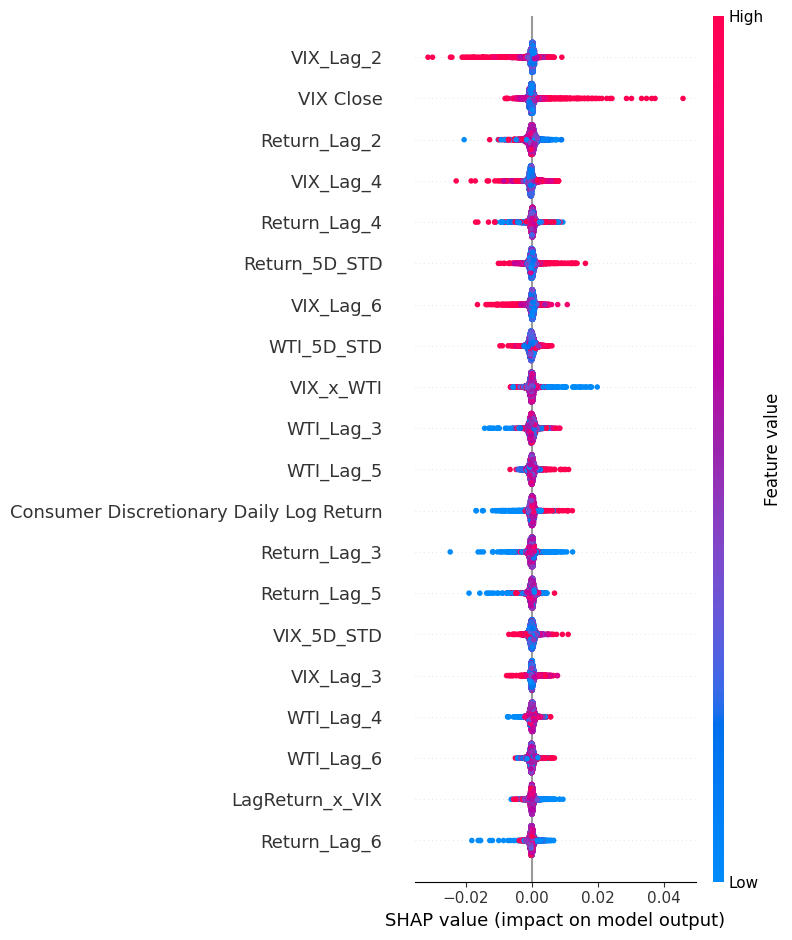

In [52]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP Explainer
explainer = shap.TreeExplainer(model)  # 'model' is your trained XGBoost model
shap_values = explainer.shap_values(X_train)  # 'X_train' is your feature DataFrame

# Create the SHAP Summary Plot (Beeswarm Plot with color coding by feature value)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, show=False)

# Add custom title to match thesis figure naming

plt.tight_layout()
plt.show()

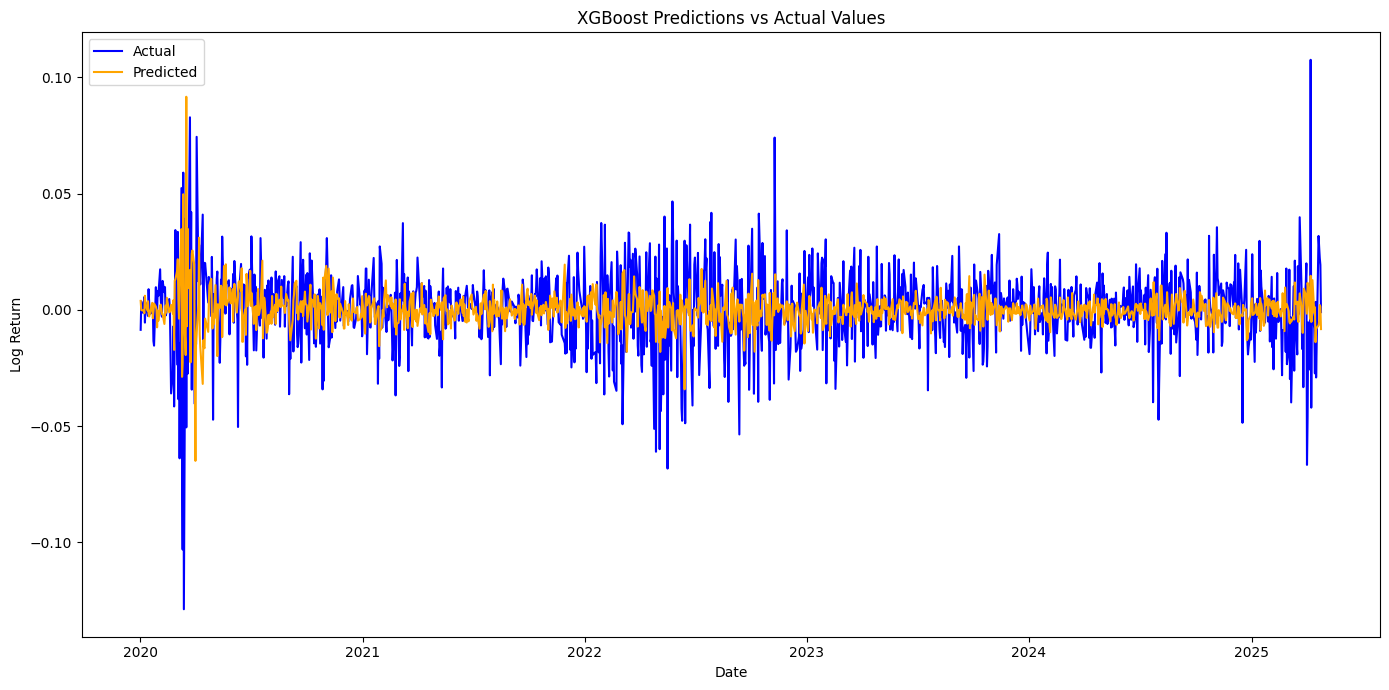

In [53]:
# Get date index from the original test set
test_index = test.index[-len(y_test):]

# Plotting the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test, label='Actual', color='blue')
plt.plot(test_index, y_pred, label='Predicted', color='orange')
plt.title("XGBoost Predictions vs Actual Values")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

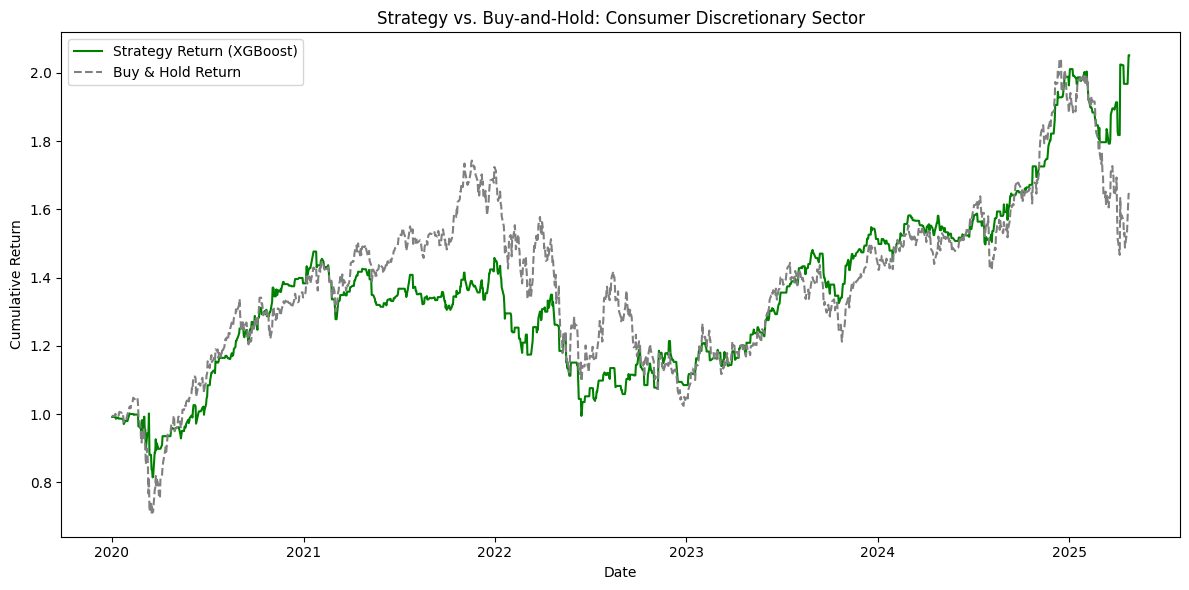

In [54]:
# ---------------------- STRATEGY SIMULATION ----------------------
#signal = np.where(y_pred > 0, 1, -1)
signal = np.where(y_pred > 0, 1, 0)  # Only buy when positive, otherwise stay out

strategy_returns = signal * y_test  # y_test is already a NumPy array

# Cumulative return using log returns -> exp of cumsum
cumulative_strategy = np.exp(np.cumsum(strategy_returns))
cumulative_bh = np.exp(np.cumsum(y_test))


plt.figure(figsize=(12, 6))
plt.plot(test_index, cumulative_strategy, label="Strategy Return (XGBoost)", color="green")
plt.plot(test_index, cumulative_bh, label="Buy & Hold Return", color="gray", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Strategy vs. Buy-and-Hold: Consumer Discretionary Sector")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

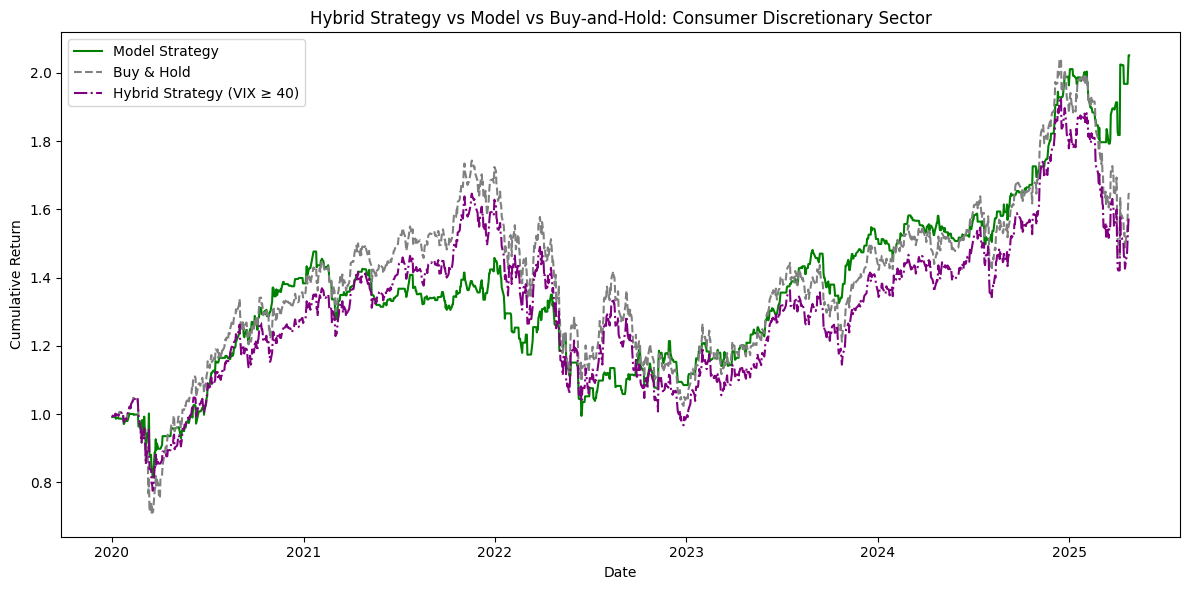

In [55]:
# ---------------------- HYBRID STRATEGY ----------------------

# Extract VIX values for the test period
vix_test = test["VIX Close"].values

# Hybrid strategy signal
hybrid_signal = np.where(vix_test >= 40, signal, 1)  # use model when VIX is high, otherwise hold

# Hybrid strategy returns
hybrid_returns = hybrid_signal * y_test

# Cumulative return using log returns
cumulative_hybrid = np.exp(np.cumsum(hybrid_returns))

# Plot all strategies
plt.figure(figsize=(12, 6))
plt.plot(test_index, cumulative_strategy, label="Model Strategy", color="green", linestyle="-")
plt.plot(test_index, cumulative_bh, label="Buy & Hold", color="gray", linestyle="--")
plt.plot(test_index, cumulative_hybrid, label="Hybrid Strategy (VIX ≥ 40)", color="purple", linestyle="-.")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Hybrid Strategy vs Model vs Buy-and-Hold: Consumer Discretionary Sector")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [56]:
# Calculate average annual return and volatility
trading_days_per_year = 252
annualized_return_strategy = np.mean(strategy_returns) * trading_days_per_year
annualized_volatility_strategy = np.std(strategy_returns) * np.sqrt(trading_days_per_year)

annualizd_return_hybrid = np.mean(hybrid_returns) * trading_days_per_year
annualized_volatility_hybrid = np.std(hybrid_returns) * np.sqrt(trading_days_per_year)

annualized_return_bh = np.mean(y_test) * trading_days_per_year
annualized_volatility_bh = np.std(y_test) * np.sqrt(trading_days_per_year)

# total return
total_return_strategy = np.exp(np.sum(strategy_returns)) - 1
total_return_bh = np.exp(np.sum(y_test)) - 1
total_return_hybrid = np.exp(np.sum(hybrid_returns)) - 1

print("\nAnnualized Performance:")
print(f"Strategy - Return: {annualized_return_strategy:.4f}, Volatility: {annualized_volatility_strategy:.4f}")
print(f"Buy & Hold - Return: {annualized_return_bh:.4f}, Volatility: {annualized_volatility_bh:.4f}")
print(f"Hybrid Strategy - Return: {annualizd_return_hybrid:.4f}, Volatility: {annualized_volatility_hybrid:.4f}")
print("\nTotal Return:")
print(f"Strategy: {total_return_strategy:.4f}")
print(f"Buy & Hold: {total_return_bh:.4f}")
print(f"Hybrid Strategy: {total_return_hybrid:.4f}")


Annualized Performance:
Strategy - Return: 0.1363, Volatility: 0.1987
Buy & Hold - Return: 0.0943, Volatility: 0.2706
Hybrid Strategy - Return: 0.0863, Volatility: 0.2608

Total Return:
Strategy: 1.0512
Buy & Hold: 0.6440
Hybrid Strategy: 0.5757


In [57]:
# statistical significance testing between the three to determine whether the hybrid strategy is statistically significantly better than the buy and hold
from scipy.stats import ttest_rel
# Calculate daily returns
strategy_daily_returns = np.diff(np.log(cumulative_strategy))
bh_daily_returns = np.diff(np.log(cumulative_bh))
hybrid_daily_returns = np.diff(np.log(cumulative_hybrid))
# Perform paired t-tests
t_stat_strategy_bh, p_value_strategy_bh = ttest_rel(strategy_daily_returns, bh_daily_returns)
t_stat_hybrid_bh, p_value_hybrid_bh = ttest_rel(hybrid_daily_returns, bh_daily_returns)
t_stat_hybrid_strategy, p_value_hybrid_strategy = ttest_rel(hybrid_daily_returns, strategy_daily_returns)
print("\nStatistical Significance Testing:")
print(f"Strategy vs Buy & Hold: t-stat={t_stat_strategy_bh:.4f}, p-value={p_value_strategy_bh:.4f}")
print(f"Hybrid vs Buy & Hold: t-stat={t_stat_hybrid_bh:.4f}, p-value={p_value_hybrid_bh:.4f}")
print(f"Hybrid vs Strategy: t-stat={t_stat_hybrid_strategy:.4f}, p-value={p_value_hybrid_strategy:.4f}")


Statistical Significance Testing:
Strategy vs Buy & Hold: t-stat=0.5249, p-value=0.5997
Hybrid vs Buy & Hold: t-stat=-0.2558, p-value=0.7981
Hybrid vs Strategy: t-stat=-0.6802, p-value=0.4965


In [24]:
# Drop NaN values caused by lagging

# Split into train and test sets (80% train, 20% test)
#train_size = int(0.8 * len(data_forecast_model))
#train, test = data_forecast_model.iloc[:train_size], data_forecast_model.iloc[train_size:]
# === SPLIT: Train on recent, test on OOS ===
train_start = "2005-01-01"
train_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2025-03-31"

train = data_forecast_model.loc[train_start:train_end]
test = data_forecast_model.loc[test_start:test_end]

# ---------------------- SCALE INPUT FEATURES ----------------------
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[selected_features])
test_scaled = scaler.transform(test[selected_features])

# Convert to DataFrame with correct index
train_scaled = pd.DataFrame(train_scaled, columns=selected_features, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=selected_features, index=test.index)

# Add back target column
train_scaled[target_column] = train[target_column].values
test_scaled[target_column] = test[target_column].values

NameError: name 'data_forecast_model' is not defined

Best parameters are:

In [127]:
import xgboost as xgb
params = {
    "objective": "reg:squarederror",
    "eta": 0.15,
    "max_depth": 50,
    "min_child_weight": 7,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "seed": 42
}
dtrain = xgb.DMatrix(train_scaled[selected_features], label=train_scaled[target_column])
dtest = xgb.DMatrix(test_scaled[selected_features], label=test_scaled[target_column])

num_boost_round = 100
model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

y_pred = model.predict(dtest)
y_test = test_scaled[target_column].values

# Inverse log transformation
#y_pred = np.expm1(y_pred)  # exp(x) - 1 to revert log(1 + x)
#y_test = np.expm1(test_scaled[target_column].values)  # exp(x) - 1 to revert log(1 + x)
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0082
RMSE: 0.0121


In [128]:

# Get date index from the original test set
test_index = test.index[-len(y_test):]

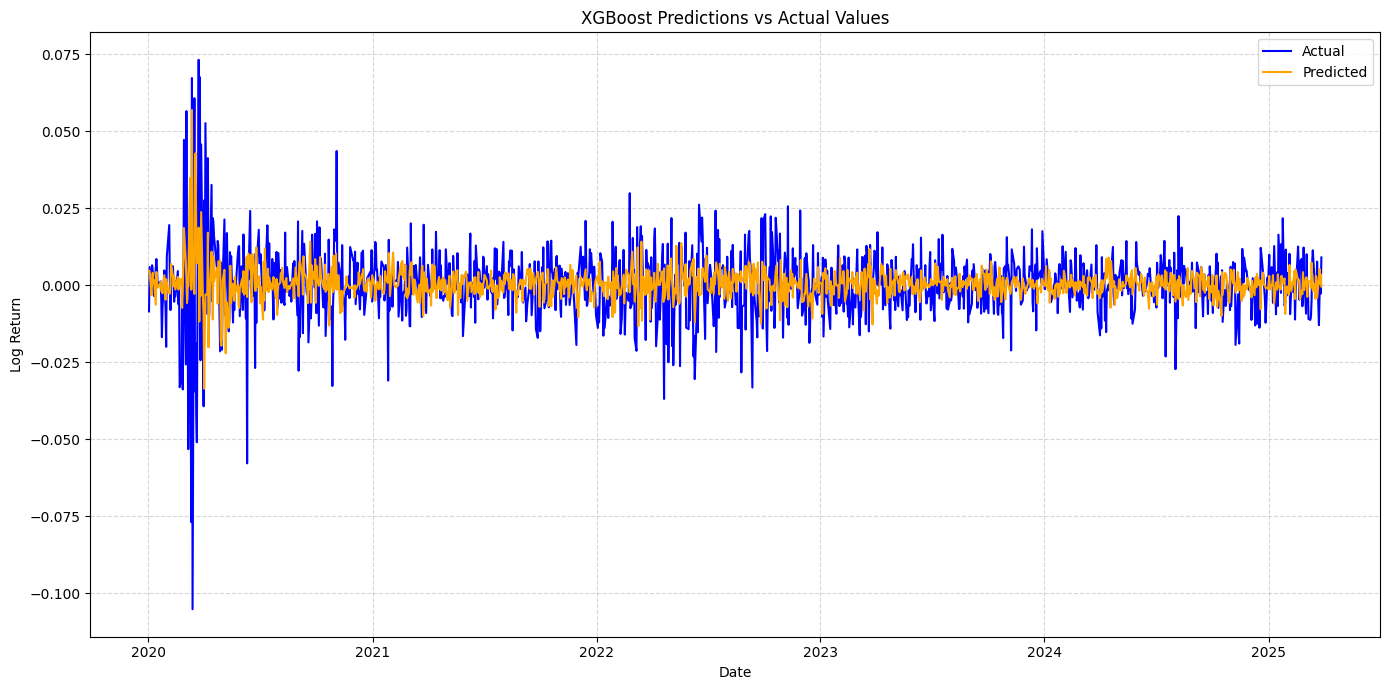

In [129]:
# Plotting the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test, label='Actual', color='blue')
plt.plot(test_index, y_pred, label='Predicted', color='orange')
plt.title("XGBoost Predictions vs Actual Values")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

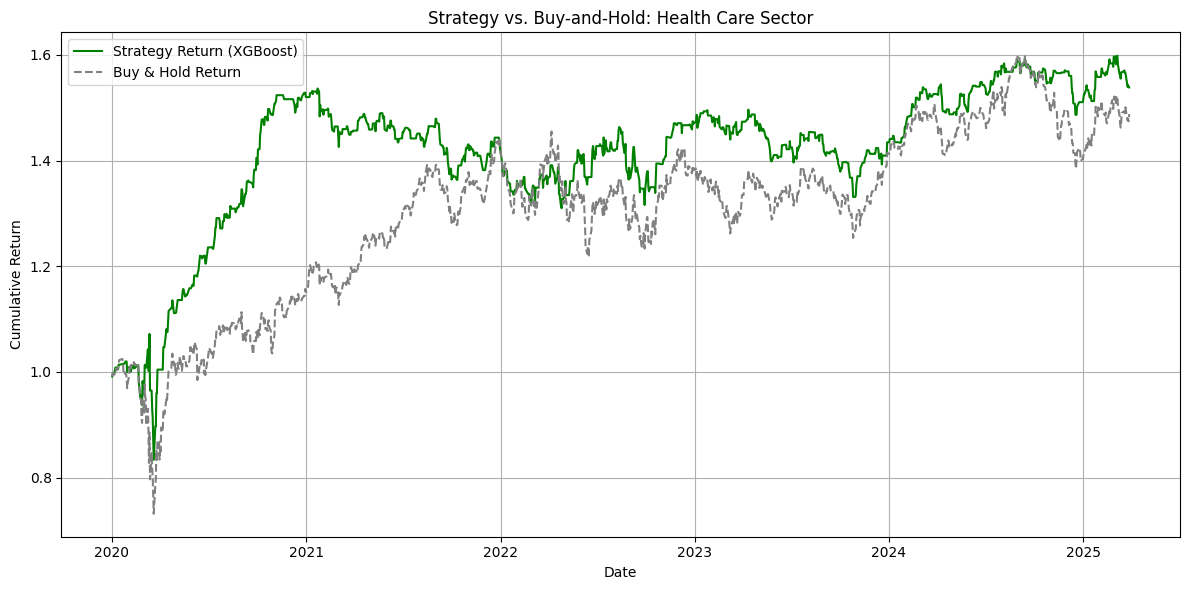

In [130]:
# ---------------------- STRATEGY SIMULATION ----------------------
#signal = np.where(y_pred > 0, 1, -1)
signal = np.where(y_pred > 0, 1, 0)  # Only buy when positive, otherwise stay out

strategy_returns = signal * y_test  # y_test is already a NumPy array

# Cumulative return using log returns -> exp of cumsum
cumulative_strategy = np.exp(np.cumsum(strategy_returns))
cumulative_bh = np.exp(np.cumsum(y_test))


plt.figure(figsize=(12, 6))
plt.plot(test_index, cumulative_strategy, label="Strategy Return (XGBoost)", color="green")
plt.plot(test_index, cumulative_bh, label="Buy & Hold Return", color="gray", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Strategy vs. Buy-and-Hold: Health Care Sector")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


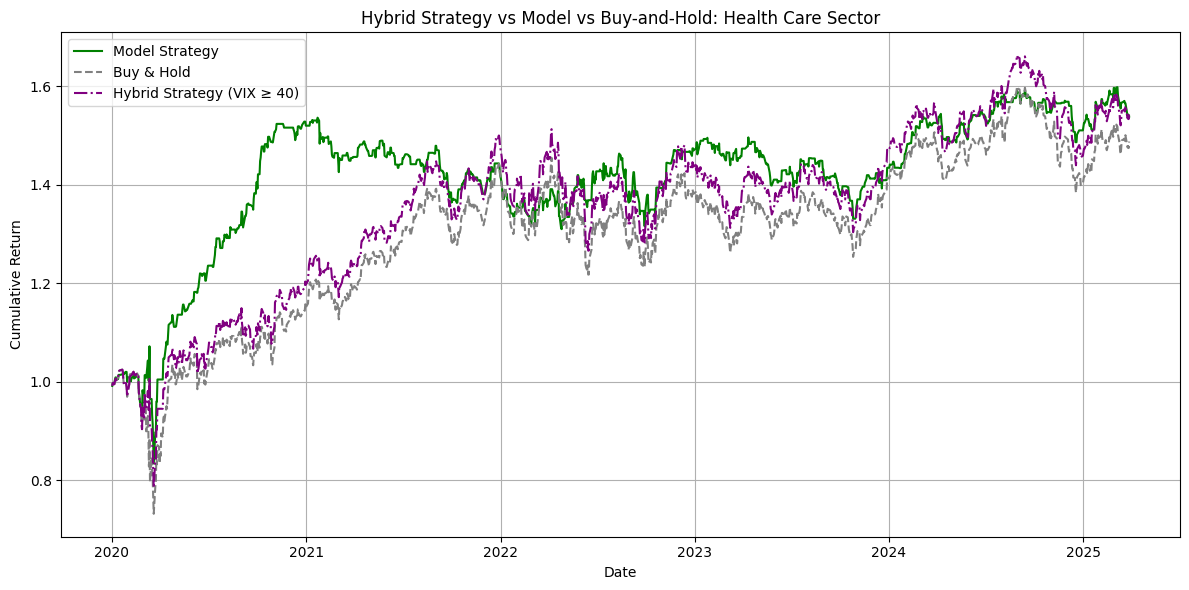

In [131]:
# ---------------------- HYBRID STRATEGY ----------------------

# Extract VIX values for the test period
vix_test = test["VIX Close"].values

# Hybrid strategy signal
hybrid_signal = np.where(vix_test >= 40, signal, 1)  # use model when VIX is high, otherwise hold

# Hybrid strategy returns
hybrid_returns = hybrid_signal * y_test

# Cumulative return using log returns
cumulative_hybrid = np.exp(np.cumsum(hybrid_returns))

# Plot all strategies
plt.figure(figsize=(12, 6))
plt.plot(test_index, cumulative_strategy, label="Model Strategy", color="green", linestyle="-")
plt.plot(test_index, cumulative_bh, label="Buy & Hold", color="gray", linestyle="--")
plt.plot(test_index, cumulative_hybrid, label="Hybrid Strategy (VIX ≥ 40)", color="purple", linestyle="-.")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Hybrid Strategy vs Model vs Buy-and-Hold: Health Care Sector")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [785]:
# Calculate average annual return and volatility
trading_days_per_year = 252
annualized_return_strategy = np.mean(strategy_returns) * trading_days_per_year
annualized_volatility_strategy = np.std(strategy_returns) * np.sqrt(trading_days_per_year)

annualizd_return_hybrid = np.mean(hybrid_returns) * trading_days_per_year
annualized_volatility_hybrid = np.std(hybrid_returns) * np.sqrt(trading_days_per_year)

annualized_return_bh = np.mean(y_test) * trading_days_per_year
annualized_volatility_bh = np.std(y_test) * np.sqrt(trading_days_per_year)

print("\nAnnualized Performance:")
print(f"Strategy - Return: {annualized_return_strategy:.4f}, Volatility: {annualized_volatility_strategy:.4f}")
print(f"Buy & Hold - Return: {annualized_return_bh:.4f}, Volatility: {annualized_volatility_bh:.4f}")
#print(f"Hybrid Strategy - Return: {annualizd_return_hybrid:.4f}, Volatility: {annualized_volatility_hybrid:.4f}")



Annualized Performance:
Strategy - Return: 0.2042, Volatility: 0.1628
Buy & Hold - Return: 0.1381, Volatility: 0.2457


In [730]:
# statistical significance testing between the three to determine whether the hybrid strategy is statistically significantly better than the buy and hold
from scipy.stats import ttest_rel
# Calculate daily returns
strategy_daily_returns = np.diff(np.log(cumulative_strategy))
bh_daily_returns = np.diff(np.log(cumulative_bh))
hybrid_daily_returns = np.diff(np.log(cumulative_hybrid))
# Perform paired t-tests
t_stat_strategy_bh, p_value_strategy_bh = ttest_rel(strategy_daily_returns, bh_daily_returns)
t_stat_hybrid_bh, p_value_hybrid_bh = ttest_rel(hybrid_daily_returns, bh_daily_returns)
t_stat_hybrid_strategy, p_value_hybrid_strategy = ttest_rel(hybrid_daily_returns, strategy_daily_returns)
print("\nStatistical Significance Testing:")
print(f"Strategy vs Buy & Hold: t-stat={t_stat_strategy_bh:.4f}, p-value={p_value_strategy_bh:.4f}")
print(f"Hybrid vs Buy & Hold: t-stat={t_stat_hybrid_bh:.4f}, p-value={p_value_hybrid_bh:.4f}")
print(f"Hybrid vs Strategy: t-stat={t_stat_hybrid_strategy:.4f}, p-value={p_value_hybrid_strategy:.4f}")



Statistical Significance Testing:
Strategy vs Buy & Hold: t-stat=-0.5563, p-value=0.5781
Hybrid vs Buy & Hold: t-stat=0.4132, p-value=0.6795
Hybrid vs Strategy: t-stat=0.8871, p-value=0.3752
